In [1]:
import os, sys
import torch
import numpy as np

from models import build_DABDETR, build_dab_deformable_detr
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or load an image from a local path(see Sec. 2).

# 0. Init and Load Pre-trained Models

In [2]:
!ls ./logs/dab_deformable_detr/R50/

checkpoint.pth	config.json  eval  info.txt  log.txt


In [3]:
model_config_path = "logs/dab_deformable_detr/R50/config.json" # change the path of the model config file
model_checkpoint_path = "logs/dab_deformable_detr/R50/checkpoint.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.


In [4]:
args = SLConfig.fromfile(model_config_path) 
model, criterion, postprocessors = build_dab_deformable_detr(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.cuda()

DABDeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_af

# 1. Visualize images from dataloader
## 1.1 Load Datasets

In [6]:
dataset_val = build_dataset(image_set='val', args=args)
cocojs = dataset_val.coco.dataset
id2name = {item['id']: item['name'] for item in cocojs['categories']}

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


# 1.2 Get an Example and Visualize it

In [10]:
image

tensor([[[-2.0323, -2.0152, -1.9809,  ..., -0.9534, -0.9534, -0.9534],
         [-2.0152, -2.0152, -1.9809,  ..., -0.9534, -0.9534, -0.9534],
         [-2.0152, -1.9980, -1.9638,  ..., -0.9534, -0.9534, -0.9534],
         ...,
         [-1.4329, -1.4329, -1.4329,  ..., -1.9638, -1.9638, -1.9638],
         [-1.4329, -1.4329, -1.4329,  ..., -1.9638, -1.9638, -1.9638],
         [-1.4329, -1.4329, -1.4329,  ..., -1.9638, -1.9638, -1.9638]],

        [[-1.9482, -1.9307, -1.8957,  ..., -0.4951, -0.4951, -0.4951],
         [-1.9307, -1.9307, -1.8957,  ..., -0.4951, -0.4951, -0.4951],
         [-1.9307, -1.9132, -1.8782,  ..., -0.4951, -0.4951, -0.4951],
         ...,
         [-1.2654, -1.2654, -1.2654,  ..., -1.8782, -1.8782, -1.8782],
         [-1.2654, -1.2654, -1.2654,  ..., -1.8782, -1.8782, -1.8782],
         [-1.2654, -1.2654, -1.2654,  ..., -1.8782, -1.8782, -1.8782]],

        [[-1.7173, -1.6999, -1.6650,  ...,  0.6531,  0.6531,  0.6531],
         [-1.6999, -1.6999, -1.6650,  ...,  0

In [13]:
# for image, targets in dataset_val:
#     output = model(torch.Tensor(image).cuda())

In [14]:
image, targets = dataset_val[0]

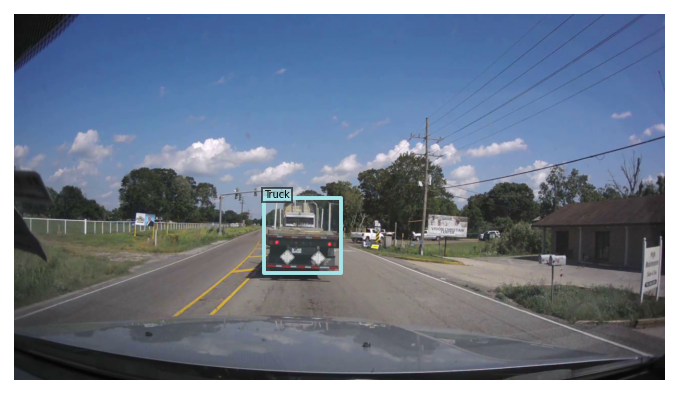

In [15]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [16]:
postprocessors.keys()

dict_keys(['bbox'])

In [17]:
output = model(torch.Tensor(image[None]).cuda())
output

/Motive/DAB-DETR/models/dab_deformable_detr/position_encoding.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Motive/DAB-DETR/models/dab_deformable_detr/deformable_transformer.py:489: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytor

{'pred_logits': tensor([[[ -9.3246,  -6.1094,  -6.2962,  ...,  -8.8037, -10.0182,  -8.1385],
          [ -9.3823,  -5.5000,  -4.2559,  ...,  -8.7061,  -9.4282,  -8.2893],
          [ -9.4314,  -5.7317,  -6.7574,  ...,  -8.8835, -10.1100,  -8.5044],
          ...,
          [ -9.5838,  -4.2011,  -4.9050,  ...,  -7.2885,  -9.1240,  -7.8842],
          [ -9.2661,  -6.3525,  -7.6135,  ...,  -8.8487,  -9.6140,  -8.5169],
          [ -9.3435,  -5.9285,  -6.3749,  ...,  -8.9182, -10.2948,  -8.2749]]],
        device='cuda:0', grad_fn=<SelectBackward0>),
 'pred_boxes': tensor([[[0.2430, 0.6040, 0.4798, 0.4489],
          [0.5483, 0.5925, 0.0497, 0.0627],
          [0.9321, 0.8023, 0.1269, 0.2300],
          ...,
          [0.4236, 0.5760, 0.0122, 0.0126],
          [0.6115, 0.1073, 0.2171, 0.2199],
          [0.5905, 0.6681, 0.8035, 0.3500]]], device='cuda:0',
        grad_fn=<SelectBackward0>),
 'aux_outputs': [{'pred_logits': tensor([[[ -9.0911,  -5.5071,  -5.6110,  ...,  -7.5893,  -7.8024, 

In [18]:
postprocessors['bbox']

PostProcess()

In [19]:
output = {x:(y.cpu() if type(y)!=list else y) for x,y in output.items()}

In [20]:
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]))[0]

/Motive/DAB-DETR/models/dab_deformable_detr/dab_deformable_detr.py:463: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_boxes = topk_indexes // out_logits.shape[2]


In [21]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

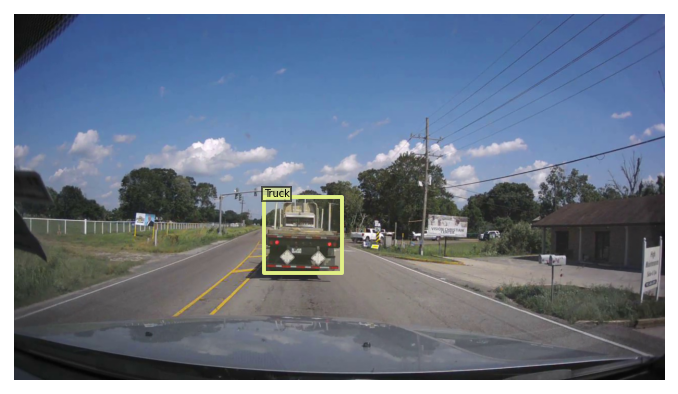

In [22]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

In [23]:
pred_dict

{'boxes': tensor([[0.4429, 0.6035, 0.1197, 0.2067]]),
 'size': tensor([ 750, 1333]),
 'box_label': ['Truck']}

# 2. Visualize Custom Images

In [24]:
import json

In [31]:
from PIL import Image
import datasets.transforms as T

In [27]:
from os.path import join as pjoin

In [28]:
image_dir=r'/Motive/data/public_test/test2_images'

In [29]:
def box_xyxy_to_xywh(x, y_dim,x_dim):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [((x0))*x_dim, ((y0))*y_dim,
         abs(x1 - x0)*x_dim, abs(y1 - y0)*y_dim]
    return torch.stack(b, dim=-1)

In [32]:
transform = T.Compose([
#     T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [33]:

categories = []

In [34]:
categories = [
      {
        "supercategory": "none",
        "id": 1,
        "name": "Car"
      },
      {
        "supercategory": "none",
        "id": 2,
        "name": "Truck"
      },
      {
        "supercategory": "none",
        "id": 3,
        "name": "StopSign"
      },
      {
        "supercategory": "none",
        "id": 4,
        "name": "traffic_lights"
      }
    ]

In [35]:
str_to_int = {'Car': 1, 'Truck': 2, 'StopSign': 3, 'traffic_lights': 4}

In [36]:
thershold = 0.4 # set a thershold

In [37]:
images = []
annotations = []
cnt = 0
for image_file in os.listdir(image_dir):
    print(image_file)
    img = Image.open(pjoin(image_dir,image_file)).convert("RGB")
    image, _ = transform(img, None)
    output = model(image[None].cuda())
    output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]
    # visualize outputs

    scores = output['scores']
    labels = output['labels']
    boxes = box_xyxy_to_xywh(output['boxes'], 720, 1280)
    select_mask = scores > thershold

    box_label = [id2name[int(item)] for item in labels[select_mask]]
    pred_dict = {
        'boxes': boxes[select_mask],
        'size': torch.Tensor([image.shape[1], image.shape[2]]),
        'box_label': box_label
    }
    image_anno = {
            "file_name":image_file,
            "id": cnt,
            "height":720,
            "width":  1280
        }
    images.append(image_anno)
    for index, bbox in enumerate(pred_dict['boxes']):
        p = {
            "image_id": cnt,
            "bbox": list(map(int, bbox.cpu().tolist())),
                "category_id": str_to_int[box_label[index]],
                "id": index,
                "confidence": round(float(scores[index]), 1)
              }
        print(p)
        annotations.append(p)

    cnt += 1
#     vslzr.visualize(image, pred_dict, savedir=None)
    
    

0022b971-8948-4dc5-bb42-a6084287b50a.jpeg
{'image_id': 0, 'bbox': [259, 345, 116, 71], 'category_id': 1, 'id': 0, 'confidence': 0.7}
002a078f-8eb9-41f1-9163-95c8d5982411.jpeg
{'image_id': 1, 'bbox': [667, 565, 13, 10], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 1, 'bbox': [645, 565, 11, 9], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1, 'bbox': [755, 547, 11, 14], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 1, 'bbox': [717, 549, 33, 42], 'category_id': 2, 'id': 3, 'confidence': 0.5}
004b8a40-836c-48e5-97cb-a0d417738d5d.jpeg
{'image_id': 2, 'bbox': [335, 376, 42, 30], 'category_id': 2, 'id': 0, 'confidence': 0.4}
005fc3eb-1672-4162-be97-3b354be64428.jpeg
{'image_id': 3, 'bbox': [316, 406, 68, 36], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3, 'bbox': [582, 377, 37, 18], 'category_id': 2, 'id': 1, 'confidence': 0.4}
00605f58-63f8-459d-a9df-e117b4e896e4.jpeg
{'image_id': 4, 'bbox': [443, 517, 99, 44], 'category_id': 1, 'id': 0,

{'image_id': 22, 'bbox': [696, 403, 79, 56], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 22, 'bbox': [776, 441, 217, 139], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 22, 'bbox': [774, 374, 30, 18], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 22, 'bbox': [727, 313, 8, 16], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 22, 'bbox': [1218, 403, 48, 26], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 22, 'bbox': [856, 382, 64, 23], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 22, 'bbox': [227, 335, 293, 76], 'category_id': 2, 'id': 6, 'confidence': 0.6}
{'image_id': 22, 'bbox': [1101, 383, 28, 20], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 22, 'bbox': [795, 373, 36, 20], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 22, 'bbox': [929, 378, 27, 19], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 22, 'bbox': [756, 370, 29, 19], 'category_id': 1, 'id': 10, 'confidence':

{'image_id': 37, 'bbox': [1230, 419, 48, 49], 'category_id': 3, 'id': 0, 'confidence': 0.7}
{'image_id': 37, 'bbox': [703, 473, 53, 28], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 37, 'bbox': [728, 476, 34, 42], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 37, 'bbox': [716, 464, 253, 196], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 37, 'bbox': [935, 483, 69, 62], 'category_id': 1, 'id': 4, 'confidence': 0.5}
023139ba-81e0-4b0d-bf6c-cbdc8280ba32.jpeg
024f231d-2816-469a-8ea7-7851ee43f970.jpeg
{'image_id': 39, 'bbox': [866, 260, 115, 65], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 39, 'bbox': [1063, 263, 122, 54], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 39, 'bbox': [708, 232, 29, 14], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 39, 'bbox': [816, 238, 54, 29], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 39, 'bbox': [886, 210, 108, 67], 'category_id': 2, 'id': 4, 'confidence': 0.5}

{'image_id': 67, 'bbox': [442, 388, 52, 34], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 67, 'bbox': [559, 379, 26, 17], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 67, 'bbox': [489, 384, 34, 23], 'category_id': 1, 'id': 2, 'confidence': 0.5}
04001086-1b63-441d-bd8b-9aeeeac9c7aa.jpeg
0420415b-bda5-43fa-b00f-ef7dbb22e2b0.jpeg
{'image_id': 69, 'bbox': [0, 519, 41, 33], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 69, 'bbox': [309, 513, 47, 14], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 69, 'bbox': [354, 495, 25, 15], 'category_id': 3, 'id': 2, 'confidence': 0.7}
{'image_id': 69, 'bbox': [596, 500, 25, 15], 'category_id': 3, 'id': 3, 'confidence': 0.6}
04217f30-0e06-4086-b179-8b2590e880b6.jpeg
{'image_id': 70, 'bbox': [225, 369, 221, 111], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 70, 'bbox': [0, 364, 75, 72], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 70, 'bbox': [342, 324, 49, 25], 'category_id

{'image_id': 84, 'bbox': [598, 306, 13, 12], 'category_id': 1, 'id': 0, 'confidence': 0.6}
04c6305d-0ec5-4dbc-ad79-89bc0dae3ebd.jpeg
{'image_id': 85, 'bbox': [9, 299, 46, 23], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 85, 'bbox': [220, 286, 18, 7], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 85, 'bbox': [273, 285, 37, 12], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 85, 'bbox': [0, 297, 22, 21], 'category_id': 1, 'id': 3, 'confidence': 0.4}
04e3a4cd-c686-410e-bbe9-797717bd9ac2.jpeg
{'image_id': 86, 'bbox': [790, 109, 62, 31], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 86, 'bbox': [599, 64, 49, 51], 'category_id': 2, 'id': 1, 'confidence': 0.6}
{'image_id': 86, 'bbox': [785, 66, 7, 15], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 86, 'bbox': [663, 69, 96, 65], 'category_id': 2, 'id': 3, 'confidence': 0.5}
{'image_id': 86, 'bbox': [510, 49, 5, 9], 'category_id': 4, 'id': 4, 'confidence': 0.5}
{'image_id': 86, '

{'image_id': 105, 'bbox': [341, 193, 118, 36], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 105, 'bbox': [466, 179, 39, 18], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 105, 'bbox': [753, 186, 72, 45], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 105, 'bbox': [792, 123, 6, 9], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 105, 'bbox': [563, 177, 33, 16], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 105, 'bbox': [725, 125, 9, 9], 'category_id': 4, 'id': 5, 'confidence': 0.7}
{'image_id': 105, 'bbox': [510, 176, 31, 14], 'category_id': 1, 'id': 6, 'confidence': 0.7}
{'image_id': 105, 'bbox': [659, 167, 17, 9], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 105, 'bbox': [1046, 185, 37, 23], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 105, 'bbox': [543, 173, 30, 13], 'category_id': 1, 'id': 9, 'confidence': 0.6}
05ae2be1-970a-4f97-b91a-f07747ea9bc2.jpeg
{'image_id': 106, 'bbox': [228, 257, 39, 

{'image_id': 119, 'bbox': [390, 325, 43, 25], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 119, 'bbox': [350, 316, 19, 9], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 119, 'bbox': [423, 318, 23, 12], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 119, 'bbox': [381, 310, 18, 8], 'category_id': 1, 'id': 3, 'confidence': 0.4}
064ed469-8fa3-4783-af2b-a4a1a82b0388.jpeg
{'image_id': 120, 'bbox': [353, 573, 65, 33], 'category_id': 1, 'id': 0, 'confidence': 0.7}
0652e12d-9b7f-494a-9b17-36ab36d97fab.jpeg
{'image_id': 121, 'bbox': [1135, 440, 83, 82], 'category_id': 3, 'id': 0, 'confidence': 0.8}
068e36bb-279d-4951-99f6-8a365248bf13.jpeg
{'image_id': 122, 'bbox': [561, 550, 51, 34], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 122, 'bbox': [686, 553, 25, 16], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 122, 'bbox': [410, 547, 157, 51], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 122, 'bbox': [851, 538, 71, 53], 

{'image_id': 143, 'bbox': [1157, 224, 88, 93], 'category_id': 3, 'id': 0, 'confidence': 0.6}
{'image_id': 143, 'bbox': [803, 289, 31, 15], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 143, 'bbox': [1095, 282, 33, 20], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 143, 'bbox': [914, 287, 26, 13], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 143, 'bbox': [1140, 283, 11, 7], 'category_id': 1, 'id': 4, 'confidence': 0.4}
089dfd65-e588-45ac-a9e3-0abc4de68900.jpeg
{'image_id': 144, 'bbox': [561, 423, 90, 39], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 144, 'bbox': [287, 446, 149, 75], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 144, 'bbox': [763, 412, 55, 24], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 144, 'bbox': [72, 348, 266, 137], 'category_id': 2, 'id': 3, 'confidence': 0.5}
{'image_id': 144, 'bbox': [329, 413, 25, 19], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 144, 'bbox': [0, 420,

{'image_id': 161, 'bbox': [779, 346, 51, 34], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 161, 'bbox': [754, 341, 13, 7], 'category_id': 1, 'id': 1, 'confidence': 0.5}
09daed96-f64c-434f-8f52-f06137f90686.jpeg
{'image_id': 162, 'bbox': [504, 277, 115, 91], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 162, 'bbox': [665, 156, 405, 286], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 162, 'bbox': [544, 260, 57, 26], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 162, 'bbox': [567, 254, 35, 23], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 162, 'bbox': [608, 233, 36, 37], 'category_id': 2, 'id': 4, 'confidence': 0.5}
{'image_id': 162, 'bbox': [647, 260, 21, 12], 'category_id': 1, 'id': 5, 'confidence': 0.5}
09e91923-d07b-4523-85d8-9c5d03e0ab63.jpeg
{'image_id': 163, 'bbox': [634, 297, 59, 20], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 163, 'bbox': [275, 325, 136, 59], 'category_id': 1, 'id': 1, 'confidence'

{'image_id': 181, 'bbox': [279, 338, 207, 160], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 181, 'bbox': [528, 230, 20, 16], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 181, 'bbox': [387, 266, 38, 31], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 181, 'bbox': [633, 204, 40, 30], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 181, 'bbox': [200, 313, 72, 59], 'category_id': 1, 'id': 4, 'confidence': 0.4}
0b3a6e29-2e43-4a38-9c5f-fbfbbefeaa55.jpeg
{'image_id': 182, 'bbox': [512, 436, 60, 37], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 182, 'bbox': [336, 425, 27, 21], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 182, 'bbox': [293, 422, 27, 20], 'category_id': 2, 'id': 2, 'confidence': 0.4}
0b3cc96f-edb8-431f-87cb-8e3850f6c74e.jpeg
{'image_id': 183, 'bbox': [187, 103, 38, 23], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 183, 'bbox': [79, 116, 43, 23], 'category_id': 1, 'id': 1, 'confidence': 

{'image_id': 194, 'bbox': [863, 426, 93, 45], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 194, 'bbox': [599, 397, 40, 22], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 194, 'bbox': [650, 405, 58, 37], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 194, 'bbox': [88, 385, 500, 192], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 194, 'bbox': [935, 435, 192, 92], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 194, 'bbox': [729, 328, 129, 133], 'category_id': 2, 'id': 5, 'confidence': 0.6}
{'image_id': 194, 'bbox': [826, 415, 55, 34], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 194, 'bbox': [684, 401, 34, 29], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 194, 'bbox': [642, 399, 20, 13], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 194, 'bbox': [1044, 435, 62, 24], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 194, 'bbox': [910, 420, 48, 23], 'category_id': 1, 'id': 10, '

{'image_id': 211, 'bbox': [86, 216, 95, 30], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 211, 'bbox': [371, 232, 13, 11], 'category_id': 1, 'id': 1, 'confidence': 0.5}
0d082da9-e032-4b05-a2ca-2751d203f1f4.jpeg
{'image_id': 212, 'bbox': [1239, 301, 40, 32], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 212, 'bbox': [1168, 343, 110, 28], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 212, 'bbox': [891, 337, 55, 13], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 212, 'bbox': [0, 203, 704, 454], 'category_id': 2, 'id': 3, 'confidence': 0.4}
{'image_id': 212, 'bbox': [1160, 341, 51, 22], 'category_id': 1, 'id': 4, 'confidence': 0.4}
0d0c54a7-cd84-497f-93eb-8f7769c9681b.jpeg
{'image_id': 213, 'bbox': [384, 337, 46, 19], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 213, 'bbox': [228, 376, 225, 149], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 213, 'bbox': [290, 341, 46, 17], 'category_id': 1, 'id': 2, 'confidenc

{'image_id': 229, 'bbox': [690, 271, 18, 17], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 229, 'bbox': [199, 273, 22, 12], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 229, 'bbox': [390, 283, 13, 8], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 229, 'bbox': [405, 280, 18, 11], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 229, 'bbox': [231, 277, 17, 9], 'category_id': 1, 'id': 4, 'confidence': 0.4}
0da0f2db-d9eb-4d82-a338-9933c4e95680.jpeg
{'image_id': 230, 'bbox': [372, 289, 77, 18], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 230, 'bbox': [166, 297, 57, 18], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 230, 'bbox': [184, 317, 97, 47], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 230, 'bbox': [938, 224, 11, 11], 'category_id': 4, 'id': 3, 'confidence': 0.5}
{'image_id': 230, 'bbox': [749, 254, 145, 44], 'category_id': 2, 'id': 4, 'confidence': 0.5}
0daffcfa-f8e8-474e-b700-043bde51afa7.jp

{'image_id': 249, 'bbox': [769, 308, 132, 54], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 249, 'bbox': [648, 208, 11, 24], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 249, 'bbox': [475, 301, 34, 24], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 249, 'bbox': [820, 205, 10, 24], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 249, 'bbox': [746, 204, 11, 23], 'category_id': 4, 'id': 4, 'confidence': 0.5}
{'image_id': 249, 'bbox': [643, 306, 128, 66], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 249, 'bbox': [973, 194, 12, 30], 'category_id': 4, 'id': 6, 'confidence': 0.4}
0e8c0eed-c8ef-473b-b8bc-05df70dc2f3f.jpeg
{'image_id': 250, 'bbox': [448, 266, 47, 22], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 250, 'bbox': [265, 281, 57, 23], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 250, 'bbox': [376, 269, 49, 22], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 250, 'bbox': [2, 303, 1

{'image_id': 272, 'bbox': [411, 346, 37, 15], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 272, 'bbox': [649, 347, 15, 11], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 272, 'bbox': [486, 348, 27, 12], 'category_id': 1, 'id': 2, 'confidence': 0.5}
0fd5b106-dcd5-49a5-a892-db0de7954667.jpeg
{'image_id': 273, 'bbox': [555, 294, 32, 21], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 273, 'bbox': [540, 282, 21, 11], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 273, 'bbox': [568, 283, 22, 14], 'category_id': 1, 'id': 2, 'confidence': 0.4}
0fd7e42e-7cba-4539-a87e-b367f1cb9501.jpeg
0fe137b8-1b2d-4e6a-9ffa-18145494f4dc.jpeg
{'image_id': 275, 'bbox': [1032, 425, 45, 39], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 275, 'bbox': [396, 460, 38, 30], 'category_id': 3, 'id': 1, 'confidence': 0.8}
0fe27500-51fd-43bc-89d7-8d84e58ea102.jpeg
{'image_id': 276, 'bbox': [686, 403, 72, 49], 'category_id': 1, 'id': 0, 'confidence': 0.7}
0fe

{'image_id': 292, 'bbox': [799, 449, 42, 57], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 292, 'bbox': [543, 452, 41, 56], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 292, 'bbox': [593, 658, 31, 17], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 292, 'bbox': [0, 652, 116, 53], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 292, 'bbox': [1063, 637, 84, 25], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 292, 'bbox': [101, 658, 115, 41], 'category_id': 1, 'id': 5, 'confidence': 0.5}
105b6ee0-5887-48d6-96ee-0626e054febe.jpeg
{'image_id': 293, 'bbox': [270, 326, 55, 33], 'category_id': 2, 'id': 0, 'confidence': 0.6}
105ce4d6-5c70-4cde-a16b-424b8c3ff384.jpeg
{'image_id': 294, 'bbox': [535, 175, 60, 51], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 294, 'bbox': [596, 158, 29, 26], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 294, 'bbox': [534, 168, 27, 23], 'category_id': 1, 'id': 2, 'confidence': 

{'image_id': 310, 'bbox': [143, 298, 131, 63], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 310, 'bbox': [454, 292, 49, 40], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 310, 'bbox': [116, 294, 63, 35], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 310, 'bbox': [565, 290, 57, 22], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 310, 'bbox': [422, 221, 8, 16], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 310, 'bbox': [344, 294, 68, 47], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 310, 'bbox': [334, 286, 22, 19], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 310, 'bbox': [307, 286, 32, 23], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 310, 'bbox': [612, 289, 44, 22], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 310, 'bbox': [462, 221, 9, 13], 'category_id': 4, 'id': 9, 'confidence': 0.6}
{'image_id': 310, 'bbox': [380, 225, 8, 14], 'category_id': 4, 'id': 10, 'confide

119a698b-0e16-4075-aa2e-0cb4b509e869.jpeg
119ebeaa-cfb4-4c0f-a66d-f27187b3d005.jpeg
{'image_id': 324, 'bbox': [901, 239, 106, 140], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 324, 'bbox': [587, 314, 10, 9], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 324, 'bbox': [802, 310, 55, 31], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 324, 'bbox': [855, 305, 49, 33], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 324, 'bbox': [1013, 279, 29, 43], 'category_id': 3, 'id': 4, 'confidence': 0.5}
11a4a75e-ad2f-4d02-ad51-6551d4e185ec.jpeg
{'image_id': 325, 'bbox': [175, 217, 18, 10], 'category_id': 1, 'id': 0, 'confidence': 0.5}
11abc758-b6b9-41a1-a6ab-0365b98cedd5.jpeg
{'image_id': 326, 'bbox': [0, 354, 219, 132], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 326, 'bbox': [326, 329, 257, 77], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 326, 'bbox': [959, 309, 34, 14], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{

{'image_id': 350, 'bbox': [653, 381, 99, 77], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 350, 'bbox': [454, 356, 14, 14], 'category_id': 3, 'id': 1, 'confidence': 0.7}
{'image_id': 350, 'bbox': [380, 379, 21, 9], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 350, 'bbox': [1191, 437, 88, 133], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 350, 'bbox': [586, 288, 8, 19], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 350, 'bbox': [425, 382, 24, 10], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 350, 'bbox': [658, 291, 8, 19], 'category_id': 4, 'id': 6, 'confidence': 0.6}
{'image_id': 350, 'bbox': [174, 374, 80, 34], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 350, 'bbox': [1086, 389, 76, 32], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 350, 'bbox': [529, 380, 16, 8], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 350, 'bbox': [745, 383, 18, 10], 'category_id': 1, 'id': 10, 'confid

{'image_id': 372, 'bbox': [0, 556, 304, 107], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 372, 'bbox': [686, 524, 39, 36], 'category_id': 2, 'id': 1, 'confidence': 0.6}
13f30d19-cbb8-4277-9b93-fc3503e5f821.jpeg
{'image_id': 373, 'bbox': [755, 266, 23, 14], 'category_id': 1, 'id': 0, 'confidence': 0.5}
13ff01ba-4396-48b6-8420-8b70fca4d989.jpeg
{'image_id': 374, 'bbox': [94, 327, 290, 129], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 374, 'bbox': [487, 281, 58, 19], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 374, 'bbox': [862, 239, 12, 6], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 374, 'bbox': [852, 274, 19, 9], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 374, 'bbox': [673, 279, 86, 21], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 374, 'bbox': [797, 239, 10, 9], 'category_id': 4, 'id': 5, 'confidence': 0.6}
{'image_id': 374, 'bbox': [663, 274, 42, 17], 'category_id': 1, 'id': 6, 'confidence': 0.5

{'image_id': 392, 'bbox': [520, 277, 40, 48], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 392, 'bbox': [220, 319, 127, 80], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 392, 'bbox': [475, 296, 17, 11], 'category_id': 1, 'id': 2, 'confidence': 0.5}
14f902fc-2b01-4eff-882d-23da950328e8.jpeg
{'image_id': 393, 'bbox': [650, 261, 27, 31], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 393, 'bbox': [608, 281, 22, 12], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 393, 'bbox': [488, 280, 18, 7], 'category_id': 1, 'id': 2, 'confidence': 0.4}
14fdfe3c-1865-4ab3-af85-b8bb9e2b46dd.jpeg
{'image_id': 394, 'bbox': [552, 356, 31, 23], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 394, 'bbox': [578, 326, 35, 40], 'category_id': 2, 'id': 1, 'confidence': 0.6}
{'image_id': 394, 'bbox': [175, 380, 52, 25], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 394, 'bbox': [621, 319, 45, 57], 'category_id': 2, 'id': 3, 'confidence': 0

{'image_id': 410, 'bbox': [615, 273, 89, 76], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 410, 'bbox': [539, 229, 31, 21], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 410, 'bbox': [619, 230, 15, 16], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 410, 'bbox': [506, 203, 32, 22], 'category_id': 2, 'id': 3, 'confidence': 0.5}
15c0bfaf-dbae-4639-b83a-cb6631b5e617.jpeg
{'image_id': 411, 'bbox': [911, 85, 95, 68], 'category_id': 2, 'id': 0, 'confidence': 0.6}
15c304a6-ee3c-48a7-b800-e5ad5a564554.jpeg
{'image_id': 412, 'bbox': [284, 150, 48, 18], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 412, 'bbox': [463, 145, 37, 19], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 412, 'bbox': [402, 147, 41, 18], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 412, 'bbox': [532, 141, 23, 12], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 412, 'bbox': [559, 141, 18, 9], 'category_id': 1, 'id': 4, 'confidence': 0.6

{'image_id': 431, 'bbox': [1196, 188, 84, 152], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 431, 'bbox': [647, 192, 12, 9], 'category_id': 1, 'id': 1, 'confidence': 0.5}
171a9f41-0df8-406d-bb96-59566f6d9553.jpeg
{'image_id': 432, 'bbox': [702, 367, 136, 85], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 432, 'bbox': [605, 336, 66, 29], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 432, 'bbox': [269, 361, 36, 13], 'category_id': 1, 'id': 2, 'confidence': 0.4}
171e97b2-7967-466c-8a8b-b9be2090906f.jpeg
{'image_id': 433, 'bbox': [242, 345, 290, 131], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 433, 'bbox': [25, 345, 203, 84], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 433, 'bbox': [1139, 332, 58, 21], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 433, 'bbox': [195, 355, 90, 46], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 433, 'bbox': [413, 309, 10, 12], 'category_id': 4, 'id': 4, 'confidenc

{'image_id': 449, 'bbox': [949, 219, 48, 19], 'category_id': 1, 'id': 0, 'confidence': 0.7}
1809ef3a-7226-49d9-b4b7-cfd9cc149401.jpeg
{'image_id': 450, 'bbox': [323, 403, 73, 40], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 450, 'bbox': [472, 400, 54, 36], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 450, 'bbox': [421, 406, 32, 17], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 450, 'bbox': [0, 404, 151, 129], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 450, 'bbox': [579, 400, 68, 42], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 450, 'bbox': [448, 407, 20, 12], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 450, 'bbox': [546, 402, 35, 21], 'category_id': 1, 'id': 6, 'confidence': 0.5}
180cd783-2071-459c-bcad-587e070c7bff.jpeg
{'image_id': 451, 'bbox': [623, 140, 50, 49], 'category_id': 2, 'id': 0, 'confidence': 0.7}
180faf3a-4d3b-455b-928c-8a349dd664f5.jpeg
{'image_id': 452, 'bbox': [103, 310, 62, 29], 

{'image_id': 465, 'bbox': [792, 379, 35, 12], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 465, 'bbox': [887, 381, 35, 13], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 465, 'bbox': [1078, 405, 9, 20], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 465, 'bbox': [1057, 406, 12, 25], 'category_id': 4, 'id': 3, 'confidence': 0.4}
19192edc-40ad-436e-8230-4c6298d6a8b5.jpeg
{'image_id': 466, 'bbox': [635, 591, 79, 70], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 466, 'bbox': [591, 562, 18, 16], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 466, 'bbox': [369, 616, 125, 87], 'category_id': 1, 'id': 2, 'confidence': 0.5}
192b4f88-c2da-4ff1-8ffc-b786a8a770a8.jpeg
{'image_id': 467, 'bbox': [75, 263, 194, 103], 'category_id': 1, 'id': 0, 'confidence': 0.8}
192c44ae-30ad-4ea8-ad4a-4eee6322d881.jpeg
193f65fb-7685-4153-8480-da8c8251d7f4.jpeg
{'image_id': 469, 'bbox': [1065, 469, 114, 62], 'category_id': 1, 'id': 0, 'confidence': 0.9}

{'image_id': 483, 'bbox': [746, 466, 58, 38], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 483, 'bbox': [469, 464, 98, 51], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 483, 'bbox': [306, 460, 41, 16], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 483, 'bbox': [396, 470, 59, 28], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 483, 'bbox': [122, 460, 193, 71], 'category_id': 1, 'id': 4, 'confidence': 0.4}
1a160f8a-8bb5-4a5d-8d95-1d8c4b6d0a44.jpeg
{'image_id': 484, 'bbox': [505, 325, 51, 41], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 484, 'bbox': [313, 307, 74, 35], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 484, 'bbox': [333, 280, 22, 23], 'category_id': 3, 'id': 2, 'confidence': 0.8}
{'image_id': 484, 'bbox': [531, 314, 36, 35], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 484, 'bbox': [602, 273, 17, 18], 'category_id': 3, 'id': 4, 'confidence': 0.7}
{'image_id': 484, 'bbox': [459, 307, 

{'image_id': 505, 'bbox': [943, 246, 59, 66], 'category_id': 3, 'id': 0, 'confidence': 0.8}
1b236c41-4576-469c-96b7-2cdd54abab4d.jpeg
{'image_id': 506, 'bbox': [580, 237, 39, 19], 'category_id': 1, 'id': 0, 'confidence': 0.7}
1b33666f-c8cf-4824-bdcc-c6b85ef61efe.jpeg
{'image_id': 507, 'bbox': [457, 252, 19, 19], 'category_id': 2, 'id': 0, 'confidence': 0.5}
1b4c6d3b-4ec5-4105-8fd2-8ee502f26456.jpeg
{'image_id': 508, 'bbox': [507, 406, 44, 22], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 508, 'bbox': [581, 410, 32, 19], 'category_id': 1, 'id': 1, 'confidence': 0.5}
1b500025-f472-41f5-8261-f844ae8c0091.jpeg
{'image_id': 509, 'bbox': [369, 285, 35, 21], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 509, 'bbox': [597, 182, 12, 23], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 509, 'bbox': [526, 181, 11, 23], 'category_id': 4, 'id': 2, 'confidence': 0.8}
{'image_id': 509, 'bbox': [823, 263, 54, 24], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'im

{'image_id': 521, 'bbox': [406, 566, 31, 26], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 521, 'bbox': [433, 561, 17, 13], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 521, 'bbox': [365, 562, 25, 20], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 521, 'bbox': [217, 567, 111, 81], 'category_id': 1, 'id': 3, 'confidence': 0.5}
1c28f841-f050-451a-9521-d9fa35855e20.jpeg
1c292b82-3afc-4640-b5e0-1820d2854f6c.jpeg
{'image_id': 523, 'bbox': [399, 695, 81, 25], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 523, 'bbox': [0, 611, 40, 39], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 523, 'bbox': [173, 660, 54, 23], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 523, 'bbox': [685, 696, 18, 13], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 523, 'bbox': [598, 634, 8, 15], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 523, 'bbox': [650, 632, 8, 15], 'category_id': 4, 'id': 5, 'confidence': 0.6}

{'image_id': 539, 'bbox': [207, 317, 41, 14], 'category_id': 1, 'id': 0, 'confidence': 0.6}
1d63ef42-8861-4862-ae3c-c793e61cac03.jpeg
{'image_id': 540, 'bbox': [167, 356, 75, 36], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 540, 'bbox': [530, 334, 58, 80], 'category_id': 2, 'id': 1, 'confidence': 0.6}
1d73c0e2-0884-4226-a28c-1a806ffd8732.jpeg
{'image_id': 541, 'bbox': [777, 359, 37, 37], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 541, 'bbox': [523, 462, 30, 15], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 541, 'bbox': [746, 437, 23, 14], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 541, 'bbox': [453, 465, 31, 19], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 541, 'bbox': [765, 437, 25, 13], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 541, 'bbox': [953, 423, 20, 10], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 541, 'bbox': [710, 444, 16, 9], 'category_id': 1, 'id': 6, 'confidence': 0.

{'image_id': 555, 'bbox': [369, 149, 150, 84], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 555, 'bbox': [562, 111, 48, 17], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 555, 'bbox': [34, 153, 141, 37], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 555, 'bbox': [544, 119, 30, 10], 'category_id': 1, 'id': 3, 'confidence': 0.4}
1e2a699c-6137-498f-86f3-c35a2e3233bb.jpeg
{'image_id': 556, 'bbox': [694, 322, 46, 43], 'category_id': 2, 'id': 0, 'confidence': 0.5}
1e2f1da5-3081-4248-a2d3-83b03b0ea560.jpeg
{'image_id': 557, 'bbox': [517, 198, 22, 18], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 557, 'bbox': [77, 176, 229, 101], 'category_id': 2, 'id': 1, 'confidence': 0.6}
{'image_id': 557, 'bbox': [505, 196, 14, 11], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 557, 'bbox': [561, 194, 9, 7], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 557, 'bbox': [563, 160, 5, 9], 'category_id': 4, 'id': 4, 'confidence': 0.5

{'image_id': 573, 'bbox': [483, 423, 17, 11], 'category_id': 1, 'id': 0, 'confidence': 0.7}
1f4a0de4-287b-4f23-af70-0167a1b5a61d.jpeg
{'image_id': 574, 'bbox': [269, 446, 307, 129], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 574, 'bbox': [866, 473, 22, 13], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 574, 'bbox': [820, 470, 22, 11], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 574, 'bbox': [844, 473, 16, 8], 'category_id': 1, 'id': 3, 'confidence': 0.4}
1f4de64a-81bf-4f50-8fa5-5bd684d1c3ca.jpeg
{'image_id': 575, 'bbox': [337, 430, 20, 10], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 575, 'bbox': [964, 358, 81, 51], 'category_id': 3, 'id': 1, 'confidence': 0.7}
{'image_id': 575, 'bbox': [0, 429, 111, 28], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 575, 'bbox': [376, 438, 44, 19], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 575, 'bbox': [1115, 437, 70, 18], 'category_id': 1, 'id': 4, 'confidence': 

{'image_id': 593, 'bbox': [375, 76, 27, 19], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 593, 'bbox': [226, 77, 71, 50], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 593, 'bbox': [228, 67, 25, 11], 'category_id': 1, 'id': 2, 'confidence': 0.4}
208bce56-dd5e-49c2-9040-b3e63a6bdc6a.jpeg
{'image_id': 594, 'bbox': [508, 451, 147, 117], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 594, 'bbox': [751, 456, 195, 134], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 594, 'bbox': [781, 425, 98, 47], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 594, 'bbox': [647, 417, 54, 40], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 594, 'bbox': [563, 410, 52, 41], 'category_id': 1, 'id': 4, 'confidence': 0.5}
2091eae1-635a-48c9-a63a-ddbe19b368f4.jpeg
{'image_id': 595, 'bbox': [737, 306, 36, 20], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 595, 'bbox': [520, 294, 33, 13], 'category_id': 1, 'id': 1, 'confidence': 

{'image_id': 611, 'bbox': [315, 491, 35, 23], 'category_id': 1, 'id': 0, 'confidence': 0.6}
216bb2d8-8be4-4720-9e1c-81cd0748acc8.jpeg
{'image_id': 612, 'bbox': [355, 533, 22, 13], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 612, 'bbox': [459, 518, 12, 9], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 612, 'bbox': [483, 516, 10, 7], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 612, 'bbox': [394, 524, 45, 35], 'category_id': 1, 'id': 3, 'confidence': 0.4}
2190ebf7-deeb-4a63-aa86-9c26026d129d.jpeg
{'image_id': 613, 'bbox': [519, 397, 201, 61], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 613, 'bbox': [288, 379, 70, 34], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 613, 'bbox': [349, 373, 58, 29], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 613, 'bbox': [505, 274, 15, 24], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 613, 'bbox': [986, 376, 295, 96], 'category_id': 1, 'id': 4, 'confidence': 0

{'image_id': 625, 'bbox': [712, 325, 57, 25], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 625, 'bbox': [1235, 271, 45, 30], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 625, 'bbox': [535, 242, 23, 13], 'category_id': 4, 'id': 2, 'confidence': 0.5}
{'image_id': 625, 'bbox': [515, 330, 122, 40], 'category_id': 1, 'id': 3, 'confidence': 0.5}
225dbcd0-4f9a-475c-b646-018836190bc0.jpeg
{'image_id': 626, 'bbox': [434, 261, 21, 18], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 626, 'bbox': [744, 307, 234, 68], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 626, 'bbox': [615, 296, 82, 24], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 626, 'bbox': [206, 275, 18, 9], 'category_id': 1, 'id': 3, 'confidence': 0.5}
226438b8-a8e5-42a2-ba9a-1c5a0dc4db40.jpeg
{'image_id': 627, 'bbox': [400, 310, 135, 71], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 627, 'bbox': [470, 286, 56, 27], 'category_id': 1, 'id': 1, 'confidence'

{'image_id': 639, 'bbox': [593, 356, 15, 13], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 639, 'bbox': [420, 366, 33, 22], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 639, 'bbox': [0, 414, 100, 89], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 639, 'bbox': [567, 357, 27, 25], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 639, 'bbox': [461, 376, 84, 73], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 639, 'bbox': [457, 344, 35, 33], 'category_id': 2, 'id': 5, 'confidence': 0.5}
{'image_id': 639, 'bbox': [642, 349, 13, 13], 'category_id': 1, 'id': 6, 'confidence': 0.4}
{'image_id': 639, 'bbox': [603, 352, 9, 8], 'category_id': 1, 'id': 7, 'confidence': 0.4}
22d5f54b-ff3d-45af-a75b-f7cd87400dab.jpeg
{'image_id': 640, 'bbox': [310, 288, 29, 16], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 640, 'bbox': [465, 284, 23, 13], 'category_id': 1, 'id': 1, 'confidence': 0.4}
22d6b2b4-d7b7-48dd-98a0-6ebc4ef0048b.jpeg

{'image_id': 661, 'bbox': [900, 298, 131, 62], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 661, 'bbox': [702, 281, 73, 38], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 661, 'bbox': [559, 291, 152, 85], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 661, 'bbox': [185, 253, 34, 15], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 661, 'bbox': [869, 266, 20, 9], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 661, 'bbox': [830, 271, 36, 21], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 661, 'bbox': [0, 280, 32, 29], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 661, 'bbox': [614, 266, 23, 11], 'category_id': 1, 'id': 7, 'confidence': 0.4}
{'image_id': 661, 'bbox': [936, 259, 17, 8], 'category_id': 1, 'id': 8, 'confidence': 0.4}
{'image_id': 661, 'bbox': [306, 245, 25, 11], 'category_id': 1, 'id': 9, 'confidence': 0.4}
{'image_id': 661, 'bbox': [813, 263, 24, 12], 'category_id': 1, 'id': 10, 'confide

{'image_id': 678, 'bbox': [721, 540, 93, 49], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 678, 'bbox': [533, 543, 117, 53], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 678, 'bbox': [597, 458, 16, 20], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 678, 'bbox': [526, 457, 14, 19], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 678, 'bbox': [765, 461, 16, 20], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 678, 'bbox': [679, 460, 16, 20], 'category_id': 4, 'id': 5, 'confidence': 0.7}
{'image_id': 678, 'bbox': [858, 463, 16, 20], 'category_id': 4, 'id': 6, 'confidence': 0.7}
{'image_id': 678, 'bbox': [0, 501, 125, 46], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 678, 'bbox': [1163, 523, 57, 21], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 678, 'bbox': [1116, 530, 54, 15], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 678, 'bbox': [980, 487, 15, 30], 'category_id': 4, 'id': 10, 'con

{'image_id': 696, 'bbox': [986, 229, 166, 48], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 696, 'bbox': [502, 143, 13, 23], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 696, 'bbox': [166, 223, 15, 19], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 696, 'bbox': [638, 189, 12, 22], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 696, 'bbox': [192, 207, 350, 101], 'category_id': 2, 'id': 4, 'confidence': 0.6}
{'image_id': 696, 'bbox': [385, 153, 13, 21], 'category_id': 4, 'id': 5, 'confidence': 0.6}
{'image_id': 696, 'bbox': [1255, 244, 24, 28], 'category_id': 1, 'id': 6, 'confidence': 0.5}
257fd7e8-c183-41e6-97ff-ffb67729f0c1.jpeg
{'image_id': 697, 'bbox': [0, 398, 44, 45], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 697, 'bbox': [0, 438, 20, 21], 'category_id': 1, 'id': 1, 'confidence': 0.5}
2580b8b0-f9a4-49ca-b378-f0004eb31d9d.jpeg
{'image_id': 698, 'bbox': [749, 438, 36, 37], 'category_id': 3, 'id': 0, 'confidence': 0

{'image_id': 710, 'bbox': [606, 461, 152, 86], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 710, 'bbox': [543, 467, 70, 45], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 710, 'bbox': [436, 464, 65, 48], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 710, 'bbox': [518, 453, 33, 17], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 710, 'bbox': [720, 463, 426, 191], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 710, 'bbox': [100, 468, 66, 27], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 710, 'bbox': [406, 450, 29, 18], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 710, 'bbox': [608, 413, 23, 22], 'category_id': 3, 'id': 7, 'confidence': 0.6}
{'image_id': 710, 'bbox': [461, 447, 20, 11], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 710, 'bbox': [178, 461, 88, 22], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 710, 'bbox': [86, 478, 201, 80], 'category_id': 1, 'id': 10, 'co

{'image_id': 726, 'bbox': [889, 559, 60, 38], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 726, 'bbox': [792, 535, 109, 96], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 726, 'bbox': [918, 549, 51, 23], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 726, 'bbox': [662, 435, 12, 26], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 726, 'bbox': [448, 553, 29, 16], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 726, 'bbox': [321, 464, 21, 35], 'category_id': 4, 'id': 5, 'confidence': 0.5}
{'image_id': 726, 'bbox': [406, 552, 43, 19], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 726, 'bbox': [638, 550, 75, 60], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 726, 'bbox': [731, 542, 12, 7], 'category_id': 1, 'id': 8, 'confidence': 0.4}
{'image_id': 726, 'bbox': [1023, 417, 33, 58], 'category_id': 4, 'id': 9, 'confidence': 0.4}
26ca9ff6-458c-41b8-8835-bf8ac85fb16b.jpeg
{'image_id': 727, 'bbox': [389, 363, 

{'image_id': 739, 'bbox': [534, 207, 114, 32], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 739, 'bbox': [660, 220, 121, 36], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 739, 'bbox': [186, 224, 272, 217], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 739, 'bbox': [412, 101, 8, 17], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 739, 'bbox': [349, 101, 13, 17], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 739, 'bbox': [978, 255, 69, 30], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 739, 'bbox': [957, 242, 37, 28], 'category_id': 1, 'id': 6, 'confidence': 0.4}
278c1541-4919-4867-931c-4dfed7807287.jpeg
27a19e0c-dc35-4a3f-b473-a7067ac4907b.jpeg
27a1f1b7-f3ca-469f-ae5a-21f8f510b574.jpeg
{'image_id': 742, 'bbox': [839, 441, 168, 50], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 742, 'bbox': [446, 429, 57, 27], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 742, 'bbox': [251, 295, 54, 5

{'image_id': 767, 'bbox': [1157, 418, 73, 18], 'category_id': 1, 'id': 0, 'confidence': 0.6}
290d5546-4343-40ae-b944-f6a1472f75a8.jpeg
{'image_id': 768, 'bbox': [441, 330, 54, 43], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 768, 'bbox': [305, 298, 93, 53], 'category_id': 2, 'id': 1, 'confidence': 0.5}
291c03c0-4f70-4678-be44-35169787bfca.jpeg
{'image_id': 769, 'bbox': [391, 374, 399, 178], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 769, 'bbox': [327, 224, 163, 113], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 769, 'bbox': [0, 242, 59, 45], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 769, 'bbox': [123, 254, 39, 30], 'category_id': 2, 'id': 3, 'confidence': 0.4}
292ac107-3274-4eff-bd0f-67c7163acfdd.jpeg
{'image_id': 770, 'bbox': [724, 436, 49, 19], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 770, 'bbox': [995, 413, 21, 10], 'category_id': 1, 'id': 1, 'confidence': 0.5}
293b72fc-7e69-4b38-8f2c-c227d1a77adb.jpeg
{

{'image_id': 781, 'bbox': [998, 389, 195, 65], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 781, 'bbox': [598, 443, 487, 201], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 781, 'bbox': [287, 265, 31, 7], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 781, 'bbox': [383, 268, 31, 7], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 781, 'bbox': [291, 333, 28, 16], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 781, 'bbox': [934, 363, 142, 54], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 781, 'bbox': [1026, 419, 253, 187], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 781, 'bbox': [1076, 369, 56, 21], 'category_id': 1, 'id': 7, 'confidence': 0.5}
298d2818-019c-48e7-a2da-e8a6278e13e3.jpeg
{'image_id': 782, 'bbox': [493, 213, 29, 18], 'category_id': 1, 'id': 0, 'confidence': 0.7}
298e885b-5e18-4817-9486-519971b4584c.jpeg
{'image_id': 783, 'bbox': [895, 352, 32, 16], 'category_id': 1, 'id': 0, 'confiden

{'image_id': 807, 'bbox': [510, 334, 108, 80], 'category_id': 1, 'id': 0, 'confidence': 0.6}
2a8de21e-b25c-43ce-87eb-c7db328bbf26.jpeg
{'image_id': 808, 'bbox': [923, 469, 22, 16], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 808, 'bbox': [796, 499, 66, 35], 'category_id': 1, 'id': 1, 'confidence': 0.8}
2a9cba9d-79dd-4c86-98f6-aa58bf35396c.jpeg
{'image_id': 809, 'bbox': [454, 246, 203, 79], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 809, 'bbox': [1137, 106, 44, 61], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 809, 'bbox': [391, 273, 24, 16], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 809, 'bbox': [1163, 222, 75, 53], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 809, 'bbox': [443, 272, 24, 10], 'category_id': 1, 'id': 4, 'confidence': 0.5}
2aa09719-8398-4b15-8a75-e273887708c5.jpeg
{'image_id': 810, 'bbox': [618, 605, 24, 17], 'category_id': 3, 'id': 0, 'confidence': 0.5}
2aa38abb-6f67-42b6-b423-80c4ef860ea0.jpeg


{'image_id': 829, 'bbox': [595, 323, 38, 29], 'category_id': 1, 'id': 0, 'confidence': 0.8}
2b5e02c3-2d4b-47b0-9d42-8c82e0f48c28.jpeg
{'image_id': 830, 'bbox': [764, 240, 14, 19], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 830, 'bbox': [854, 240, 15, 18], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 830, 'bbox': [745, 329, 17, 8], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 830, 'bbox': [567, 245, 13, 23], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 830, 'bbox': [770, 328, 14, 6], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 830, 'bbox': [1060, 332, 42, 11], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 830, 'bbox': [1048, 331, 27, 11], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 830, 'bbox': [1247, 336, 31, 13], 'category_id': 1, 'id': 7, 'confidence': 0.5}
2b620695-4f13-44a5-a09c-fd46e557de3a.jpeg
{'image_id': 831, 'bbox': [507, 584, 38, 23], 'category_id': 1, 'id': 0, 'confidence': 

{'image_id': 847, 'bbox': [502, 463, 47, 27], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 847, 'bbox': [0, 377, 153, 81], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 847, 'bbox': [638, 451, 19, 18], 'category_id': 2, 'id': 2, 'confidence': 0.4}
2c2ea4a4-1274-4954-9ca5-9579aabb51ba.jpeg
{'image_id': 848, 'bbox': [211, 501, 97, 46], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 848, 'bbox': [333, 501, 81, 44], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 848, 'bbox': [437, 507, 76, 47], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 848, 'bbox': [475, 493, 62, 39], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 848, 'bbox': [155, 555, 226, 122], 'category_id': 1, 'id': 4, 'confidence': 0.8}
{'image_id': 848, 'bbox': [521, 490, 30, 30], 'category_id': 1, 'id': 5, 'confidence': 0.8}
{'image_id': 848, 'bbox': [429, 491, 43, 32], 'category_id': 1, 'id': 6, 'confidence': 0.8}
{'image_id': 848, 'bbox': [570, 488, 

{'image_id': 861, 'bbox': [581, 359, 26, 15], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 861, 'bbox': [628, 363, 38, 38], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 861, 'bbox': [550, 358, 27, 14], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 861, 'bbox': [601, 327, 4, 8], 'category_id': 4, 'id': 3, 'confidence': 0.5}
{'image_id': 861, 'bbox': [597, 342, 9, 6], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 861, 'bbox': [499, 301, 18, 8], 'category_id': 4, 'id': 5, 'confidence': 0.4}
2d0f79ef-02e7-4d0a-a0d0-59da622d2b60.jpeg
{'image_id': 862, 'bbox': [765, 282, 54, 25], 'category_id': 1, 'id': 0, 'confidence': 0.5}
2d4ed171-6680-4e64-bace-feefcac94640.jpeg
{'image_id': 863, 'bbox': [157, 331, 229, 161], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 863, 'bbox': [361, 370, 69, 53], 'category_id': 1, 'id': 1, 'confidence': 0.6}
2d6142e9-8ef8-43c4-9a1b-ea95fdeed675.jpeg
{'image_id': 864, 'bbox': [282, 241, 44, 31], 'ca

{'image_id': 879, 'bbox': [463, 309, 29, 20], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 879, 'bbox': [991, 306, 27, 20], 'category_id': 3, 'id': 1, 'confidence': 0.7}
{'image_id': 879, 'bbox': [612, 313, 20, 11], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 879, 'bbox': [1127, 300, 35, 21], 'category_id': 1, 'id': 3, 'confidence': 0.5}
2e70ba41-41bf-4eae-9e0b-7d832ebf9adf.jpeg
{'image_id': 880, 'bbox': [756, 276, 18, 12], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 880, 'bbox': [851, 271, 19, 16], 'category_id': 1, 'id': 1, 'confidence': 0.4}
2e74ed6e-5936-466c-8380-e184151f9731.jpeg
{'image_id': 881, 'bbox': [454, 392, 89, 41], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 881, 'bbox': [399, 387, 44, 25], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 881, 'bbox': [794, 367, 99, 31], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 881, 'bbox': [375, 386, 22, 14], 'category_id': 1, 'id': 3, 'confidence': 

{'image_id': 905, 'bbox': [429, 313, 140, 60], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 905, 'bbox': [610, 293, 80, 43], 'category_id': 1, 'id': 1, 'confidence': 0.7}
2ff72f4f-55f5-4d59-805e-daf9b0981d1c.jpeg
{'image_id': 906, 'bbox': [128, 246, 31, 19], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 906, 'bbox': [165, 241, 58, 29], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 906, 'bbox': [74, 246, 26, 15], 'category_id': 1, 'id': 2, 'confidence': 0.5}
301331f8-8059-4cd4-a1e5-25e8264c7dec.jpeg
{'image_id': 907, 'bbox': [860, 363, 74, 44], 'category_id': 1, 'id': 0, 'confidence': 0.7}
301b5d5b-749f-498c-b103-f95683b8f2c3.jpeg
{'image_id': 908, 'bbox': [447, 425, 44, 30], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 908, 'bbox': [515, 269, 46, 17], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 908, 'bbox': [788, 408, 58, 21], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 908, 'bbox': [669, 414, 18, 15], 

{'image_id': 925, 'bbox': [988, 325, 39, 20], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 925, 'bbox': [1239, 342, 40, 31], 'category_id': 1, 'id': 1, 'confidence': 0.4}
30f1b6e3-f072-4643-9197-2a766384c553.jpeg
{'image_id': 926, 'bbox': [382, 178, 24, 65], 'category_id': 4, 'id': 0, 'confidence': 0.6}
{'image_id': 926, 'bbox': [673, 207, 23, 42], 'category_id': 4, 'id': 1, 'confidence': 0.5}
{'image_id': 926, 'bbox': [1006, 306, 17, 35], 'category_id': 4, 'id': 2, 'confidence': 0.5}
310e574c-5b72-4ebf-94e9-e828368dfd85.jpeg
{'image_id': 927, 'bbox': [655, 365, 41, 33], 'category_id': 2, 'id': 0, 'confidence': 0.5}
311ef9f0-ccec-42f5-97da-c0e64affc8e8.jpeg
{'image_id': 928, 'bbox': [722, 389, 25, 16], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 928, 'bbox': [277, 468, 100, 42], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 928, 'bbox': [779, 432, 62, 21], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 928, 'bbox': [520, 441, 26, 13

{'image_id': 941, 'bbox': [965, 436, 34, 18], 'category_id': 1, 'id': 0, 'confidence': 0.5}
31cd4a4c-25eb-4da3-996b-53c94605fa10.jpeg
{'image_id': 942, 'bbox': [1030, 434, 63, 20], 'category_id': 1, 'id': 0, 'confidence': 0.4}
31d04b87-9dbf-4657-a864-b1f529fb60eb.jpeg
{'image_id': 943, 'bbox': [1131, 220, 81, 99], 'category_id': 3, 'id': 0, 'confidence': 0.7}
{'image_id': 943, 'bbox': [393, 186, 18, 23], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 943, 'bbox': [610, 209, 17, 22], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 943, 'bbox': [837, 296, 26, 9], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 943, 'bbox': [571, 208, 16, 21], 'category_id': 4, 'id': 4, 'confidence': 0.5}
{'image_id': 943, 'bbox': [795, 286, 14, 21], 'category_id': 3, 'id': 5, 'confidence': 0.5}
{'image_id': 943, 'bbox': [102, 342, 28, 12], 'category_id': 1, 'id': 6, 'confidence': 0.4}
31d312fa-735e-4d5f-aee5-412acc225de3.jpeg
{'image_id': 944, 'bbox': [56, 298, 51, 30], 

{'image_id': 957, 'bbox': [598, 263, 30, 24], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 957, 'bbox': [107, 254, 50, 34], 'category_id': 1, 'id': 1, 'confidence': 0.5}
327be93b-5d9c-4f1f-b28b-a6953a357898.jpeg
{'image_id': 958, 'bbox': [137, 278, 18, 11], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 958, 'bbox': [856, 206, 193, 104], 'category_id': 2, 'id': 1, 'confidence': 0.4}
{'image_id': 958, 'bbox': [173, 274, 16, 9], 'category_id': 1, 'id': 2, 'confidence': 0.4}
328cfc90-60c6-4dd9-b3e3-2e141386beb4.jpeg
{'image_id': 959, 'bbox': [473, 323, 51, 47], 'category_id': 1, 'id': 0, 'confidence': 0.5}
329cbdd8-f375-470f-9e61-1e52512d1ce7.jpeg
{'image_id': 960, 'bbox': [437, 313, 39, 22], 'category_id': 1, 'id': 0, 'confidence': 0.6}
32e07be8-8cd5-44a4-a59c-028292fa82b4.jpeg
32f00f04-7a46-4b12-81fd-53ea9d47b710.jpeg
{'image_id': 962, 'bbox': [374, 493, 32, 15], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 962, 'bbox': [219, 614, 76, 50], 'catego

33c108fd-c2da-4a92-a8e2-7bb629444b27.jpeg
{'image_id': 978, 'bbox': [573, 363, 47, 28], 'category_id': 1, 'id': 0, 'confidence': 0.5}
33c5c1c9-4a64-4fee-8d58-c096b3417f23.jpeg
33c5f8d3-84fa-4ddd-94bd-9df8521eb1b2.jpeg
{'image_id': 980, 'bbox': [415, 356, 10, 27], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 980, 'bbox': [0, 472, 68, 49], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 980, 'bbox': [529, 351, 10, 25], 'category_id': 4, 'id': 2, 'confidence': 0.8}
{'image_id': 980, 'bbox': [322, 359, 10, 26], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 980, 'bbox': [327, 468, 218, 58], 'category_id': 2, 'id': 4, 'confidence': 0.4}
33cf6457-1ac0-4c9d-82e3-1b72da5f15e9.jpeg
{'image_id': 981, 'bbox': [875, 114, 48, 36], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 981, 'bbox': [710, 125, 18, 13], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 981, 'bbox': [723, 111, 5, 7], 'category_id': 4, 'id': 2, 'confidence': 0.4}
33d1797

{'image_id': 1001, 'bbox': [1124, 240, 80, 107], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1001, 'bbox': [1023, 525, 133, 55], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 1001, 'bbox': [741, 505, 30, 25], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 1001, 'bbox': [732, 498, 21, 22], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 1001, 'bbox': [477, 517, 58, 42], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 1001, 'bbox': [721, 485, 21, 19], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 1001, 'bbox': [568, 493, 26, 21], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 1001, 'bbox': [0, 479, 64, 100], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 1001, 'bbox': [548, 500, 38, 23], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 1001, 'bbox': [623, 480, 19, 12], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 1001, 'bbox': [711, 475, 17, 14], 'category_id': 1, 'i

{'image_id': 1015, 'bbox': [474, 387, 87, 31], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1015, 'bbox': [846, 270, 16, 25], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 1015, 'bbox': [986, 275, 16, 24], 'category_id': 4, 'id': 2, 'confidence': 0.8}
{'image_id': 1015, 'bbox': [1222, 327, 16, 23], 'category_id': 4, 'id': 3, 'confidence': 0.6}
35527c91-5ae9-40d0-80ec-2fbcae653d7a.jpeg
{'image_id': 1016, 'bbox': [348, 160, 12, 15], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 1016, 'bbox': [270, 165, 13, 15], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 1016, 'bbox': [657, 242, 109, 37], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1016, 'bbox': [656, 229, 32, 8], 'category_id': 1, 'id': 3, 'confidence': 0.5}
35576171-c9dd-4c5b-9549-3f1006214f87.jpeg
{'image_id': 1017, 'bbox': [652, 458, 32, 23], 'category_id': 1, 'id': 0, 'confidence': 0.7}
3569b811-da30-4681-8f50-73daf121f64b.jpeg
{'image_id': 1018, 'bbox': [714, 234

{'image_id': 1035, 'bbox': [763, 278, 136, 74], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 1035, 'bbox': [1002, 204, 72, 45], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 1035, 'bbox': [744, 281, 44, 26], 'category_id': 1, 'id': 2, 'confidence': 0.5}
3631e01b-58b8-4b9f-ad95-7b7a413b985e.jpeg
{'image_id': 1036, 'bbox': [765, 378, 34, 25], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1036, 'bbox': [826, 397, 68, 48], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1036, 'bbox': [951, 388, 46, 24], 'category_id': 1, 'id': 2, 'confidence': 0.5}
363b122a-6eca-419c-8000-a4f67ab0d581.jpeg
{'image_id': 1037, 'bbox': [368, 313, 14, 10], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 1037, 'bbox': [393, 299, 31, 41], 'category_id': 2, 'id': 1, 'confidence': 0.5}
364f9cdd-70bc-45d1-9c45-2096b71b0fb5.jpeg
{'image_id': 1038, 'bbox': [1061, 376, 57, 59], 'category_id': 3, 'id': 0, 'confidence': 0.9}
365054a3-234c-437c-b943-324e270b48

{'image_id': 1051, 'bbox': [725, 375, 146, 95], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1051, 'bbox': [220, 284, 165, 59], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 1051, 'bbox': [520, 338, 53, 15], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 1051, 'bbox': [749, 359, 69, 31], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 1051, 'bbox': [903, 376, 39, 23], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 1051, 'bbox': [1012, 377, 95, 52], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 1051, 'bbox': [872, 374, 29, 17], 'category_id': 1, 'id': 6, 'confidence': 0.4}
37732f87-d3ae-434f-bdf4-937fe27bf4a8.jpeg
{'image_id': 1052, 'bbox': [434, 384, 49, 55], 'category_id': 2, 'id': 0, 'confidence': 0.4}
3774af44-03ee-4e0e-a127-7a0700654b3a.jpeg
{'image_id': 1053, 'bbox': [114, 311, 40, 19], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1053, 'bbox': [363, 314, 35, 15], 'category_id': 1, 'id': 1, 'c

{'image_id': 1065, 'bbox': [775, 152, 40, 17], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1065, 'bbox': [226, 0, 46, 30], 'category_id': 4, 'id': 1, 'confidence': 0.5}
{'image_id': 1065, 'bbox': [89, 13, 48, 55], 'category_id': 4, 'id': 2, 'confidence': 0.5}
3809f297-7046-4f53-a00d-bb5d2d9bad75.jpeg
{'image_id': 1066, 'bbox': [560, 121, 53, 59], 'category_id': 2, 'id': 0, 'confidence': 0.6}
381010bc-8317-4d7b-8de2-15e5b9049964.jpeg
{'image_id': 1067, 'bbox': [862, 313, 258, 68], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 1067, 'bbox': [624, 195, 217, 308], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 1067, 'bbox': [1254, 358, 25, 20], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1067, 'bbox': [552, 271, 7, 14], 'category_id': 4, 'id': 3, 'confidence': 0.5}
{'image_id': 1067, 'bbox': [510, 270, 7, 14], 'category_id': 4, 'id': 4, 'confidence': 0.5}
{'image_id': 1067, 'bbox': [3, 108, 473, 596], 'category_id': 2, 'id': 5, 'confid

{'image_id': 1079, 'bbox': [0, 238, 193, 94], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 1079, 'bbox': [574, 224, 9, 8], 'category_id': 1, 'id': 1, 'confidence': 0.4}
38994a4d-af41-4915-b464-15b93f118821.jpeg
{'image_id': 1080, 'bbox': [726, 324, 91, 55], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1080, 'bbox': [838, 313, 222, 116], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 1080, 'bbox': [560, 268, 6, 13], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 1080, 'bbox': [607, 266, 5, 13], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 1080, 'bbox': [513, 322, 24, 19], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 1080, 'bbox': [487, 324, 17, 17], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 1080, 'bbox': [462, 323, 32, 23], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 1080, 'bbox': [760, 308, 23, 12], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 1080, 'bbox': [332

{'image_id': 1097, 'bbox': [690, 344, 156, 64], 'category_id': 1, 'id': 0, 'confidence': 0.8}
395ccaf8-b8c1-4684-8712-a2a5913badab.jpeg
{'image_id': 1098, 'bbox': [582, 231, 14, 13], 'category_id': 3, 'id': 0, 'confidence': 0.9}
395eb56b-4b8c-4436-bd72-d23781068812.jpeg
{'image_id': 1099, 'bbox': [805, 245, 92, 60], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1099, 'bbox': [596, 366, 158, 38], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 1099, 'bbox': [941, 368, 155, 48], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 1099, 'bbox': [797, 372, 190, 59], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 1099, 'bbox': [0, 391, 85, 44], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 1099, 'bbox': [87, 363, 40, 22], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 1099, 'bbox': [346, 364, 59, 30], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 1099, 'bbox': [33, 366, 65, 28], 'category_id': 1, 'id': 7, 'conf

{'image_id': 1113, 'bbox': [817, 264, 26, 13], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1113, 'bbox': [924, 269, 21, 12], 'category_id': 1, 'id': 1, 'confidence': 0.5}
39f7cabb-b39d-4ca4-b2b4-90d4e95b32fb.jpeg
{'image_id': 1114, 'bbox': [697, 434, 14, 15], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 1114, 'bbox': [665, 436, 42, 37], 'category_id': 1, 'id': 1, 'confidence': 0.4}
39f9cf69-72e6-4c57-8c69-e235d82f7528.jpeg
{'image_id': 1115, 'bbox': [529, 534, 183, 89], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1115, 'bbox': [825, 495, 44, 26], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1115, 'bbox': [711, 498, 34, 18], 'category_id': 1, 'id': 2, 'confidence': 0.5}
3a0fafc1-a0aa-48ab-bfc0-c5dad21b9f5f.jpeg
{'image_id': 1116, 'bbox': [537, 282, 91, 54], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1116, 'bbox': [184, 293, 126, 54], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1116, 'bbox': [89, 285

{'image_id': 1130, 'bbox': [0, 458, 240, 184], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1130, 'bbox': [954, 315, 55, 56], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 1130, 'bbox': [1090, 501, 189, 215], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 1130, 'bbox': [676, 400, 18, 13], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 1130, 'bbox': [772, 411, 42, 25], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1130, 'bbox': [662, 398, 15, 12], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 1130, 'bbox': [834, 416, 44, 28], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 1130, 'bbox': [747, 412, 32, 18], 'category_id': 1, 'id': 7, 'confidence': 0.4}
{'image_id': 1130, 'bbox': [623, 404, 16, 13], 'category_id': 1, 'id': 8, 'confidence': 0.4}
3a84633c-ae09-40fe-a80d-9724bf84abba.jpeg
{'image_id': 1131, 'bbox': [265, 206, 20, 9], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1131, 'bbox':

{'image_id': 1149, 'bbox': [341, 149, 66, 87], 'category_id': 2, 'id': 0, 'confidence': 0.8}
3b527806-ec45-41a7-85f9-e6c889f21973.jpeg
{'image_id': 1150, 'bbox': [372, 187, 40, 23], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1150, 'bbox': [397, 210, 99, 60], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1150, 'bbox': [428, 192, 70, 40], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1150, 'bbox': [313, 181, 24, 13], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 1150, 'bbox': [416, 182, 23, 15], 'category_id': 1, 'id': 4, 'confidence': 0.4}
3b5838f9-749e-4d26-bc7e-d6d9696b686b.jpeg
{'image_id': 1151, 'bbox': [708, 259, 60, 55], 'category_id': 3, 'id': 0, 'confidence': 0.9}
3b5ab5cb-04ac-4e9f-8a07-61e98505a6af.jpeg
{'image_id': 1152, 'bbox': [492, 305, 10, 23], 'category_id': 4, 'id': 0, 'confidence': 0.6}
{'image_id': 1152, 'bbox': [1060, 372, 53, 31], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1152, 'bbox': [136, 387

{'image_id': 1167, 'bbox': [330, 354, 99, 64], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 1167, 'bbox': [0, 354, 7, 38], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 1167, 'bbox': [107, 350, 148, 72], 'category_id': 1, 'id': 2, 'confidence': 0.4}
3bd9f05f-5d49-45d9-aabd-050ee7bec863.jpeg
{'image_id': 1168, 'bbox': [654, 195, 15, 8], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 1168, 'bbox': [679, 196, 18, 13], 'category_id': 1, 'id': 1, 'confidence': 0.5}
3bdc4daf-0ea0-4b4e-8556-f39ae7e7d9f2.jpeg
{'image_id': 1169, 'bbox': [437, 297, 95, 60], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1169, 'bbox': [530, 264, 24, 16], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1169, 'bbox': [596, 265, 33, 23], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1169, 'bbox': [690, 272, 50, 35], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 1169, 'bbox': [575, 263, 23, 18], 'category_id': 1, 'id': 4, 'confide

{'image_id': 1187, 'bbox': [466, 159, 54, 30], 'category_id': 3, 'id': 0, 'confidence': 0.9}
3cf0bf37-d1f1-4260-bead-f85ee76cef26.jpeg
{'image_id': 1188, 'bbox': [463, 341, 68, 46], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1188, 'bbox': [1012, 329, 266, 88], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 1188, 'bbox': [658, 324, 50, 24], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 1188, 'bbox': [688, 300, 15, 13], 'category_id': 3, 'id': 3, 'confidence': 0.7}
{'image_id': 1188, 'bbox': [588, 315, 17, 13], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 1188, 'bbox': [564, 316, 14, 13], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 1188, 'bbox': [574, 314, 11, 8], 'category_id': 1, 'id': 6, 'confidence': 0.4}
3cf981b6-6c4a-4b9c-b2ea-04015d086a9f.jpeg
{'image_id': 1189, 'bbox': [9, 399, 146, 76], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1189, 'bbox': [264, 376, 24, 14], 'category_id': 1, 'id': 1, 'conf

{'image_id': 1203, 'bbox': [502, 325, 67, 48], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1203, 'bbox': [356, 321, 70, 44], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 1203, 'bbox': [519, 229, 12, 27], 'category_id': 4, 'id': 2, 'confidence': 0.8}
{'image_id': 1203, 'bbox': [605, 227, 13, 27], 'category_id': 4, 'id': 3, 'confidence': 0.8}
{'image_id': 1203, 'bbox': [475, 315, 35, 25], 'category_id': 1, 'id': 4, 'confidence': 0.8}
{'image_id': 1203, 'bbox': [569, 315, 27, 23], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 1203, 'bbox': [591, 311, 18, 15], 'category_id': 1, 'id': 6, 'confidence': 0.7}
{'image_id': 1203, 'bbox': [606, 309, 14, 11], 'category_id': 1, 'id': 7, 'confidence': 0.7}
{'image_id': 1203, 'bbox': [627, 316, 33, 29], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 1203, 'bbox': [558, 309, 15, 11], 'category_id': 1, 'id': 9, 'confidence': 0.6}
{'image_id': 1203, 'bbox': [542, 311, 19, 13], 'category_id': 1, 'id':

{'image_id': 1217, 'bbox': [605, 410, 20, 19], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1217, 'bbox': [576, 409, 17, 16], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1217, 'bbox': [596, 401, 9, 9], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1217, 'bbox': [613, 401, 15, 13], 'category_id': 1, 'id': 3, 'confidence': 0.5}
3dddb16f-f2a3-46ed-a3f8-7a2f88543417.jpeg
{'image_id': 1218, 'bbox': [900, 383, 69, 39], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1218, 'bbox': [130, 401, 68, 30], 'category_id': 1, 'id': 1, 'confidence': 0.6}
3dff9f0e-1aa8-46dd-bb47-7f9c8e7af600.jpeg
{'image_id': 1219, 'bbox': [826, 491, 59, 20], 'category_id': 1, 'id': 0, 'confidence': 0.5}
3e0229bf-c6d1-4d53-8854-5ddbcf3a4030.jpeg
{'image_id': 1220, 'bbox': [598, 346, 89, 121], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 1220, 'bbox': [717, 402, 31, 21], 'category_id': 1, 'id': 1, 'confidence': 0.4}
3e36bd54-715b-44f5-ab46-1cc38988766b.j

{'image_id': 1233, 'bbox': [675, 191, 56, 25], 'category_id': 1, 'id': 0, 'confidence': 0.4}
3f36bdb4-5d98-4c76-99d6-382e7dcf7d68.jpeg
{'image_id': 1234, 'bbox': [718, 132, 149, 161], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 1234, 'bbox': [105, 183, 276, 89], 'category_id': 2, 'id': 1, 'confidence': 0.4}
3f37626b-d3c8-4d60-9bc8-ed289ba1faff.jpeg
{'image_id': 1235, 'bbox': [496, 391, 114, 99], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1235, 'bbox': [217, 414, 86, 58], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 1235, 'bbox': [406, 406, 22, 15], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 1235, 'bbox': [371, 407, 33, 22], 'category_id': 1, 'id': 3, 'confidence': 0.4}
3f3ae293-95d4-440f-bb96-06ec56e043c8.jpeg
{'image_id': 1236, 'bbox': [545, 278, 65, 49], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1236, 'bbox': [144, 263, 41, 22], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1236, 'bbox': [309, 

{'image_id': 1249, 'bbox': [1018, 239, 13, 25], 'category_id': 4, 'id': 0, 'confidence': 0.6}
{'image_id': 1249, 'bbox': [636, 285, 9, 16], 'category_id': 4, 'id': 1, 'confidence': 0.5}
{'image_id': 1249, 'bbox': [1243, 219, 19, 42], 'category_id': 4, 'id': 2, 'confidence': 0.5}
{'image_id': 1249, 'bbox': [410, 309, 9, 13], 'category_id': 4, 'id': 3, 'confidence': 0.5}
{'image_id': 1249, 'bbox': [676, 287, 7, 12], 'category_id': 4, 'id': 4, 'confidence': 0.4}
402d546a-92c7-4c05-9b4f-ee32c9605498.jpeg
{'image_id': 1250, 'bbox': [503, 265, 25, 17], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1250, 'bbox': [275, 284, 150, 100], 'category_id': 1, 'id': 1, 'confidence': 0.5}
403e78be-4f30-4452-bcfb-a2567f5ff64f.jpeg
{'image_id': 1251, 'bbox': [358, 335, 77, 32], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1251, 'bbox': [686, 228, 13, 24], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 1251, 'bbox': [775, 324, 22, 14], 'category_id': 1, 'id': 2, 'con

{'image_id': 1267, 'bbox': [304, 294, 20, 10], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1267, 'bbox': [208, 300, 56, 29], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1267, 'bbox': [166, 288, 22, 9], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1267, 'bbox': [225, 292, 32, 11], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1267, 'bbox': [360, 291, 13, 6], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1267, 'bbox': [263, 288, 17, 7], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 1267, 'bbox': [334, 291, 17, 10], 'category_id': 1, 'id': 6, 'confidence': 0.4}
412cb5c1-7995-4df0-9e87-dc4cb7503abe.jpeg
{'image_id': 1268, 'bbox': [281, 499, 95, 36], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1268, 'bbox': [395, 502, 72, 26], 'category_id': 1, 'id': 1, 'confidence': 0.6}
41371c3e-cb1b-4132-ae07-b0eaf2dbb1ed.jpeg
413adc43-ed11-45f5-9d54-982200bbef57.jpeg
{'image_id': 1270, 'bbox': [724, 247, 15

{'image_id': 1289, 'bbox': [0, 520, 100, 134], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1289, 'bbox': [957, 321, 52, 60], 'category_id': 3, 'id': 1, 'confidence': 0.7}
{'image_id': 1289, 'bbox': [154, 517, 103, 54], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 1289, 'bbox': [693, 463, 48, 45], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 1289, 'bbox': [1037, 425, 206, 101], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 1289, 'bbox': [916, 445, 123, 65], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 1289, 'bbox': [474, 472, 53, 56], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 1289, 'bbox': [595, 445, 23, 26], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 1289, 'bbox': [518, 473, 23, 36], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 1289, 'bbox': [1222, 413, 57, 67], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 1289, 'bbox': [519, 450, 49, 47], 'category_id': 1,

{'image_id': 1305, 'bbox': [662, 301, 13, 19], 'category_id': 4, 'id': 0, 'confidence': 0.7}
{'image_id': 1305, 'bbox': [573, 294, 13, 19], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 1305, 'bbox': [737, 300, 12, 17], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 1305, 'bbox': [44, 305, 14, 28], 'category_id': 4, 'id': 3, 'confidence': 0.5}
4348ec8b-e2c7-47f2-842f-9146a6ff6d98.jpeg
{'image_id': 1306, 'bbox': [720, 195, 20, 50], 'category_id': 4, 'id': 0, 'confidence': 0.5}
{'image_id': 1306, 'bbox': [621, 323, 18, 14], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 1306, 'bbox': [373, 205, 18, 36], 'category_id': 4, 'id': 2, 'confidence': 0.4}
4351ef2b-1552-4041-bd74-4abbfa7d96a0.jpeg
{'image_id': 1307, 'bbox': [513, 246, 38, 19], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1307, 'bbox': [416, 250, 41, 18], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1307, 'bbox': [542, 309, 154, 81], 'category_id': 1, 'id': 2, 'conf

{'image_id': 1325, 'bbox': [654, 370, 77, 51], 'category_id': 1, 'id': 0, 'confidence': 0.6}
44746444-6222-4019-b276-4247aeca79df.jpeg
{'image_id': 1326, 'bbox': [615, 389, 33, 29], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1326, 'bbox': [648, 373, 14, 10], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1326, 'bbox': [663, 363, 26, 18], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 1326, 'bbox': [632, 373, 15, 14], 'category_id': 1, 'id': 3, 'confidence': 0.4}
449d98f0-2bbe-4f20-8c14-38c957d25d71.jpeg
{'image_id': 1327, 'bbox': [443, 455, 31, 18], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1327, 'bbox': [797, 487, 114, 31], 'category_id': 1, 'id': 1, 'confidence': 0.5}
44acce8c-9763-4251-a8f8-035cbf78959a.jpeg
{'image_id': 1328, 'bbox': [447, 438, 147, 73], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1328, 'bbox': [315, 417, 79, 48], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 1328, 'bbox': [167, 43

{'image_id': 1341, 'bbox': [0, 340, 83, 45], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 1341, 'bbox': [906, 364, 37, 10], 'category_id': 1, 'id': 1, 'confidence': 0.4}
45503cff-206c-4889-9796-78c637143284.jpeg
{'image_id': 1342, 'bbox': [858, 540, 268, 73], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1342, 'bbox': [314, 480, 11, 18], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 1342, 'bbox': [442, 478, 10, 18], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 1342, 'bbox': [193, 513, 12, 20], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 1342, 'bbox': [665, 526, 12, 18], 'category_id': 4, 'id': 4, 'confidence': 0.5}
4557520f-1908-4620-8eb3-a8feeea1d343.jpeg
{'image_id': 1343, 'bbox': [298, 337, 182, 114], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1343, 'bbox': [600, 276, 111, 111], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 1343, 'bbox': [560, 299, 20, 12], 'category_id': 1, 'id': 2, 'c

{'image_id': 1360, 'bbox': [779, 266, 30, 26], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1360, 'bbox': [661, 261, 17, 11], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1360, 'bbox': [803, 262, 16, 13], 'category_id': 1, 'id': 2, 'confidence': 0.5}
4614497d-100b-46de-babc-2af9bad9fe20.jpeg
{'image_id': 1361, 'bbox': [691, 322, 36, 29], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1361, 'bbox': [689, 313, 20, 14], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1361, 'bbox': [347, 309, 40, 15], 'category_id': 1, 'id': 2, 'confidence': 0.5}
46220a03-81d5-4d9a-a19f-cd58a3b17733.jpeg
{'image_id': 1362, 'bbox': [502, 387, 88, 45], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1362, 'bbox': [470, 374, 52, 34], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1362, 'bbox': [1110, 425, 170, 205], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1362, 'bbox': [411, 256, 22, 13], 'category_id': 4, 'id': 3, 'c

{'image_id': 1379, 'bbox': [126, 208, 27, 39], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 1379, 'bbox': [1121, 234, 31, 36], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 1379, 'bbox': [31, 282, 55, 27], 'category_id': 1, 'id': 2, 'confidence': 0.6}
4706f336-55e8-41ea-ae9d-b78907ac8b7c.jpeg
{'image_id': 1380, 'bbox': [759, 364, 172, 98], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 1380, 'bbox': [703, 369, 51, 43], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 1380, 'bbox': [573, 348, 135, 98], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 1380, 'bbox': [513, 373, 24, 16], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 1380, 'bbox': [632, 324, 5, 11], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 1380, 'bbox': [22, 359, 28, 18], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 1380, 'bbox': [672, 332, 7, 12], 'category_id': 4, 'id': 6, 'confidence': 0.5}
{'image_id': 1380, 'bbox': [5

{'image_id': 1393, 'bbox': [1090, 392, 189, 186], 'category_id': 1, 'id': 0, 'confidence': 0.6}
47b543b6-6a27-42b2-a3fd-9ad663cf84ba.jpeg
{'image_id': 1394, 'bbox': [369, 205, 80, 58], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1394, 'bbox': [30, 266, 67, 27], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1394, 'bbox': [254, 275, 50, 11], 'category_id': 1, 'id': 2, 'confidence': 0.5}
47c0a53d-1ac4-4c22-9bf6-1ef0cb1a21ff.jpeg
{'image_id': 1395, 'bbox': [934, 168, 118, 33], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 1395, 'bbox': [841, 66, 12, 19], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 1395, 'bbox': [937, 64, 13, 18], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 1395, 'bbox': [1002, 71, 14, 17], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 1395, 'bbox': [206, 67, 17, 23], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 1395, 'bbox': [1114, 96, 20, 39], 'category_id': 4, 'id': 5, 'conf

{'image_id': 1421, 'bbox': [499, 450, 148, 115], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 1421, 'bbox': [728, 344, 39, 41], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 1421, 'bbox': [426, 449, 27, 23], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 1421, 'bbox': [451, 435, 50, 35], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 1421, 'bbox': [279, 447, 53, 39], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1421, 'bbox': [0, 434, 48, 167], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 1421, 'bbox': [395, 464, 15, 10], 'category_id': 1, 'id': 6, 'confidence': 0.5}
491a7bed-954f-4058-9bed-0484b6c3998f.jpeg
{'image_id': 1422, 'bbox': [720, 393, 48, 21], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1422, 'bbox': [553, 393, 50, 20], 'category_id': 1, 'id': 1, 'confidence': 0.6}
4923ee16-3b63-4cb1-9be9-c03bd64b86d5.jpeg
{'image_id': 1423, 'bbox': [717, 213, 20, 27], 'category_id': 4, 'id': 0, 'con

{'image_id': 1435, 'bbox': [746, 407, 68, 34], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 1435, 'bbox': [544, 384, 16, 13], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1435, 'bbox': [80, 347, 31, 17], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1435, 'bbox': [457, 345, 84, 89], 'category_id': 2, 'id': 3, 'confidence': 0.5}
49e46b13-c6ff-47c2-9274-3fc0bf482bb3.jpeg
49eda93e-e029-4da2-88c7-fa89c01a9c3c.jpeg
{'image_id': 1437, 'bbox': [564, 492, 27, 20], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1437, 'bbox': [400, 485, 35, 13], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1437, 'bbox': [668, 492, 32, 25], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1437, 'bbox': [577, 480, 11, 8], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1437, 'bbox': [579, 491, 18, 14], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1437, 'bbox': [287, 479, 33, 16], 'category_id': 1, 'id': 5, 'confid

{'image_id': 1455, 'bbox': [1031, 429, 82, 36], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1455, 'bbox': [667, 356, 12, 20], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 1455, 'bbox': [607, 355, 13, 23], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 1455, 'bbox': [355, 253, 20, 36], 'category_id': 4, 'id': 3, 'confidence': 0.5}
{'image_id': 1455, 'bbox': [251, 265, 24, 37], 'category_id': 4, 'id': 4, 'confidence': 0.5}
{'image_id': 1455, 'bbox': [404, 264, 14, 35], 'category_id': 4, 'id': 5, 'confidence': 0.4}
4b08166d-0fb3-46d4-98ff-83b399fccd3c.jpeg
{'image_id': 1456, 'bbox': [346, 332, 28, 16], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1456, 'bbox': [288, 329, 28, 14], 'category_id': 1, 'id': 1, 'confidence': 0.5}
4b156279-0479-4619-8508-397cd2444ab1.jpeg
4b1ef5c0-a128-45cc-9c5d-dce881ed0892.jpeg
{'image_id': 1458, 'bbox': [345, 135, 168, 54], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1458, 'bbox': [838, 81

{'image_id': 1475, 'bbox': [1160, 556, 42, 40], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1475, 'bbox': [212, 562, 65, 57], 'category_id': 3, 'id': 1, 'confidence': 0.4}
4be0f072-1163-4fcc-a390-2e777bd0a5d2.jpeg
{'image_id': 1476, 'bbox': [373, 5, 37, 23], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1476, 'bbox': [214, 22, 42, 20], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 1476, 'bbox': [190, 17, 24, 13], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1476, 'bbox': [0, 22, 31, 20], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 1476, 'bbox': [179, 14, 17, 10], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1476, 'bbox': [105, 15, 19, 10], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 1476, 'bbox': [29, 20, 31, 14], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 1476, 'bbox': [1, 21, 41, 19], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 1476, 'bbox': [992, 132, 106

{'image_id': 1493, 'bbox': [279, 93, 22, 17], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1493, 'bbox': [1067, 117, 33, 29], 'category_id': 3, 'id': 1, 'confidence': 0.8}
4d13de21-04f4-4d3b-90d5-b64e520a3e06.jpeg
{'image_id': 1494, 'bbox': [392, 517, 116, 37], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 1494, 'bbox': [586, 476, 637, 229], 'category_id': 1, 'id': 1, 'confidence': 0.9}
{'image_id': 1494, 'bbox': [612, 402, 55, 40], 'category_id': 3, 'id': 2, 'confidence': 0.9}
{'image_id': 1494, 'bbox': [136, 460, 272, 191], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1494, 'bbox': [1047, 606, 231, 112], 'category_id': 1, 'id': 4, 'confidence': 0.5}
4d386876-61b8-40ae-b94d-2397b94d3c11.jpeg
{'image_id': 1495, 'bbox': [720, 450, 46, 56], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 1495, 'bbox': [704, 455, 24, 32], 'category_id': 2, 'id': 1, 'confidence': 0.5}
4d3e495b-e801-453b-8ad7-6942e356500e.jpeg
{'image_id': 1496, 'bbox': [5

{'image_id': 1511, 'bbox': [680, 222, 71, 28], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1511, 'bbox': [498, 219, 101, 33], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1511, 'bbox': [771, 216, 46, 17], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1511, 'bbox': [805, 219, 42, 18], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 1511, 'bbox': [618, 223, 69, 21], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 1511, 'bbox': [661, 214, 24, 8], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 1511, 'bbox': [865, 219, 29, 12], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 1511, 'bbox': [891, 219, 36, 12], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 1511, 'bbox': [698, 216, 45, 11], 'category_id': 1, 'id': 8, 'confidence': 0.4}
{'image_id': 1511, 'bbox': [725, 204, 69, 25], 'category_id': 2, 'id': 9, 'confidence': 0.4}
{'image_id': 1511, 'bbox': [1143, 225, 40, 12], 'category_id': 1, 'id'

{'image_id': 1531, 'bbox': [592, 463, 90, 53], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 1531, 'bbox': [781, 462, 93, 29], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 1531, 'bbox': [345, 450, 207, 122], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 1531, 'bbox': [561, 471, 37, 19], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 1531, 'bbox': [0, 438, 122, 176], 'category_id': 1, 'id': 4, 'confidence': 0.8}
{'image_id': 1531, 'bbox': [403, 333, 15, 24], 'category_id': 4, 'id': 5, 'confidence': 0.7}
{'image_id': 1531, 'bbox': [667, 466, 38, 20], 'category_id': 1, 'id': 6, 'confidence': 0.7}
{'image_id': 1531, 'bbox': [504, 340, 15, 23], 'category_id': 4, 'id': 7, 'confidence': 0.7}
{'image_id': 1531, 'bbox': [701, 470, 37, 15], 'category_id': 1, 'id': 8, 'confidence': 0.7}
{'image_id': 1531, 'bbox': [595, 348, 15, 24], 'category_id': 4, 'id': 9, 'confidence': 0.7}
4eef21fc-2a4a-4bbf-9c09-5a3f6ec5c0c6.jpeg
{'image_id': 1532, 'bbox':

{'image_id': 1545, 'bbox': [577, 384, 61, 49], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1545, 'bbox': [627, 332, 5, 8], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 1545, 'bbox': [21, 397, 44, 20], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1545, 'bbox': [146, 393, 26, 11], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 1545, 'bbox': [591, 335, 6, 8], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 1545, 'bbox': [200, 361, 206, 47], 'category_id': 2, 'id': 5, 'confidence': 0.6}
{'image_id': 1545, 'bbox': [509, 365, 11, 8], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 1545, 'bbox': [573, 363, 8, 5], 'category_id': 1, 'id': 7, 'confidence': 0.5}
4fb5d80a-05e5-4a5b-a645-5a927806150c.jpeg
{'image_id': 1546, 'bbox': [476, 495, 29, 19], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1546, 'bbox': [459, 488, 24, 14], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1546, 'bbox': [447, 48

50825d87-fb67-4827-aac8-9794527cc3d6.jpeg
{'image_id': 1562, 'bbox': [1060, 253, 96, 90], 'category_id': 3, 'id': 0, 'confidence': 0.8}
5098a1ea-9979-47dd-8ff0-0d511bb847dd.jpeg
{'image_id': 1563, 'bbox': [647, 361, 38, 17], 'category_id': 1, 'id': 0, 'confidence': 0.4}
{'image_id': 1563, 'bbox': [875, 357, 19, 13], 'category_id': 1, 'id': 1, 'confidence': 0.4}
5099cd69-f82b-47e6-8dc6-6d960fda4744.jpeg
{'image_id': 1564, 'bbox': [765, 356, 127, 88], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1564, 'bbox': [670, 368, 73, 51], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1564, 'bbox': [102, 363, 187, 66], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1564, 'bbox': [600, 376, 37, 19], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1564, 'bbox': [506, 377, 54, 26], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1564, 'bbox': [637, 375, 36, 22], 'category_id': 1, 'id': 5, 'confidence': 0.4}
509c4628-8781-4a56-8576-385ee22ef7

{'image_id': 1578, 'bbox': [238, 324, 26, 16], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1578, 'bbox': [104, 323, 16, 9], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1578, 'bbox': [222, 294, 7, 7], 'category_id': 4, 'id': 2, 'confidence': 0.5}
512d8ff5-cc73-441e-b0b8-7f0067319712.jpeg
{'image_id': 1579, 'bbox': [119, 299, 85, 17], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1579, 'bbox': [76, 270, 12, 12], 'category_id': 4, 'id': 1, 'confidence': 0.5}
513ecb15-cbb4-4146-804b-5f7e3685e6a7.jpeg
{'image_id': 1580, 'bbox': [158, 335, 84, 43], 'category_id': 1, 'id': 0, 'confidence': 0.6}
5146a2c9-e20f-41bb-94e9-4cc4b715048b.jpeg
{'image_id': 1581, 'bbox': [422, 523, 21, 10], 'category_id': 1, 'id': 0, 'confidence': 0.5}
514baa23-3bc0-46cc-9fbd-468a50e40c69.jpeg
{'image_id': 1582, 'bbox': [639, 326, 16, 11], 'category_id': 1, 'id': 0, 'confidence': 0.6}
5154dffc-8488-4da0-ab58-25d9a201a047.jpeg
{'image_id': 1583, 'bbox': [1089, 140, 78, 142], '

{'image_id': 1602, 'bbox': [0, 564, 121, 98], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1602, 'bbox': [454, 513, 98, 60], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1602, 'bbox': [556, 442, 111, 92], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 1602, 'bbox': [502, 476, 17, 11], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1602, 'bbox': [283, 451, 161, 94], 'category_id': 2, 'id': 4, 'confidence': 0.5}
{'image_id': 1602, 'bbox': [513, 461, 21, 24], 'category_id': 2, 'id': 5, 'confidence': 0.4}
522943cb-904d-4917-95ec-12eec50a33a3.jpeg
{'image_id': 1603, 'bbox': [723, 555, 33, 13], 'category_id': 1, 'id': 0, 'confidence': 0.5}
523a2466-0daa-4ef1-863a-ee5602efc004.jpeg
{'image_id': 1604, 'bbox': [1019, 450, 36, 27], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1604, 'bbox': [847, 457, 25, 13], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1604, 'bbox': [1260, 450, 19, 30], 'category_id': 1, 'id': 2, 'c

{'image_id': 1622, 'bbox': [735, 171, 50, 38], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1622, 'bbox': [217, 196, 17, 8], 'category_id': 1, 'id': 1, 'confidence': 0.4}
530372c0-1806-447f-a476-438296b13e41.jpeg
{'image_id': 1623, 'bbox': [295, 288, 35, 30], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 1623, 'bbox': [0, 360, 25, 55], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1623, 'bbox': [1171, 312, 107, 25], 'category_id': 1, 'id': 2, 'confidence': 0.5}
530aac1b-ad31-4403-b7a8-c39fe6852051.jpeg
{'image_id': 1624, 'bbox': [221, 219, 43, 19], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1624, 'bbox': [381, 238, 113, 62], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1624, 'bbox': [425, 227, 44, 13], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1624, 'bbox': [490, 220, 27, 15], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1624, 'bbox': [448, 200, 35, 29], 'category_id': 2, 'id': 4, 'conf

{'image_id': 1642, 'bbox': [795, 336, 79, 78], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 1642, 'bbox': [0, 407, 66, 135], 'category_id': 1, 'id': 1, 'confidence': 0.7}
53cfc834-34d0-43e1-b5ea-ddedd18b6b20.jpeg
{'image_id': 1643, 'bbox': [421, 297, 11, 6], 'category_id': 1, 'id': 0, 'confidence': 0.4}
53d5703a-6c69-4658-8ac5-8ff9c6599aef.jpeg
{'image_id': 1644, 'bbox': [0, 313, 70, 41], 'category_id': 1, 'id': 0, 'confidence': 0.5}
53d7d2da-f9ca-4c5f-8048-c42ff6c7dce0.jpeg
{'image_id': 1645, 'bbox': [545, 533, 63, 48], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1645, 'bbox': [622, 541, 39, 25], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1645, 'bbox': [604, 540, 19, 15], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1645, 'bbox': [325, 516, 36, 13], 'category_id': 1, 'id': 3, 'confidence': 0.5}
53e83447-aef7-4a6c-a42c-cd971a21bfc2.jpeg
{'image_id': 1646, 'bbox': [1071, 430, 30, 38], 'category_id': 3, 'id': 0, 'confidence': 0.8

{'image_id': 1660, 'bbox': [795, 189, 42, 34], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1660, 'bbox': [95, 197, 38, 31], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 1660, 'bbox': [158, 208, 24, 11], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1660, 'bbox': [177, 207, 30, 12], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1660, 'bbox': [38, 215, 28, 12], 'category_id': 1, 'id': 4, 'confidence': 0.5}
54dc7791-911e-47bf-b416-a66a23f9e06b.jpeg
{'image_id': 1661, 'bbox': [465, 320, 18, 9], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 1661, 'bbox': [490, 314, 14, 7], 'category_id': 1, 'id': 1, 'confidence': 0.4}
54e84d8a-bdbd-4ed1-88ae-573b2c8693a9.jpeg
{'image_id': 1662, 'bbox': [647, 505, 29, 18], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1662, 'bbox': [403, 506, 54, 26], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1662, 'bbox': [566, 503, 32, 15], 'category_id': 1, 'id': 2, 'confiden

{'image_id': 1684, 'bbox': [421, 226, 131, 80], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1684, 'bbox': [13, 246, 182, 98], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1684, 'bbox': [105, 178, 42, 39], 'category_id': 2, 'id': 2, 'confidence': 0.4}
{'image_id': 1684, 'bbox': [93, 204, 29, 16], 'category_id': 1, 'id': 3, 'confidence': 0.4}
56031885-61dd-4dbe-9abb-7d8891198e25.jpeg
{'image_id': 1685, 'bbox': [564, 147, 155, 39], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 1685, 'bbox': [168, 39, 16, 22], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 1685, 'bbox': [252, 34, 16, 21], 'category_id': 4, 'id': 2, 'confidence': 0.8}
{'image_id': 1685, 'bbox': [64, 48, 17, 22], 'category_id': 4, 'id': 3, 'confidence': 0.8}
{'image_id': 1685, 'bbox': [1115, 198, 81, 31], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 1685, 'bbox': [0, 129, 32, 28], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 1685, 'bbox': [26, 

{'image_id': 1702, 'bbox': [650, 352, 28, 19], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 1702, 'bbox': [984, 337, 23, 18], 'category_id': 3, 'id': 1, 'confidence': 0.9}
{'image_id': 1702, 'bbox': [1073, 342, 206, 99], 'category_id': 1, 'id': 2, 'confidence': 0.9}
56efa818-fe67-476f-b82a-9cf4e5493372.jpeg
{'image_id': 1703, 'bbox': [36, 433, 170, 45], 'category_id': 2, 'id': 0, 'confidence': 0.5}
56fe0d19-6b3d-4122-8e04-dea0410162c9.jpeg
{'image_id': 1704, 'bbox': [256, 423, 13, 7], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 1704, 'bbox': [372, 415, 21, 14], 'category_id': 1, 'id': 1, 'confidence': 0.5}
570b9944-4264-41c7-971c-579274e91e75.jpeg
{'image_id': 1705, 'bbox': [794, 347, 24, 19], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 1705, 'bbox': [601, 396, 47, 29], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 1705, 'bbox': [403, 410, 37, 25], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1705, 'bbox': [0, 435, 

{'image_id': 1726, 'bbox': [634, 284, 203, 113], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1726, 'bbox': [917, 312, 127, 31], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1726, 'bbox': [611, 288, 75, 32], 'category_id': 1, 'id': 2, 'confidence': 0.4}
5817d0ea-ef0a-4173-8160-b1382689f863.jpeg
{'image_id': 1727, 'bbox': [203, 243, 435, 124], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 1727, 'bbox': [637, 301, 69, 25], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1727, 'bbox': [893, 289, 39, 21], 'category_id': 1, 'id': 2, 'confidence': 0.4}
581b1f44-49bd-4f87-8ebc-908edd835e51.jpeg
{'image_id': 1728, 'bbox': [560, 303, 30, 23], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1728, 'bbox': [612, 305, 35, 29], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1728, 'bbox': [618, 296, 19, 11], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1728, 'bbox': [310, 289, 22, 11], 'category_id': 1, 'id': 3, 

58fcc4be-3fcb-4cfb-98ff-d5d7b59d170e.jpeg
{'image_id': 1745, 'bbox': [487, 282, 92, 76], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1745, 'bbox': [687, 276, 66, 24], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1745, 'bbox': [52, 240, 43, 20], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1745, 'bbox': [227, 255, 152, 111], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1745, 'bbox': [493, 242, 13, 10], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1745, 'bbox': [359, 236, 21, 14], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 1745, 'bbox': [518, 244, 11, 9], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 1745, 'bbox': [403, 237, 15, 10], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 1745, 'bbox': [539, 244, 10, 8], 'category_id': 1, 'id': 8, 'confidence': 0.4}
{'image_id': 1745, 'bbox': [825, 291, 59, 23], 'category_id': 1, 'id': 9, 'confidence': 0.4}
591b1c8a-4739-4cb7-9f73-28450

{'image_id': 1760, 'bbox': [668, 449, 26, 16], 'category_id': 1, 'id': 0, 'confidence': 0.5}
59d9265b-01c1-4980-830a-75d90b547e59.jpeg
{'image_id': 1761, 'bbox': [370, 257, 20, 12], 'category_id': 1, 'id': 0, 'confidence': 0.6}
59d9e838-1214-4c0d-905e-2f1dd217ab16.jpeg
59d9f0ff-74e1-40ef-9c9a-4fe704e945d3.jpeg
{'image_id': 1763, 'bbox': [508, 258, 9, 24], 'category_id': 4, 'id': 0, 'confidence': 0.7}
{'image_id': 1763, 'bbox': [611, 252, 8, 22], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 1763, 'bbox': [476, 368, 18, 11], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 1763, 'bbox': [582, 366, 10, 7], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 1763, 'bbox': [612, 365, 16, 13], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 1763, 'bbox': [364, 363, 40, 25], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 1763, 'bbox': [881, 359, 64, 26], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 1763, 'bbox': [0, 381, 27, 

{'image_id': 1780, 'bbox': [501, 284, 288, 242], 'category_id': 2, 'id': 0, 'confidence': 0.6}
5b0eaa8f-2413-4577-97c6-f576d2b22a1c.jpeg
{'image_id': 1781, 'bbox': [1139, 382, 40, 31], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 1781, 'bbox': [43, 497, 501, 195], 'category_id': 1, 'id': 1, 'confidence': 0.9}
{'image_id': 1781, 'bbox': [846, 535, 69, 20], 'category_id': 1, 'id': 2, 'confidence': 0.5}
5b186a07-d7d4-4c67-b921-6357ac542d46.jpeg
{'image_id': 1782, 'bbox': [934, 433, 56, 22], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1782, 'bbox': [1095, 413, 45, 16], 'category_id': 1, 'id': 1, 'confidence': 0.5}
5b260e8d-0314-4650-9b3c-4bad3ebd3dc9.jpeg
{'image_id': 1783, 'bbox': [859, 141, 33, 27], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1783, 'bbox': [673, 134, 36, 35], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1783, 'bbox': [908, 135, 31, 26], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1783, 'bbox': [796,

{'image_id': 1806, 'bbox': [161, 309, 83, 17], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1806, 'bbox': [303, 309, 34, 10], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1806, 'bbox': [511, 314, 20, 9], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1806, 'bbox': [447, 307, 18, 6], 'category_id': 1, 'id': 3, 'confidence': 0.4}
5c1e99a7-bbb6-4067-bd8e-7c8dd307674f.jpeg
{'image_id': 1807, 'bbox': [684, 469, 59, 41], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1807, 'bbox': [421, 460, 52, 32], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1807, 'bbox': [328, 458, 33, 23], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1807, 'bbox': [1025, 459, 126, 73], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1807, 'bbox': [577, 454, 105, 91], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1807, 'bbox': [359, 457, 48, 29], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 1807, 'bbox': 

{'image_id': 1824, 'bbox': [553, 309, 36, 32], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1824, 'bbox': [406, 313, 45, 30], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1824, 'bbox': [611, 291, 9, 8], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 1824, 'bbox': [452, 301, 22, 14], 'category_id': 1, 'id': 3, 'confidence': 0.4}
5c89e725-e26e-4eab-bbb7-8be680d7938f.jpeg
{'image_id': 1825, 'bbox': [776, 584, 203, 127], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1825, 'bbox': [517, 565, 180, 93], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1825, 'bbox': [857, 570, 88, 23], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1825, 'bbox': [801, 541, 46, 27], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 1825, 'bbox': [884, 551, 39, 15], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 1825, 'bbox': [855, 528, 18, 14], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 1825, 'bbox': 

{'image_id': 1844, 'bbox': [589, 380, 166, 122], 'category_id': 1, 'id': 0, 'confidence': 0.6}
5de6f23d-aad7-4e30-9f75-252ffcd3f962.jpeg
{'image_id': 1845, 'bbox': [96, 484, 135, 53], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1845, 'bbox': [66, 483, 52, 27], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1845, 'bbox': [376, 477, 40, 27], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1845, 'bbox': [408, 475, 106, 75], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 1845, 'bbox': [310, 479, 51, 38], 'category_id': 1, 'id': 4, 'confidence': 0.4}
5ded15b4-f816-4c37-855b-8290093f5f91.jpeg
{'image_id': 1846, 'bbox': [901, 458, 83, 69], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1846, 'bbox': [1039, 451, 57, 45], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1846, 'bbox': [872, 436, 45, 31], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1846, 'bbox': [501, 441, 158, 74], 'category_id': 1, 'id': 3, '

{'image_id': 1860, 'bbox': [347, 311, 129, 85], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1860, 'bbox': [600, 297, 20, 15], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1860, 'bbox': [468, 303, 61, 49], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1860, 'bbox': [310, 299, 51, 16], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1860, 'bbox': [1161, 256, 43, 13], 'category_id': 1, 'id': 4, 'confidence': 0.4}
5ec1f1be-24ad-4c9e-9e37-9f52b15a7554.jpeg
{'image_id': 1861, 'bbox': [456, 0, 58, 30], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1861, 'bbox': [456, 0, 59, 29], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1861, 'bbox': [229, 13, 192, 118], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1861, 'bbox': [520, 0, 30, 10], 'category_id': 1, 'id': 3, 'confidence': 0.4}
5edb8d7e-a352-4bee-9344-f2fc43b6d571.jpeg
{'image_id': 1862, 'bbox': [314, 441, 279, 108], 'category_id': 1, 'id': 0, 'confi

{'image_id': 1877, 'bbox': [898, 290, 168, 98], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1877, 'bbox': [494, 280, 36, 21], 'category_id': 1, 'id': 1, 'confidence': 0.6}
5f9f5de3-9c25-4cc6-9ec7-3aee644fbf7c.jpeg
{'image_id': 1878, 'bbox': [874, 231, 23, 18], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1878, 'bbox': [458, 274, 66, 24], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 1878, 'bbox': [751, 248, 9, 6], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1878, 'bbox': [143, 312, 68, 33], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 1878, 'bbox': [110, 321, 40, 23], 'category_id': 1, 'id': 4, 'confidence': 0.4}
5fa8ee9c-fab6-4b42-abc5-67265ed8bc61.jpeg
{'image_id': 1879, 'bbox': [663, 304, 25, 18], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 1879, 'bbox': [732, 292, 19, 9], 'category_id': 1, 'id': 1, 'confidence': 0.4}
5fc7bf71-8acf-4484-9f81-ad664c50ac85.jpeg
{'image_id': 1880, 'bbox': [593, 527, 1

{'image_id': 1905, 'bbox': [67, 496, 304, 164], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1905, 'bbox': [385, 490, 117, 76], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 1905, 'bbox': [845, 514, 267, 160], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 1905, 'bbox': [855, 437, 21, 24], 'category_id': 3, 'id': 3, 'confidence': 0.8}
{'image_id': 1905, 'bbox': [683, 496, 24, 23], 'category_id': 1, 'id': 4, 'confidence': 0.8}
{'image_id': 1905, 'bbox': [643, 496, 23, 22], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 1905, 'bbox': [480, 488, 42, 28], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 1905, 'bbox': [651, 483, 18, 18], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 1905, 'bbox': [911, 495, 43, 23], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 1905, 'bbox': [644, 469, 11, 11], 'category_id': 1, 'id': 9, 'confidence': 0.6}
{'image_id': 1905, 'bbox': [649, 462, 10, 12], 'category_id': 1, '

{'image_id': 1923, 'bbox': [686, 223, 23, 37], 'category_id': 4, 'id': 0, 'confidence': 0.7}
{'image_id': 1923, 'bbox': [509, 229, 33, 37], 'category_id': 4, 'id': 1, 'confidence': 0.6}
61e5d91b-23bd-4ba9-bd89-c75137b375e3.jpeg
{'image_id': 1924, 'bbox': [803, 172, 50, 45], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 1924, 'bbox': [583, 243, 362, 198], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 1924, 'bbox': [260, 157, 28, 17], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1924, 'bbox': [358, 156, 34, 16], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 1924, 'bbox': [1149, 265, 31, 16], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1924, 'bbox': [285, 148, 26, 13], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 1924, 'bbox': [306, 151, 25, 12], 'category_id': 1, 'id': 6, 'confidence': 0.4}
61fddb73-3ba2-4285-bf93-349cdaae7f2a.jpeg
{'image_id': 1925, 'bbox': [501, 386, 103, 52], 'category_id': 1, 'id': 0, '

{'image_id': 1945, 'bbox': [505, 178, 61, 34], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1945, 'bbox': [361, 202, 136, 106], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1945, 'bbox': [0, 332, 246, 261], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1945, 'bbox': [639, 191, 197, 113], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1945, 'bbox': [271, 186, 73, 55], 'category_id': 1, 'id': 4, 'confidence': 0.4}
6313c009-7a07-4fd1-9a82-351f3bd0df0a.jpeg
{'image_id': 1946, 'bbox': [346, 319, 145, 60], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 1946, 'bbox': [843, 262, 39, 44], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 1946, 'bbox': [1101, 398, 118, 77], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 1946, 'bbox': [1189, 420, 89, 82], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1946, 'bbox': [552, 308, 14, 10], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 1946, '

{'image_id': 1961, 'bbox': [1011, 179, 46, 19], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 1961, 'bbox': [708, 120, 37, 24], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1961, 'bbox': [1210, 220, 64, 31], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1961, 'bbox': [1158, 200, 52, 22], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1961, 'bbox': [1139, 190, 35, 17], 'category_id': 1, 'id': 4, 'confidence': 0.4}
63f66be8-19be-4ad7-99c6-31e30f19bcaf.jpeg
{'image_id': 1962, 'bbox': [1113, 465, 106, 37], 'category_id': 1, 'id': 0, 'confidence': 0.4}
{'image_id': 1962, 'bbox': [95, 428, 132, 31], 'category_id': 1, 'id': 1, 'confidence': 0.4}
63fa3c13-73a3-4562-90d9-2f40616d2bc5.jpeg
{'image_id': 1963, 'bbox': [563, 168, 114, 53], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 1963, 'bbox': [128, 125, 10, 24], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 1963, 'bbox': [211, 116, 9, 24], 'category_id': 4, 'id': 2,

{'image_id': 1985, 'bbox': [445, 362, 77, 52], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1985, 'bbox': [234, 260, 169, 185], 'category_id': 2, 'id': 1, 'confidence': 0.4}
65535902-7230-4bf0-b3e8-5fcee8557fbf.jpeg
{'image_id': 1986, 'bbox': [472, 384, 15, 12], 'category_id': 1, 'id': 0, 'confidence': 0.7}
65642fb6-5b43-451f-bf0e-43d8f78363fe.jpeg
{'image_id': 1987, 'bbox': [446, 450, 59, 62], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1987, 'bbox': [500, 262, 207, 328], 'category_id': 2, 'id': 1, 'confidence': 0.5}
6564abff-9137-438e-84ae-29e65c003903.jpeg
{'image_id': 1988, 'bbox': [718, 412, 49, 35], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1988, 'bbox': [719, 407, 29, 17], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 1988, 'bbox': [139, 366, 69, 25], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 1988, 'bbox': [573, 399, 25, 12], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1988, 'bbox': [218, 

{'image_id': 1999, 'bbox': [648, 405, 52, 39], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 1999, 'bbox': [238, 400, 94, 43], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 1999, 'bbox': [571, 390, 31, 20], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 1999, 'bbox': [711, 389, 11, 8], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 1999, 'bbox': [728, 389, 12, 8], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 1999, 'bbox': [742, 368, 25, 38], 'category_id': 2, 'id': 5, 'confidence': 0.5}
{'image_id': 1999, 'bbox': [654, 389, 10, 7], 'category_id': 1, 'id': 6, 'confidence': 0.4}
65cfb098-a8d4-4bbc-b8be-d0a5748681f1.jpeg
{'image_id': 2000, 'bbox': [318, 363, 171, 82], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2000, 'bbox': [0, 283, 151, 103], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 2000, 'bbox': [439, 329, 35, 18], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2000, 'bbox': [60

{'image_id': 2015, 'bbox': [802, 306, 22, 14], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2015, 'bbox': [785, 284, 8, 9], 'category_id': 4, 'id': 1, 'confidence': 0.4}
{'image_id': 2015, 'bbox': [819, 283, 7, 9], 'category_id': 4, 'id': 2, 'confidence': 0.4}
{'image_id': 2015, 'bbox': [538, 289, 85, 26], 'category_id': 2, 'id': 3, 'confidence': 0.4}
{'image_id': 2015, 'bbox': [805, 285, 7, 8], 'category_id': 4, 'id': 4, 'confidence': 0.4}
66808662-a8f8-44ea-af5e-e6cf93abc169.jpeg
{'image_id': 2016, 'bbox': [842, 348, 185, 77], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2016, 'bbox': [743, 322, 69, 35], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2016, 'bbox': [538, 314, 34, 21], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2016, 'bbox': [689, 309, 38, 26], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 2016, 'bbox': [492, 309, 32, 20], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2016, 'bbox': [188, 

674111da-62c6-4a64-b320-2ca7fef1f8b8.jpeg
{'image_id': 2032, 'bbox': [457, 388, 21, 13], 'category_id': 1, 'id': 0, 'confidence': 0.5}
67441ed3-70c7-46d7-bf2d-eaaef626ee6e.jpeg
{'image_id': 2033, 'bbox': [1072, 377, 79, 36], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2033, 'bbox': [551, 418, 19, 13], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2033, 'bbox': [939, 387, 105, 40], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 2033, 'bbox': [473, 362, 17, 4], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 2033, 'bbox': [575, 359, 13, 4], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 2033, 'bbox': [161, 426, 45, 13], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 2033, 'bbox': [520, 361, 15, 5], 'category_id': 4, 'id': 6, 'confidence': 0.7}
{'image_id': 2033, 'bbox': [877, 389, 56, 38], 'category_id': 1, 'id': 7, 'confidence': 0.7}
{'image_id': 2033, 'bbox': [476, 417, 17, 12], 'category_id': 1, 'id': 8, 'confi

{'image_id': 2051, 'bbox': [282, 406, 358, 312], 'category_id': 2, 'id': 0, 'confidence': 0.5}
683006ad-8235-434c-863d-114064e88bb1.jpeg
{'image_id': 2052, 'bbox': [642, 322, 29, 13], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2052, 'bbox': [701, 318, 17, 9], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2052, 'bbox': [792, 322, 41, 21], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2052, 'bbox': [134, 348, 145, 92], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2052, 'bbox': [732, 325, 53, 27], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2052, 'bbox': [724, 319, 22, 11], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2052, 'bbox': [477, 317, 19, 9], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 2052, 'bbox': [432, 315, 21, 10], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 2052, 'bbox': [182, 315, 47, 16], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 2052, 'bbox': 

{'image_id': 2071, 'bbox': [766, 149, 113, 28], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2071, 'bbox': [543, 64, 11, 16], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 2071, 'bbox': [482, 69, 11, 17], 'category_id': 4, 'id': 2, 'confidence': 0.8}
{'image_id': 2071, 'bbox': [403, 74, 12, 16], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 2071, 'bbox': [261, 149, 34, 16], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 2071, 'bbox': [404, 135, 23, 12], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 2071, 'bbox': [867, 151, 125, 38], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 2071, 'bbox': [456, 129, 20, 10], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 2071, 'bbox': [0, 199, 21, 31], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 2071, 'bbox': [1207, 184, 69, 20], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 2071, 'bbox': [452, 130, 16, 9], 'category_id': 1, 'id': 10

{'image_id': 2091, 'bbox': [741, 201, 39, 36], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 2091, 'bbox': [330, 266, 19, 15], 'category_id': 3, 'id': 1, 'confidence': 0.7}
{'image_id': 2091, 'bbox': [890, 249, 114, 37], 'category_id': 2, 'id': 2, 'confidence': 0.6}
{'image_id': 2091, 'bbox': [287, 294, 97, 46], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 2091, 'bbox': [530, 271, 14, 10], 'category_id': 3, 'id': 4, 'confidence': 0.5}
6a7d8381-06cb-4bb2-9ff0-e805ed6c4337.jpeg
{'image_id': 2092, 'bbox': [523, 337, 58, 29], 'category_id': 1, 'id': 0, 'confidence': 0.7}
6a7fbce7-cdb0-409f-b748-4f019f3cf2d6.jpeg
{'image_id': 2093, 'bbox': [567, 351, 49, 28], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2093, 'bbox': [595, 345, 27, 12], 'category_id': 1, 'id': 1, 'confidence': 0.5}
6a8ef369-410c-4bce-9fa1-9aab3d6e6b3d.jpeg
{'image_id': 2094, 'bbox': [848, 180, 33, 13], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 2094, 'bbox': [832, 192

{'image_id': 2109, 'bbox': [611, 414, 103, 74], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2109, 'bbox': [982, 469, 264, 98], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2109, 'bbox': [734, 401, 66, 38], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2109, 'bbox': [332, 370, 44, 18], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 2109, 'bbox': [666, 401, 60, 40], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 2109, 'bbox': [565, 380, 15, 10], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 2109, 'bbox': [621, 384, 20, 13], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 2109, 'bbox': [449, 371, 26, 14], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 2109, 'bbox': [587, 382, 21, 15], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 2109, 'bbox': [419, 369, 29, 16], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 2109, 'bbox': [479, 371, 19, 11], 'category_id': 1, 'id

{'image_id': 2123, 'bbox': [560, 123, 11, 16], 'category_id': 4, 'id': 0, 'confidence': 0.6}
{'image_id': 2123, 'bbox': [60, 210, 44, 12], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2123, 'bbox': [304, 125, 305, 236], 'category_id': 2, 'id': 2, 'confidence': 0.6}
{'image_id': 2123, 'bbox': [463, 124, 16, 7], 'category_id': 4, 'id': 3, 'confidence': 0.5}
{'image_id': 2123, 'bbox': [126, 208, 33, 11], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 2123, 'bbox': [669, 195, 18, 8], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 2123, 'bbox': [720, 158, 7, 14], 'category_id': 4, 'id': 6, 'confidence': 0.4}
6c4ee01e-55d5-4725-8706-356ae95a4240.jpeg
{'image_id': 2124, 'bbox': [643, 25, 224, 120], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 2124, 'bbox': [483, 31, 90, 80], 'category_id': 2, 'id': 1, 'confidence': 0.6}
{'image_id': 2124, 'bbox': [394, 105, 124, 65], 'category_id': 1, 'id': 2, 'confidence': 0.6}
6c4f837d-cf0b-4725-89e9-da27f

{'image_id': 2139, 'bbox': [250, 331, 112, 124], 'category_id': 2, 'id': 0, 'confidence': 0.4}
{'image_id': 2139, 'bbox': [1176, 375, 25, 15], 'category_id': 1, 'id': 1, 'confidence': 0.4}
6d107c1b-a7dd-4017-9a18-e3060058c58a.jpeg
{'image_id': 2140, 'bbox': [833, 413, 18, 16], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 2140, 'bbox': [760, 452, 48, 40], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2140, 'bbox': [675, 473, 27, 14], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2140, 'bbox': [715, 468, 28, 15], 'category_id': 1, 'id': 3, 'confidence': 0.6}
6d174b2b-e1d5-4e8d-8216-0885845c65e8.jpeg
{'image_id': 2141, 'bbox': [944, 158, 42, 19], 'category_id': 1, 'id': 0, 'confidence': 0.6}
6d5f2d0d-5d81-43ea-b30b-578db2ff0395.jpeg
{'image_id': 2142, 'bbox': [356, 509, 93, 69], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2142, 'bbox': [590, 495, 25, 23], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2142, 'bbox': [494, 4

{'image_id': 2155, 'bbox': [855, 287, 28, 22], 'category_id': 1, 'id': 0, 'confidence': 0.7}
6e08d0a6-0b79-459e-ac21-fe02f45dd528.jpeg
{'image_id': 2156, 'bbox': [699, 406, 38, 23], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 2156, 'bbox': [66, 404, 89, 34], 'category_id': 1, 'id': 1, 'confidence': 0.4}
6e0f1368-a793-4fcf-ac30-b3452b5235e7.jpeg
{'image_id': 2157, 'bbox': [503, 378, 20, 16], 'category_id': 1, 'id': 0, 'confidence': 0.5}
6e12f170-a982-4067-b164-c67a49b11b7e.jpeg
{'image_id': 2158, 'bbox': [614, 298, 45, 36], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2158, 'bbox': [702, 304, 62, 44], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2158, 'bbox': [638, 282, 28, 24], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2158, 'bbox': [677, 282, 24, 19], 'category_id': 1, 'id': 3, 'confidence': 0.5}
6e137301-2f6e-4306-9758-4e24271cff2d.jpeg
{'image_id': 2159, 'bbox': [952, 290, 57, 56], 'category_id': 3, 'id': 0, 'confidence': 0

{'image_id': 2171, 'bbox': [545, 65, 10, 19], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 2171, 'bbox': [137, 157, 45, 23], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2171, 'bbox': [608, 66, 10, 19], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 2171, 'bbox': [566, 137, 15, 10], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 2171, 'bbox': [482, 65, 9, 19], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 2171, 'bbox': [485, 141, 31, 18], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 2171, 'bbox': [595, 135, 9, 6], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 2171, 'bbox': [4, 155, 19, 9], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 2171, 'bbox': [24, 106, 12, 20], 'category_id': 4, 'id': 8, 'confidence': 0.5}
{'image_id': 2171, 'bbox': [555, 135, 11, 6], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 2171, 'bbox': [499, 137, 24, 19], 'category_id': 1, 'id': 10, 'confi

{'image_id': 2184, 'bbox': [406, 351, 93, 70], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2184, 'bbox': [747, 331, 33, 33], 'category_id': 3, 'id': 1, 'confidence': 0.6}
6f459299-bb93-433d-ba27-a385938b9b5a.jpeg
{'image_id': 2185, 'bbox': [642, 287, 64, 38], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2185, 'bbox': [724, 267, 29, 15], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2185, 'bbox': [467, 271, 45, 29], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2185, 'bbox': [625, 265, 20, 14], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2185, 'bbox': [581, 261, 22, 14], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 2185, 'bbox': [260, 283, 39, 22], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 2185, 'bbox': [333, 272, 41, 20], 'category_id': 1, 'id': 6, 'confidence': 0.4}
6f637c90-ecc0-4bd4-9ec6-6ceea3131c5f.jpeg
{'image_id': 2186, 'bbox': [942, 542, 73, 29], 'category_id': 1, 'id': 0, 'conf

{'image_id': 2204, 'bbox': [875, 363, 27, 20], 'category_id': 3, 'id': 0, 'confidence': 0.9}
70716e49-47ee-4ad0-b5ed-cec10052135f.jpeg
{'image_id': 2205, 'bbox': [690, 541, 24, 24], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2205, 'bbox': [346, 557, 39, 23], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2205, 'bbox': [642, 539, 18, 19], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2205, 'bbox': [662, 534, 12, 12], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2205, 'bbox': [569, 536, 13, 9], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2205, 'bbox': [618, 532, 9, 7], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 2205, 'bbox': [683, 529, 7, 6], 'category_id': 1, 'id': 6, 'confidence': 0.4}
{'image_id': 2205, 'bbox': [680, 529, 6, 6], 'category_id': 1, 'id': 7, 'confidence': 0.4}
7077a2f3-e70e-4284-b71b-b10441fadf0f.jpeg
{'image_id': 2206, 'bbox': [202, 371, 233, 122], 'category_id': 1, 'id': 0, 'confidenc

{'image_id': 2221, 'bbox': [442, 138, 79, 64], 'category_id': 2, 'id': 0, 'confidence': 0.5}
71175c5a-ddad-41ec-816d-1957b122753b.jpeg
{'image_id': 2222, 'bbox': [561, 267, 78, 45], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 2222, 'bbox': [964, 300, 268, 122], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2222, 'bbox': [1119, 325, 160, 131], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2222, 'bbox': [598, 188, 10, 10], 'category_id': 4, 'id': 3, 'confidence': 0.5}
{'image_id': 2222, 'bbox': [503, 252, 24, 10], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2222, 'bbox': [1255, 282, 24, 20], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2222, 'bbox': [537, 253, 17, 8], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 2222, 'bbox': [1194, 265, 73, 29], 'category_id': 1, 'id': 7, 'confidence': 0.4}
{'image_id': 2222, 'bbox': [710, 258, 61, 16], 'category_id': 1, 'id': 8, 'confidence': 0.4}
{'image_id': 2222, 'bb

{'image_id': 2243, 'bbox': [567, 104, 16, 16], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 2243, 'bbox': [466, 116, 47, 28], 'category_id': 1, 'id': 1, 'confidence': 0.4}
72218f66-57a9-4986-9505-7c8e49b48e4c.jpeg
{'image_id': 2244, 'bbox': [595, 396, 33, 22], 'category_id': 1, 'id': 0, 'confidence': 0.5}
7230510a-f812-4f84-9f6f-26ac3bf1b225.jpeg
{'image_id': 2245, 'bbox': [402, 355, 25, 22], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2245, 'bbox': [0, 381, 175, 156], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2245, 'bbox': [451, 328, 32, 51], 'category_id': 2, 'id': 2, 'confidence': 0.6}
{'image_id': 2245, 'bbox': [86, 347, 65, 20], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2245, 'bbox': [16, 346, 73, 22], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2245, 'bbox': [172, 352, 20, 12], 'category_id': 1, 'id': 5, 'confidence': 0.5}
72339f73-5429-457f-a7db-e5c3800ef507.jpeg
{'image_id': 2246, 'bbox': [116, 274, 3

{'image_id': 2261, 'bbox': [571, 422, 169, 171], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 2261, 'bbox': [885, 308, 49, 53], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 2261, 'bbox': [557, 442, 47, 53], 'category_id': 1, 'id': 2, 'confidence': 0.7}
72bf804c-a274-40bf-8826-94e3c52713f2.jpeg
{'image_id': 2262, 'bbox': [358, 476, 67, 36], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 2262, 'bbox': [576, 467, 72, 58], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2262, 'bbox': [128, 483, 60, 31], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 2262, 'bbox': [783, 361, 13, 26], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 2262, 'bbox': [969, 466, 15, 13], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 2262, 'bbox': [0, 489, 16, 17], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 2262, 'bbox': [933, 391, 15, 28], 'category_id': 4, 'id': 6, 'confidence': 0.6}
{'image_id': 2262, 'bbox': [

{'image_id': 2283, 'bbox': [406, 300, 200, 115], 'category_id': 1, 'id': 0, 'confidence': 0.5}
73c09fd3-6f4a-4600-910a-ccaf1223f4dc.jpeg
{'image_id': 2284, 'bbox': [82, 349, 117, 30], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2284, 'bbox': [532, 255, 12, 20], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 2284, 'bbox': [450, 255, 18, 20], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 2284, 'bbox': [640, 294, 11, 20], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 2284, 'bbox': [620, 295, 12, 20], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 2284, 'bbox': [0, 332, 52, 75], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 2284, 'bbox': [145, 297, 10, 28], 'category_id': 4, 'id': 6, 'confidence': 0.5}
{'image_id': 2284, 'bbox': [40, 351, 24, 22], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 2284, 'bbox': [390, 340, 47, 26], 'category_id': 1, 'id': 8, 'confidence': 0.5}
73cb3efc-5cb0-4b1f-bc62-a3edb

{'image_id': 2299, 'bbox': [317, 293, 55, 28], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2299, 'bbox': [404, 294, 33, 17], 'category_id': 1, 'id': 1, 'confidence': 0.4}
74be1163-1ed6-453b-ba29-1d5cb0f27286.jpeg
{'image_id': 2300, 'bbox': [251, 68, 14, 20], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 2300, 'bbox': [168, 68, 13, 19], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 2300, 'bbox': [283, 143, 17, 9], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2300, 'bbox': [336, 69, 14, 20], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 2300, 'bbox': [260, 141, 14, 6], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2300, 'bbox': [319, 141, 11, 7], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2300, 'bbox': [174, 145, 51, 22], 'category_id': 1, 'id': 6, 'confidence': 0.5}
74c59b4c-2703-40e1-a252-210482e0938d.jpeg
{'image_id': 2301, 'bbox': [62, 533, 126, 59], 'category_id': 1, 'id': 0, 'confidence

{'image_id': 2325, 'bbox': [505, 314, 59, 39], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2325, 'bbox': [470, 308, 29, 18], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2325, 'bbox': [834, 290, 43, 18], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2325, 'bbox': [325, 299, 35, 14], 'category_id': 1, 'id': 3, 'confidence': 0.4}
762c241d-5168-4bba-a09d-14e6b8de5e01.jpeg
{'image_id': 2326, 'bbox': [1153, 307, 110, 147], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 2326, 'bbox': [535, 344, 11, 17], 'category_id': 4, 'id': 1, 'confidence': 0.5}
762d2774-d77c-4dbc-9277-50eee0ab7a44.jpeg
{'image_id': 2327, 'bbox': [326, 373, 128, 84], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2327, 'bbox': [81, 274, 196, 161], 'category_id': 2, 'id': 1, 'confidence': 0.6}
{'image_id': 2327, 'bbox': [287, 369, 32, 27], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2327, 'bbox': [461, 311, 81, 89], 'category_id': 2, 'id': 3, 

{'image_id': 2344, 'bbox': [926, 493, 57, 65], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 2344, 'bbox': [1105, 511, 175, 126], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2344, 'bbox': [585, 556, 18, 17], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2344, 'bbox': [550, 553, 36, 36], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 2344, 'bbox': [666, 556, 12, 11], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 2344, 'bbox': [598, 553, 18, 17], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2344, 'bbox': [0, 553, 203, 129], 'category_id': 1, 'id': 6, 'confidence': 0.4}
775e4ef5-d702-4a99-99fc-a7039174b96f.jpeg
{'image_id': 2345, 'bbox': [634, 294, 15, 12], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2345, 'bbox': [518, 303, 48, 32], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2345, 'bbox': [669, 297, 22, 18], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2345, 'bbox'

{'image_id': 2366, 'bbox': [767, 439, 44, 26], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 2366, 'bbox': [996, 93, 51, 68], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 2366, 'bbox': [520, 399, 123, 92], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 2366, 'bbox': [136, 237, 33, 70], 'category_id': 3, 'id': 3, 'confidence': 0.8}
{'image_id': 2366, 'bbox': [1033, 336, 98, 75], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 2366, 'bbox': [1, 287, 454, 395], 'category_id': 1, 'id': 5, 'confidence': 0.5}
77e5a1f1-6d3d-4bc2-9974-d637af9bc137.jpeg
{'image_id': 2367, 'bbox': [363, 375, 32, 22], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2367, 'bbox': [207, 371, 24, 13], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2367, 'bbox': [446, 338, 40, 50], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 2367, 'bbox': [336, 363, 11, 7], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2367, 'bbox': [

{'image_id': 2382, 'bbox': [434, 382, 68, 52], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2382, 'bbox': [574, 357, 10, 10], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2382, 'bbox': [478, 357, 12, 10], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2382, 'bbox': [550, 358, 10, 10], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2382, 'bbox': [358, 364, 25, 15], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2382, 'bbox': [196, 368, 75, 28], 'category_id': 1, 'id': 5, 'confidence': 0.4}
78a4c6e2-1f5a-4de4-9fe4-3a5e6477797e.jpeg
{'image_id': 2383, 'bbox': [392, 527, 129, 81], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 2383, 'bbox': [523, 510, 38, 23], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2383, 'bbox': [444, 509, 52, 23], 'category_id': 1, 'id': 2, 'confidence': 0.4}
78a78a02-462f-42a5-a674-c1e41a75fa70.jpeg
{'image_id': 2384, 'bbox': [587, 268, 37, 23], 'category_id': 1, 'id': 0, 'con

{'image_id': 2402, 'bbox': [109, 475, 36, 19], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 2402, 'bbox': [657, 402, 32, 15], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2402, 'bbox': [510, 424, 32, 11], 'category_id': 1, 'id': 2, 'confidence': 0.4}
79cad670-6163-4840-8039-3a97eb2043a2.jpeg
{'image_id': 2403, 'bbox': [646, 171, 106, 81], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2403, 'bbox': [384, 177, 99, 52], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2403, 'bbox': [645, 141, 25, 17], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2403, 'bbox': [814, 84, 25, 8], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 2403, 'bbox': [746, 81, 27, 8], 'category_id': 4, 'id': 4, 'confidence': 0.5}
{'image_id': 2403, 'bbox': [674, 80, 40, 8], 'category_id': 4, 'id': 5, 'confidence': 0.5}
{'image_id': 2403, 'bbox': [428, 76, 17, 10], 'category_id': 4, 'id': 6, 'confidence': 0.4}
{'image_id': 2403, 'bbox': [935, 1

{'image_id': 2426, 'bbox': [904, 78, 80, 65], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 2426, 'bbox': [694, 89, 22, 17], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 2426, 'bbox': [621, 86, 50, 30], 'category_id': 2, 'id': 2, 'confidence': 0.4}
7ae8fc72-5387-4de2-938f-b4dcfd4661f6.jpeg
7b0a58f5-f096-4945-aab8-129cad562294.jpeg
{'image_id': 2428, 'bbox': [108, 351, 214, 149], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2428, 'bbox': [211, 259, 129, 107], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 2428, 'bbox': [214, 343, 113, 54], 'category_id': 1, 'id': 2, 'confidence': 0.4}
7b0afb5f-13d7-40a4-96f8-7847fc5c2526.jpeg
{'image_id': 2429, 'bbox': [42, 511, 34, 15], 'category_id': 1, 'id': 0, 'confidence': 0.5}
7b591438-fba6-49a6-8391-32c49f176e7a.jpeg
{'image_id': 2430, 'bbox': [645, 56, 70, 50], 'category_id': 2, 'id': 0, 'confidence': 0.8}
7b636d02-1140-439e-a980-4477d1ddb600.jpeg
{'image_id': 2431, 'bbox': [283, 370, 45, 31],

{'image_id': 2448, 'bbox': [501, 521, 21, 17], 'category_id': 1, 'id': 0, 'confidence': 0.5}
7c697b19-5ebc-4d02-8003-e3689bbbaff5.jpeg
{'image_id': 2449, 'bbox': [53, 392, 103, 71], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2449, 'bbox': [439, 389, 35, 22], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2449, 'bbox': [450, 186, 22, 49], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 2449, 'bbox': [579, 192, 21, 46], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 2449, 'bbox': [1099, 315, 53, 33], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 2449, 'bbox': [537, 387, 22, 14], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 2449, 'bbox': [661, 379, 24, 12], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 2449, 'bbox': [412, 385, 34, 26], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 2449, 'bbox': [555, 386, 14, 12], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 2449, 'bbox': 

{'image_id': 2468, 'bbox': [0, 382, 72, 36], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 2468, 'bbox': [577, 286, 348, 245], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 2468, 'bbox': [0, 328, 122, 78], 'category_id': 2, 'id': 2, 'confidence': 0.4}
7da394b2-dd49-4272-adea-7ca15254b3a4.jpeg
{'image_id': 2469, 'bbox': [637, 471, 15, 11], 'category_id': 1, 'id': 0, 'confidence': 0.4}
7da9401c-6670-4333-a85f-56f54b917023.jpeg
{'image_id': 2470, 'bbox': [494, 455, 130, 48], 'category_id': 1, 'id': 0, 'confidence': 0.7}
7daa07c2-fcc4-4f61-8ee9-b8e7e4f4ccef.jpeg
{'image_id': 2471, 'bbox': [807, 408, 20, 18], 'category_id': 3, 'id': 0, 'confidence': 0.9}
7dbf8732-83c8-4f1b-9438-856d8a31ca8c.jpeg
{'image_id': 2472, 'bbox': [463, 141, 10, 11], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 2472, 'bbox': [154, 277, 48, 17], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2472, 'bbox': [534, 149, 10, 11], 'category_id': 4, 'id': 2, 'confidence': 

{'image_id': 2492, 'bbox': [764, 309, 27, 15], 'category_id': 1, 'id': 0, 'confidence': 0.6}
7ec35a89-1b14-447d-b72d-5aef138b4c8e.jpeg
7ec97798-865c-48e3-96c8-b51d163424de.jpeg
{'image_id': 2494, 'bbox': [790, 398, 51, 42], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 2494, 'bbox': [847, 403, 36, 19], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2494, 'bbox': [68, 376, 36, 29], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2494, 'bbox': [550, 391, 38, 25], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 2494, 'bbox': [494, 397, 63, 21], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 2494, 'bbox': [157, 322, 218, 112], 'category_id': 2, 'id': 5, 'confidence': 0.4}
7ecdd238-79c1-45f4-9bd7-6bace9b852f1.jpeg
{'image_id': 2495, 'bbox': [226, 283, 141, 76], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2495, 'bbox': [283, 201, 26, 7], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 2495, 'bbox': [203, 200

{'image_id': 2510, 'bbox': [764, 428, 61, 31], 'category_id': 1, 'id': 0, 'confidence': 0.7}
7f4fb754-1433-42f3-8e23-5a72a4d02415.jpeg
{'image_id': 2511, 'bbox': [236, 298, 12, 6], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2511, 'bbox': [333, 302, 43, 10], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2511, 'bbox': [159, 297, 14, 6], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2511, 'bbox': [0, 306, 53, 23], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2511, 'bbox': [209, 274, 6, 9], 'category_id': 4, 'id': 4, 'confidence': 0.4}
7f5dca3d-f64d-49b3-8eca-ba468d20ea8e.jpeg
{'image_id': 2512, 'bbox': [848, 264, 38, 24], 'category_id': 3, 'id': 0, 'confidence': 0.8}
7f84011c-b0c5-4a78-bbe2-0e6292979c71.jpeg
{'image_id': 2513, 'bbox': [44, 388, 90, 41], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2513, 'bbox': [645, 420, 38, 28], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2513, 'bbox': [608, 354, 10, 22

{'image_id': 2532, 'bbox': [387, 267, 33, 25], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2532, 'bbox': [223, 296, 113, 71], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2532, 'bbox': [449, 241, 34, 35], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 2532, 'bbox': [415, 258, 19, 16], 'category_id': 1, 'id': 3, 'confidence': 0.4}
808ca392-e9c2-4627-bb13-cd22ae7e60d7.jpeg
{'image_id': 2533, 'bbox': [554, 352, 40, 33], 'category_id': 1, 'id': 0, 'confidence': 0.5}
809eac13-50d0-4205-b50f-4c099fbf90b0.jpeg
{'image_id': 2534, 'bbox': [958, 552, 205, 90], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2534, 'bbox': [346, 559, 138, 48], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2534, 'bbox': [1115, 558, 104, 49], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 2534, 'bbox': [610, 555, 76, 38], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 2534, 'bbox': [679, 561, 29, 17], 'category_id': 1, 'id': 4, 

{'image_id': 2552, 'bbox': [809, 107, 47, 30], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 2552, 'bbox': [662, 156, 34, 24], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2552, 'bbox': [364, 204, 73, 41], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2552, 'bbox': [878, 113, 21, 13], 'category_id': 1, 'id': 3, 'confidence': 0.4}
818a3665-a954-4042-a4c4-a1f1f51d2032.jpeg
{'image_id': 2553, 'bbox': [706, 449, 10, 8], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2553, 'bbox': [762, 446, 36, 32], 'category_id': 1, 'id': 1, 'confidence': 0.4}
818e9eab-97a6-4822-a961-d380489f9a9d.jpeg
{'image_id': 2554, 'bbox': [328, 544, 57, 36], 'category_id': 1, 'id': 0, 'confidence': 0.8}
81961798-b197-4e19-9336-c4e45dc41fda.jpeg
{'image_id': 2555, 'bbox': [754, 279, 16, 16], 'category_id': 3, 'id': 0, 'confidence': 0.8}
8196b457-b63b-40fd-8f84-04f3e8b9953a.jpeg
{'image_id': 2556, 'bbox': [336, 446, 30, 18], 'category_id': 1, 'id': 0, 'confidence': 0

{'image_id': 2576, 'bbox': [450, 549, 65, 51], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2576, 'bbox': [362, 561, 118, 71], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2576, 'bbox': [584, 537, 38, 32], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2576, 'bbox': [344, 533, 61, 39], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2576, 'bbox': [518, 535, 34, 30], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2576, 'bbox': [479, 536, 54, 45], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2576, 'bbox': [554, 539, 17, 16], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 2576, 'bbox': [1152, 584, 127, 134], 'category_id': 1, 'id': 7, 'confidence': 0.4}
{'image_id': 2576, 'bbox': [0, 582, 250, 136], 'category_id': 1, 'id': 8, 'confidence': 0.4}
{'image_id': 2576, 'bbox': [453, 538, 26, 17], 'category_id': 1, 'id': 9, 'confidence': 0.4}
82985aaa-c0fb-46dc-a2ca-15016f66a8e3.jpeg
{'image_id': 2577, 'bbox

83e2e900-ef39-43ab-a0b3-74292755cf65.jpeg
{'image_id': 2599, 'bbox': [307, 261, 13, 9], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2599, 'bbox': [212, 269, 30, 20], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2599, 'bbox': [104, 264, 20, 11], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2599, 'bbox': [329, 258, 12, 7], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 2599, 'bbox': [308, 236, 6, 7], 'category_id': 4, 'id': 4, 'confidence': 0.5}
{'image_id': 2599, 'bbox': [196, 261, 15, 8], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2599, 'bbox': [47, 262, 37, 16], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 2599, 'bbox': [263, 267, 33, 23], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 2599, 'bbox': [283, 236, 6, 5], 'category_id': 4, 'id': 8, 'confidence': 0.5}
{'image_id': 2599, 'bbox': [334, 232, 7, 7], 'category_id': 4, 'id': 9, 'confidence': 0.5}
{'image_id': 2599, 'bbox': [141, 262, 

{'image_id': 2617, 'bbox': [260, 403, 238, 156], 'category_id': 1, 'id': 0, 'confidence': 0.7}
84ea8953-7591-419d-9bcf-691c80927f6b.jpeg
{'image_id': 2618, 'bbox': [235, 354, 80, 39], 'category_id': 1, 'id': 0, 'confidence': 0.9}
8503680b-9222-43ac-be6a-242d38040ce3.jpeg
{'image_id': 2619, 'bbox': [591, 318, 22, 19], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 2619, 'bbox': [974, 296, 17, 15], 'category_id': 3, 'id': 1, 'confidence': 0.7}
{'image_id': 2619, 'bbox': [612, 314, 16, 12], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2619, 'bbox': [620, 326, 39, 22], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2619, 'bbox': [839, 327, 51, 21], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2619, 'bbox': [103, 291, 41, 25], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2619, 'bbox': [641, 314, 13, 10], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 2619, 'bbox': [50, 288, 49, 29], 'category_id': 1, 'id': 7, 'con

{'image_id': 2629, 'bbox': [157, 408, 52, 22], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2629, 'bbox': [642, 420, 15, 11], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2629, 'bbox': [609, 424, 25, 20], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2629, 'bbox': [568, 420, 23, 17], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2629, 'bbox': [468, 432, 73, 47], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2629, 'bbox': [376, 410, 31, 17], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2629, 'bbox': [614, 418, 14, 8], 'category_id': 1, 'id': 6, 'confidence': 0.4}
{'image_id': 2629, 'bbox': [584, 418, 12, 11], 'category_id': 1, 'id': 7, 'confidence': 0.4}
859a101a-3d17-4cb5-a5b6-bccf351f66fb.jpeg
859e0e48-de36-4de2-b77d-6d2e450a4da3.jpeg
{'image_id': 2631, 'bbox': [447, 522, 46, 35], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2631, 'bbox': [523, 507, 12, 10], 'category_id': 1, 'id': 1, 'confi

{'image_id': 2649, 'bbox': [774, 312, 49, 26], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2649, 'bbox': [627, 297, 37, 18], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2649, 'bbox': [693, 298, 38, 23], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2649, 'bbox': [1188, 350, 91, 41], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2649, 'bbox': [1118, 339, 80, 24], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2649, 'bbox': [1011, 336, 104, 31], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2649, 'bbox': [0, 282, 15, 22], 'category_id': 1, 'id': 6, 'confidence': 0.4}
869eb045-99e8-4f9b-91c5-edc4453a4de8.jpeg
{'image_id': 2650, 'bbox': [733, 284, 17, 13], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 2650, 'bbox': [781, 281, 13, 10], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2650, 'bbox': [754, 282, 11, 8], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2650, 'bbox': 

{'image_id': 2669, 'bbox': [684, 461, 144, 101], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2669, 'bbox': [994, 379, 42, 33], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 2669, 'bbox': [472, 386, 43, 35], 'category_id': 3, 'id': 2, 'confidence': 0.8}
{'image_id': 2669, 'bbox': [628, 478, 42, 27], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 2669, 'bbox': [1163, 423, 49, 27], 'category_id': 1, 'id': 4, 'confidence': 0.8}
{'image_id': 2669, 'bbox': [569, 473, 61, 36], 'category_id': 1, 'id': 5, 'confidence': 0.8}
{'image_id': 2669, 'bbox': [536, 482, 43, 25], 'category_id': 1, 'id': 6, 'confidence': 0.7}
{'image_id': 2669, 'bbox': [1055, 406, 25, 13], 'category_id': 1, 'id': 7, 'confidence': 0.4}
87f87fd6-05af-437b-83c1-2196c71c5106.jpeg
{'image_id': 2670, 'bbox': [0, 373, 204, 146], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2670, 'bbox': [864, 304, 35, 36], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 2670, 'bbox

892b9eb4-b850-483c-b1dd-633c7594d760.jpeg
{'image_id': 2692, 'bbox': [456, 476, 34, 14], 'category_id': 1, 'id': 0, 'confidence': 0.6}
8938bdfa-8f05-4bc8-96ce-17ddf923f961.jpeg
{'image_id': 2693, 'bbox': [1004, 142, 128, 45], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2693, 'bbox': [687, 152, 147, 104], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2693, 'bbox': [517, 106, 26, 20], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2693, 'bbox': [484, 107, 42, 25], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 2693, 'bbox': [167, 153, 52, 24], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 2693, 'bbox': [1105, 122, 39, 16], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 2693, 'bbox': [594, 88, 13, 7], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 2693, 'bbox': [1152, 131, 47, 20], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 2693, 'bbox': [1024, 122, 63, 19], 'category_id': 1, 'id': 8, 

{'image_id': 2713, 'bbox': [430, 358, 147, 80], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2713, 'bbox': [585, 355, 224, 128], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2713, 'bbox': [1188, 355, 75, 23], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 2713, 'bbox': [548, 368, 64, 42], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 2713, 'bbox': [717, 318, 7, 14], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 2713, 'bbox': [658, 319, 12, 14], 'category_id': 4, 'id': 5, 'confidence': 0.7}
{'image_id': 2713, 'bbox': [833, 338, 11, 16], 'category_id': 4, 'id': 6, 'confidence': 0.5}
{'image_id': 2713, 'bbox': [775, 368, 29, 38], 'category_id': 1, 'id': 7, 'confidence': 0.5}
8a2ab2c5-5686-4e29-95e3-f0d22940f1a8.jpeg
{'image_id': 2714, 'bbox': [179, 384, 130, 39], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 2714, 'bbox': [526, 386, 96, 42], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2714, 'bbox

{'image_id': 2733, 'bbox': [461, 323, 118, 124], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2733, 'bbox': [630, 251, 28, 29], 'category_id': 3, 'id': 1, 'confidence': 0.8}
8b4e0aa2-a27e-4ec7-94ec-978c4bb0e47d.jpeg
{'image_id': 2734, 'bbox': [731, 544, 63, 33], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2734, 'bbox': [256, 572, 63, 24], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2734, 'bbox': [548, 535, 43, 24], 'category_id': 2, 'id': 2, 'confidence': 0.4}
8b5553fc-7841-4e90-91b8-f5a7374140bf.jpeg
8b64e91e-177d-46c1-84f9-3cdfb444f9d9.jpeg
{'image_id': 2736, 'bbox': [1233, 231, 45, 42], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 2736, 'bbox': [539, 278, 102, 44], 'category_id': 1, 'id': 1, 'confidence': 0.6}
8b65eb19-1e61-4b6f-87c7-3202c83f3ed0.jpeg
{'image_id': 2737, 'bbox': [80, 276, 56, 57], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 2737, 'bbox': [1147, 313, 103, 26], 'category_id': 1, 'id': 1, 'confiden

{'image_id': 2755, 'bbox': [364, 434, 123, 59], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 2755, 'bbox': [207, 426, 154, 56], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2755, 'bbox': [461, 430, 347, 151], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2755, 'bbox': [0, 420, 276, 193], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 2755, 'bbox': [871, 437, 123, 26], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 2755, 'bbox': [102, 412, 93, 24], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2755, 'bbox': [1170, 453, 57, 11], 'category_id': 1, 'id': 6, 'confidence': 0.4}
8c4fde6b-00f9-41f6-8833-28fad9802c47.jpeg
{'image_id': 2756, 'bbox': [663, 531, 252, 138], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2756, 'bbox': [316, 548, 44, 30], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2756, 'bbox': [243, 546, 60, 33], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 2756, '

{'image_id': 2772, 'bbox': [560, 309, 74, 38], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 2772, 'bbox': [861, 341, 138, 81], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 2772, 'bbox': [803, 350, 69, 52], 'category_id': 1, 'id': 2, 'confidence': 0.4}
8d7c8652-a0b6-4d48-8b5e-e80114b01b00.jpeg
{'image_id': 2773, 'bbox': [802, 457, 25, 28], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 2773, 'bbox': [794, 516, 244, 144], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2773, 'bbox': [286, 501, 75, 47], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2773, 'bbox': [513, 515, 13, 10], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 2773, 'bbox': [401, 506, 33, 28], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2773, 'bbox': [471, 514, 9, 7], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2773, 'bbox': [376, 510, 32, 26], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 2773, 'bbox': 

{'image_id': 2786, 'bbox': [563, 466, 38, 37], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2786, 'bbox': [443, 444, 47, 31], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 2786, 'bbox': [576, 442, 26, 34], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 2786, 'bbox': [356, 438, 70, 42], 'category_id': 2, 'id': 3, 'confidence': 0.5}
{'image_id': 2786, 'bbox': [303, 468, 44, 23], 'category_id': 1, 'id': 4, 'confidence': 0.4}
8e43e072-cd2a-43ca-a825-9a2bab12f6f7.jpeg
{'image_id': 2787, 'bbox': [514, 476, 22, 18], 'category_id': 3, 'id': 0, 'confidence': 0.9}
8e507af2-c2b1-4931-86b8-46a133fbd6fd.jpeg
{'image_id': 2788, 'bbox': [731, 300, 53, 22], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2788, 'bbox': [808, 291, 33, 16], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2788, 'bbox': [839, 284, 28, 13], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2788, 'bbox': [868, 240, 10, 13], 'category_id': 4, 'id': 3, 'conf

{'image_id': 2800, 'bbox': [809, 386, 44, 40], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 2800, 'bbox': [0, 509, 141, 130], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2800, 'bbox': [975, 504, 126, 65], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2800, 'bbox': [438, 575, 48, 23], 'category_id': 1, 'id': 3, 'confidence': 0.4}
8ec16cff-cc4d-48f9-971a-2ff3146617e1.jpeg
{'image_id': 2801, 'bbox': [1085, 248, 70, 76], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 2801, 'bbox': [1176, 276, 42, 18], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2801, 'bbox': [1227, 269, 21, 11], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2801, 'bbox': [355, 291, 26, 10], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2801, 'bbox': [142, 291, 24, 11], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 2801, 'bbox': [235, 291, 16, 8], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 2801, 'bbox'

{'image_id': 2816, 'bbox': [325, 284, 11, 11], 'category_id': 4, 'id': 0, 'confidence': 0.5}
{'image_id': 2816, 'bbox': [365, 284, 7, 11], 'category_id': 4, 'id': 1, 'confidence': 0.5}
{'image_id': 2816, 'bbox': [550, 302, 13, 9], 'category_id': 4, 'id': 2, 'confidence': 0.5}
8f91dfaa-0c01-4d42-823d-4a7474921795.jpeg
{'image_id': 2817, 'bbox': [684, 417, 18, 17], 'category_id': 1, 'id': 0, 'confidence': 0.6}
8fa5efc4-b38c-411a-936a-250a9b151c25.jpeg
8fb20985-9d09-4de1-8c68-e3c5e5caa875.jpeg
{'image_id': 2819, 'bbox': [499, 110, 12, 17], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 2819, 'bbox': [419, 110, 12, 18], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 2819, 'bbox': [209, 177, 26, 11], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2819, 'bbox': [126, 186, 54, 32], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2819, 'bbox': [147, 176, 47, 20], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2819, 'bbox': [311, 169, 1

{'image_id': 2834, 'bbox': [478, 222, 32, 11], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2834, 'bbox': [662, 218, 32, 17], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2834, 'bbox': [728, 200, 35, 26], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 2834, 'bbox': [200, 222, 89, 32], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2834, 'bbox': [617, 216, 16, 6], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2834, 'bbox': [566, 208, 33, 17], 'category_id': 2, 'id': 5, 'confidence': 0.4}
{'image_id': 2834, 'bbox': [548, 217, 26, 11], 'category_id': 1, 'id': 6, 'confidence': 0.4}
90a4b57e-8a5e-450d-8cb2-5f053d7d8991.jpeg
{'image_id': 2835, 'bbox': [746, 396, 88, 33], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 2835, 'bbox': [66, 355, 225, 49], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 2835, 'bbox': [799, 393, 42, 19], 'category_id': 1, 'id': 2, 'confidence': 0.5}
90c16d25-59bd-4bfc-b9e6-1d13b

{'image_id': 2852, 'bbox': [909, 249, 69, 80], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 2852, 'bbox': [693, 312, 131, 54], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2852, 'bbox': [692, 330, 102, 74], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 2852, 'bbox': [558, 325, 142, 139], 'category_id': 1, 'id': 3, 'confidence': 0.8}
91a86e36-ca11-4311-a5f4-b7991014ca3c.jpeg
{'image_id': 2853, 'bbox': [1070, 98, 41, 52], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 2853, 'bbox': [539, 260, 26, 18], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2853, 'bbox': [496, 258, 20, 15], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2853, 'bbox': [824, 246, 74, 67], 'category_id': 1, 'id': 3, 'confidence': 0.6}
91aa9334-4946-4365-a317-c34d188bfa2c.jpeg
{'image_id': 2854, 'bbox': [1232, 314, 47, 43], 'category_id': 1, 'id': 0, 'confidence': 0.6}
91cbb9f0-cb2b-482e-8301-c793b7ffa51c.jpeg
{'image_id': 2855, 'bbox': [1124

92bf983f-414f-41de-bb80-6e28d7705cfc.jpeg
{'image_id': 2875, 'bbox': [577, 296, 141, 79], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 2875, 'bbox': [715, 270, 61, 33], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2875, 'bbox': [0, 314, 303, 219], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2875, 'bbox': [778, 267, 34, 22], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2875, 'bbox': [622, 271, 36, 19], 'category_id': 1, 'id': 4, 'confidence': 0.5}
92c2b482-5ab1-402c-b327-2415e8a35c55.jpeg
{'image_id': 2876, 'bbox': [800, 202, 60, 25], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 2876, 'bbox': [0, 348, 274, 167], 'category_id': 1, 'id': 1, 'confidence': 0.4}
92c35a3d-62bb-4cf1-bebe-590b9a5ef0f9.jpeg
{'image_id': 2877, 'bbox': [690, 449, 56, 26], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2877, 'bbox': [660, 452, 37, 16], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2877, 'bbox': [406, 458

{'image_id': 2896, 'bbox': [852, 369, 68, 48], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 2896, 'bbox': [348, 375, 118, 64], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2896, 'bbox': [840, 367, 41, 31], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2896, 'bbox': [688, 365, 25, 14], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 2896, 'bbox': [724, 384, 77, 54], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 2896, 'bbox': [820, 365, 23, 15], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 2896, 'bbox': [730, 363, 22, 12], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 2896, 'bbox': [741, 321, 9, 11], 'category_id': 4, 'id': 7, 'confidence': 0.5}
{'image_id': 2896, 'bbox': [776, 362, 37, 26], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 2896, 'bbox': [879, 337, 7, 8], 'category_id': 4, 'id': 9, 'confidence': 0.5}
{'image_id': 2896, 'bbox': [807, 362, 21, 17], 'category_id': 1, 'id': 1

{'image_id': 2908, 'bbox': [536, 319, 76, 40], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2908, 'bbox': [271, 346, 245, 111], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2908, 'bbox': [640, 307, 25, 13], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2908, 'bbox': [681, 303, 25, 10], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 2908, 'bbox': [715, 298, 18, 10], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 2908, 'bbox': [730, 310, 36, 17], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 2908, 'bbox': [534, 224, 14, 25], 'category_id': 4, 'id': 6, 'confidence': 0.6}
{'image_id': 2908, 'bbox': [657, 301, 20, 11], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 2908, 'bbox': [0, 269, 32, 35], 'category_id': 3, 'id': 8, 'confidence': 0.6}
{'image_id': 2908, 'bbox': [605, 312, 39, 19], 'category_id': 1, 'id': 9, 'confidence': 0.6}
{'image_id': 2908, 'bbox': [676, 220, 14, 24], 'category_id': 4, 'id':

{'image_id': 2924, 'bbox': [995, 532, 63, 29], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2924, 'bbox': [1075, 491, 149, 115], 'category_id': 2, 'id': 1, 'confidence': 0.5}
953d1609-2e5e-4db6-926a-5fc3fe11dd67.jpeg
{'image_id': 2925, 'bbox': [68, 546, 30, 15], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2925, 'bbox': [53, 543, 22, 13], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 2925, 'bbox': [37, 542, 18, 10], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 2925, 'bbox': [8, 542, 20, 9], 'category_id': 1, 'id': 3, 'confidence': 0.5}
9543cedb-f63a-448f-af85-ddeec16f16bd.jpeg
{'image_id': 2926, 'bbox': [1028, 288, 80, 67], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 2926, 'bbox': [95, 393, 65, 39], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 2926, 'bbox': [89, 385, 48, 31], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2926, 'bbox': [0, 381, 29, 43], 'category_id': 1, 'id': 3, 'confidence

{'image_id': 2940, 'bbox': [503, 288, 60, 38], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 2940, 'bbox': [437, 324, 37, 27], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2940, 'bbox': [220, 336, 78, 39], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2940, 'bbox': [252, 392, 226, 157], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2940, 'bbox': [621, 303, 14, 10], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2940, 'bbox': [579, 305, 15, 12], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 2940, 'bbox': [42, 355, 165, 95], 'category_id': 1, 'id': 6, 'confidence': 0.4}
96163064-0dfe-409c-9dd2-59f48d68914d.jpeg
{'image_id': 2941, 'bbox': [524, 136, 112, 93], 'category_id': 2, 'id': 0, 'confidence': 0.7}
96252460-2cb3-4c92-ab16-09b89de13642.jpeg
96418acd-fbcf-4e34-8ecd-62ef7b7bda66.jpeg
{'image_id': 2943, 'bbox': [0, 480, 374, 232], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 2943, 'bbox': [891, 4

{'image_id': 2963, 'bbox': [643, 328, 78, 66], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 2963, 'bbox': [1143, 269, 94, 54], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 2963, 'bbox': [569, 311, 25, 19], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 2963, 'bbox': [545, 330, 48, 52], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 2963, 'bbox': [657, 249, 6, 14], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 2963, 'bbox': [604, 252, 8, 15], 'category_id': 4, 'id': 5, 'confidence': 0.6}
{'image_id': 2963, 'bbox': [537, 313, 36, 18], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 2963, 'bbox': [333, 325, 38, 12], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 2963, 'bbox': [244, 328, 35, 18], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 2963, 'bbox': [463, 321, 40, 20], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 2963, 'bbox': [385, 321, 17, 8], 'category_id': 1, 'id': 1

{'image_id': 2980, 'bbox': [1049, 541, 97, 40], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2980, 'bbox': [1022, 541, 39, 21], 'category_id': 1, 'id': 1, 'confidence': 0.5}
986b09c2-6e13-4f28-ad38-ede2dcd060a9.jpeg
{'image_id': 2981, 'bbox': [500, 24, 10, 24], 'category_id': 4, 'id': 0, 'confidence': 0.7}
{'image_id': 2981, 'bbox': [502, 122, 10, 9], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2981, 'bbox': [515, 122, 12, 10], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2981, 'bbox': [264, 111, 8, 18], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 2981, 'bbox': [752, 107, 11, 25], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 2981, 'bbox': [635, 42, 10, 24], 'category_id': 4, 'id': 5, 'confidence': 0.5}
{'image_id': 2981, 'bbox': [1011, 28, 17, 44], 'category_id': 4, 'id': 6, 'confidence': 0.5}
{'image_id': 2981, 'bbox': [31, 173, 27, 17], 'category_id': 1, 'id': 7, 'confidence': 0.5}
98774538-b5be-4eaa-815a-35687be

{'image_id': 2996, 'bbox': [505, 439, 152, 112], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2996, 'bbox': [767, 425, 201, 109], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 2996, 'bbox': [528, 397, 50, 35], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 2996, 'bbox': [545, 382, 40, 24], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 2996, 'bbox': [602, 375, 21, 17], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 2996, 'bbox': [534, 409, 70, 32], 'category_id': 1, 'id': 5, 'confidence': 0.5}
993f8a39-b38f-40c2-822a-00e8961de2ef.jpeg
{'image_id': 2997, 'bbox': [394, 339, 25, 15], 'category_id': 1, 'id': 0, 'confidence': 0.6}
99467bcb-f2de-48a3-b99b-4aa2cf56d106.jpeg
{'image_id': 2998, 'bbox': [543, 255, 134, 110], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 2998, 'bbox': [618, 194, 41, 55], 'category_id': 2, 'id': 1, 'confidence': 0.6}
{'image_id': 2998, 'bbox': [738, 194, 127, 100], 'category_id': 2, 'id': 

9a0facac-ee19-400e-a96c-2495c79f713f.jpeg
{'image_id': 3015, 'bbox': [891, 447, 262, 100], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 3015, 'bbox': [595, 450, 43, 22], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3015, 'bbox': [717, 323, 26, 25], 'category_id': 4, 'id': 2, 'confidence': 0.8}
{'image_id': 3015, 'bbox': [821, 325, 17, 24], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 3015, 'bbox': [493, 439, 103, 53], 'category_id': 1, 'id': 4, 'confidence': 0.4}
9a361322-b3b8-433d-ac0c-056552cecd68.jpeg
{'image_id': 3016, 'bbox': [229, 215, 42, 13], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 3016, 'bbox': [431, 220, 43, 11], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 3016, 'bbox': [66, 312, 73, 31], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3016, 'bbox': [317, 216, 43, 10], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 3016, 'bbox': [0, 314, 63, 44], 'category_id': 1, 'id': 4, 'conf

{'image_id': 3038, 'bbox': [441, 393, 50, 25], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3038, 'bbox': [857, 334, 73, 48], 'category_id': 3, 'id': 1, 'confidence': 0.7}
{'image_id': 3038, 'bbox': [107, 329, 52, 45], 'category_id': 3, 'id': 2, 'confidence': 0.7}
9b1a7b82-4e8c-404e-a0f7-74e65f09353a.jpeg
{'image_id': 3039, 'bbox': [742, 178, 86, 46], 'category_id': 2, 'id': 0, 'confidence': 0.5}
9b372916-1efa-41cb-ac97-9d150e273dcc.jpeg
{'image_id': 3040, 'bbox': [483, 246, 115, 51], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3040, 'bbox': [534, 227, 88, 46], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3040, 'bbox': [0, 287, 33, 41], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3040, 'bbox': [46, 262, 152, 35], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3040, 'bbox': [0, 272, 108, 42], 'category_id': 1, 'id': 4, 'confidence': 0.5}
9b5d1e31-78a8-4f90-9079-c0c12001ff0a.jpeg
{'image_id': 3041, 'bbox': [67, 424, 17

{'image_id': 3056, 'bbox': [768, 264, 75, 77], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 3056, 'bbox': [918, 243, 360, 275], 'category_id': 2, 'id': 1, 'confidence': 0.5}
9c55d5bf-e46f-4792-a67b-aba00ef8d5e9.jpeg
{'image_id': 3057, 'bbox': [625, 491, 24, 17], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3057, 'bbox': [176, 450, 193, 89], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 3057, 'bbox': [584, 489, 16, 11], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3057, 'bbox': [502, 486, 60, 52], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3057, 'bbox': [669, 487, 57, 43], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 3057, 'bbox': [572, 491, 11, 8], 'category_id': 1, 'id': 5, 'confidence': 0.4}
9c55e34b-4de5-41e5-869f-c726f8654731.jpeg
{'image_id': 3058, 'bbox': [630, 97, 78, 42], 'category_id': 1, 'id': 0, 'confidence': 0.8}
9c6ebbbb-2e2d-40eb-8baa-f0332e7b1c57.jpeg
{'image_id': 3059, 'bbox': [425, 351

{'image_id': 3082, 'bbox': [575, 259, 81, 94], 'category_id': 2, 'id': 0, 'confidence': 0.5}
9d897ba3-1f2e-46cd-aede-aeac796ac3bf.jpeg
9db387d7-2a66-459d-9632-e3885d4aa0ec.jpeg
{'image_id': 3084, 'bbox': [854, 380, 56, 28], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3084, 'bbox': [815, 368, 36, 20], 'category_id': 1, 'id': 1, 'confidence': 0.5}
9dbd0657-a94a-4a75-ae1e-8e6ef17acc17.jpeg
{'image_id': 3085, 'bbox': [517, 469, 211, 104], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3085, 'bbox': [361, 422, 18, 10], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3085, 'bbox': [461, 426, 37, 27], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3085, 'bbox': [378, 422, 11, 6], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3085, 'bbox': [66, 424, 23, 11], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 3085, 'bbox': [341, 421, 11, 6], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 3085, 'bbox': [108, 422, 

{'image_id': 3108, 'bbox': [549, 411, 82, 66], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 3108, 'bbox': [360, 413, 109, 79], 'category_id': 1, 'id': 1, 'confidence': 0.6}
9f4e1e3d-be2b-4066-a15e-fe784ac4c821.jpeg
{'image_id': 3109, 'bbox': [381, 207, 11, 15], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 3109, 'bbox': [314, 215, 12, 16], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 3109, 'bbox': [1106, 174, 14, 16], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 3109, 'bbox': [178, 208, 10, 12], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 3109, 'bbox': [1020, 191, 12, 12], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 3109, 'bbox': [213, 216, 10, 10], 'category_id': 4, 'id': 5, 'confidence': 0.4}
9f7e0964-4b3d-4a96-a981-ab20f57d0b5b.jpeg
{'image_id': 3110, 'bbox': [0, 329, 119, 50], 'category_id': 1, 'id': 0, 'confidence': 0.5}
9f816913-a12e-4db5-86d1-9fdbd43b2d6a.jpeg
{'image_id': 3111, 'bbox': [668, 35

{'image_id': 3126, 'bbox': [363, 334, 25, 30], 'category_id': 2, 'id': 0, 'confidence': 0.7}
a02e6a65-dc9d-40aa-8204-cf2126d932a2.jpeg
{'image_id': 3127, 'bbox': [0, 425, 242, 113], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3127, 'bbox': [630, 266, 15, 26], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 3127, 'bbox': [755, 270, 16, 28], 'category_id': 4, 'id': 2, 'confidence': 0.8}
{'image_id': 3127, 'bbox': [425, 391, 59, 30], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 3127, 'bbox': [355, 343, 13, 24], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 3127, 'bbox': [852, 319, 15, 27], 'category_id': 4, 'id': 5, 'confidence': 0.6}
{'image_id': 3127, 'bbox': [1037, 365, 138, 55], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 3127, 'bbox': [664, 376, 21, 13], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 3127, 'bbox': [969, 310, 17, 30], 'category_id': 4, 'id': 8, 'confidence': 0.5}
{'image_id': 3127, 'bbox':

{'image_id': 3140, 'bbox': [1127, 394, 151, 69], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 3140, 'bbox': [807, 440, 150, 73], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 3140, 'bbox': [277, 409, 20, 21], 'category_id': 4, 'id': 2, 'confidence': 0.5}
{'image_id': 3140, 'bbox': [321, 398, 24, 25], 'category_id': 4, 'id': 3, 'confidence': 0.4}
a0c36903-583a-43bb-b77e-b270acbd47f7.jpeg
{'image_id': 3141, 'bbox': [74, 509, 80, 45], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3141, 'bbox': [222, 505, 83, 52], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3141, 'bbox': [289, 487, 23, 14], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3141, 'bbox': [195, 493, 30, 16], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 3141, 'bbox': [261, 487, 14, 8], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 3141, 'bbox': [226, 493, 18, 11], 'category_id': 1, 'id': 5, 'confidence': 0.4}
a0cfa4c9-7dd1-4edf-8a02-c9f

{'image_id': 3156, 'bbox': [660, 511, 94, 41], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3156, 'bbox': [566, 388, 20, 27], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 3156, 'bbox': [895, 507, 64, 28], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3156, 'bbox': [804, 394, 22, 27], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 3156, 'bbox': [820, 495, 19, 9], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 3156, 'bbox': [686, 392, 22, 27], 'category_id': 4, 'id': 5, 'confidence': 0.7}
{'image_id': 3156, 'bbox': [944, 392, 22, 28], 'category_id': 4, 'id': 6, 'confidence': 0.7}
{'image_id': 3156, 'bbox': [764, 502, 26, 13], 'category_id': 1, 'id': 7, 'confidence': 0.7}
{'image_id': 3156, 'bbox': [859, 495, 34, 17], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 3156, 'bbox': [790, 497, 20, 9], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 3156, 'bbox': [847, 493, 18, 11], 'category_id': 1, 'id': 1

{'image_id': 3176, 'bbox': [552, 377, 46, 29], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 3176, 'bbox': [66, 432, 90, 21], 'category_id': 1, 'id': 1, 'confidence': 0.9}
{'image_id': 3176, 'bbox': [222, 430, 49, 24], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3176, 'bbox': [412, 429, 45, 15], 'category_id': 1, 'id': 3, 'confidence': 0.6}
a24b3183-4e17-45cd-8838-98a2b1fcdddb.jpeg
{'image_id': 3177, 'bbox': [680, 379, 148, 176], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 3177, 'bbox': [408, 484, 153, 107], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3177, 'bbox': [479, 441, 42, 40], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3177, 'bbox': [182, 450, 173, 107], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 3177, 'bbox': [694, 511, 207, 182], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 3177, 'bbox': [438, 444, 67, 42], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 3177, 'b

{'image_id': 3189, 'bbox': [699, 317, 14, 11], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3189, 'bbox': [715, 319, 17, 14], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3189, 'bbox': [235, 339, 51, 29], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3189, 'bbox': [465, 328, 27, 15], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3189, 'bbox': [733, 301, 16, 20], 'category_id': 2, 'id': 4, 'confidence': 0.5}
{'image_id': 3189, 'bbox': [657, 316, 20, 15], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 3189, 'bbox': [579, 318, 20, 13], 'category_id': 1, 'id': 6, 'confidence': 0.4}
a28d26d5-bdd7-4af6-b796-b6d06b18824b.jpeg
{'image_id': 3190, 'bbox': [860, 559, 202, 86], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3190, 'bbox': [0, 590, 90, 88], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3190, 'bbox': [427, 572, 128, 93], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3190, 'bbox': [

{'image_id': 3207, 'bbox': [156, 376, 35, 13], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3207, 'bbox': [39, 385, 94, 40], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 3207, 'bbox': [219, 374, 32, 15], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3207, 'bbox': [226, 333, 10, 11], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 3207, 'bbox': [107, 336, 10, 10], 'category_id': 4, 'id': 4, 'confidence': 0.6}
a3e72c96-653e-463b-b146-9036073d09fb.jpeg
{'image_id': 3208, 'bbox': [619, 297, 19, 11], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3208, 'bbox': [482, 295, 14, 9], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 3208, 'bbox': [683, 278, 48, 63], 'category_id': 2, 'id': 2, 'confidence': 0.4}
a3f4e3e3-eba6-46ca-bdaf-3129256d9302.jpeg
{'image_id': 3209, 'bbox': [514, 287, 61, 16], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3209, 'bbox': [642, 282, 21, 10], 'category_id': 1, 'id': 1, 'confid

{'image_id': 3221, 'bbox': [745, 145, 39, 31], 'category_id': 1, 'id': 0, 'confidence': 0.7}
a4b07725-d49f-49df-900b-29284e2b8f3e.jpeg
{'image_id': 3222, 'bbox': [1263, 241, 16, 44], 'category_id': 4, 'id': 0, 'confidence': 0.6}
{'image_id': 3222, 'bbox': [1007, 213, 31, 53], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 3222, 'bbox': [1084, 391, 13, 7], 'category_id': 1, 'id': 2, 'confidence': 0.4}
a4c7f346-2fe1-495e-b5c0-d6f6a0e85c8f.jpeg
{'image_id': 3223, 'bbox': [1064, 229, 160, 146], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 3223, 'bbox': [0, 383, 374, 335], 'category_id': 1, 'id': 1, 'confidence': 0.5}
a4dbf6f5-33d6-47f6-bc97-9bd0466c663e.jpeg
{'image_id': 3224, 'bbox': [358, 314, 53, 32], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3224, 'bbox': [498, 306, 38, 31], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3224, 'bbox': [1121, 334, 41, 29], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3224, 'bbox': [646

{'image_id': 3243, 'bbox': [314, 316, 87, 52], 'category_id': 2, 'id': 0, 'confidence': 0.7}
a6148274-c478-440f-9729-ed42f5afcba9.jpeg
{'image_id': 3244, 'bbox': [441, 310, 76, 39], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 3244, 'bbox': [601, 305, 37, 23], 'category_id': 1, 'id': 1, 'confidence': 0.6}
a625e74c-7e22-4f0e-9ac4-fee03d1c0585.jpeg
{'image_id': 3245, 'bbox': [1091, 419, 104, 40], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3245, 'bbox': [734, 352, 29, 22], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 3245, 'bbox': [366, 380, 42, 22], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 3245, 'bbox': [399, 379, 27, 20], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 3245, 'bbox': [1100, 401, 33, 18], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 3245, 'bbox': [723, 392, 29, 15], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 3245, 'bbox': [1164, 417, 115, 115], 'category_id': 1, 'id': 6,

{'image_id': 3260, 'bbox': [485, 369, 112, 71], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3260, 'bbox': [337, 344, 52, 21], 'category_id': 1, 'id': 1, 'confidence': 0.4}
a705f71b-1876-4bfd-a18f-85e87eea654b.jpeg
{'image_id': 3261, 'bbox': [111, 374, 83, 33], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3261, 'bbox': [408, 373, 42, 26], 'category_id': 2, 'id': 1, 'confidence': 0.6}
{'image_id': 3261, 'bbox': [433, 401, 43, 30], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3261, 'bbox': [454, 388, 13, 8], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3261, 'bbox': [583, 397, 10, 7], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 3261, 'bbox': [578, 395, 7, 6], 'category_id': 1, 'id': 5, 'confidence': 0.4}
a73c8786-cf6a-4b59-a922-0d7dfe59bb39.jpeg
{'image_id': 3262, 'bbox': [664, 382, 39, 30], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3262, 'bbox': [574, 391, 39, 33], 'category_id': 1, 'id': 1, 'confide

{'image_id': 3288, 'bbox': [89, 342, 193, 96], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3288, 'bbox': [644, 303, 23, 16], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3288, 'bbox': [0, 323, 94, 61], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3288, 'bbox': [828, 318, 65, 23], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3288, 'bbox': [157, 299, 53, 21], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 3288, 'bbox': [176, 295, 47, 22], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 3288, 'bbox': [42, 298, 39, 17], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 3288, 'bbox': [424, 308, 90, 54], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 3288, 'bbox': [91, 296, 50, 22], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 3288, 'bbox': [583, 297, 15, 10], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 3288, 'bbox': [219, 294, 40, 21], 'category_id': 1, 'id': 10,

{'image_id': 3304, 'bbox': [387, 314, 31, 19], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3304, 'bbox': [175, 317, 35, 15], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3304, 'bbox': [530, 302, 11, 6], 'category_id': 1, 'id': 2, 'confidence': 0.4}
a9d0b0d3-dd7e-458e-8ad3-d4f1934cc240.jpeg
{'image_id': 3305, 'bbox': [1127, 490, 67, 48], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 3305, 'bbox': [743, 537, 31, 18], 'category_id': 1, 'id': 1, 'confidence': 0.7}
a9dac0e9-2acc-4dba-989d-12f97e893f08.jpeg
{'image_id': 3306, 'bbox': [907, 317, 184, 86], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3306, 'bbox': [381, 295, 45, 25], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3306, 'bbox': [481, 308, 98, 90], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3306, 'bbox': [1225, 294, 54, 36], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 3306, 'bbox': [370, 293, 30, 19], 'category_id': 1, 'id': 4, 'co

{'image_id': 3326, 'bbox': [610, 423, 135, 141], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 3326, 'bbox': [796, 408, 48, 39], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3326, 'bbox': [914, 329, 37, 40], 'category_id': 3, 'id': 2, 'confidence': 0.8}
{'image_id': 3326, 'bbox': [349, 439, 79, 45], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 3326, 'bbox': [645, 413, 26, 16], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 3326, 'bbox': [773, 406, 30, 35], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 3326, 'bbox': [570, 413, 48, 40], 'category_id': 1, 'id': 6, 'confidence': 0.4}
{'image_id': 3326, 'bbox': [768, 419, 13, 20], 'category_id': 1, 'id': 7, 'confidence': 0.4}
ab1bc52e-0392-4799-9cbe-14f0290e1545.jpeg
{'image_id': 3327, 'bbox': [528, 300, 43, 31], 'category_id': 1, 'id': 0, 'confidence': 0.8}
ab2554b2-906f-4bdc-9419-f82076483237.jpeg
{'image_id': 3328, 'bbox': [529, 305, 14, 30], 'category_id': 4, 'id': 0, 'co

{'image_id': 3346, 'bbox': [784, 227, 22, 18], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 3346, 'bbox': [542, 266, 27, 16], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3346, 'bbox': [250, 256, 69, 34], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3346, 'bbox': [698, 263, 38, 13], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 3346, 'bbox': [565, 267, 17, 9], 'category_id': 1, 'id': 4, 'confidence': 0.4}
ac7988d1-75ad-4910-8ae9-8e1cedf7cecf.jpeg
{'image_id': 3347, 'bbox': [858, 283, 94, 72], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 3347, 'bbox': [805, 311, 23, 16], 'category_id': 1, 'id': 1, 'confidence': 0.5}
ac7ead52-6851-4528-b9a9-79cb25a4ade8.jpeg
{'image_id': 3348, 'bbox': [743, 320, 52, 25], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3348, 'bbox': [783, 293, 32, 32], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 3348, 'bbox': [292, 255, 12, 22], 'category_id': 4, 'id': 2, 'confi

{'image_id': 3366, 'bbox': [689, 229, 34, 53], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 3366, 'bbox': [528, 227, 33, 52], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 3366, 'bbox': [649, 397, 22, 14], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3366, 'bbox': [1098, 334, 22, 46], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 3366, 'bbox': [729, 383, 12, 8], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 3366, 'bbox': [607, 390, 25, 15], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 3366, 'bbox': [754, 383, 11, 6], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 3366, 'bbox': [612, 376, 29, 19], 'category_id': 2, 'id': 7, 'confidence': 0.4}
{'image_id': 3366, 'bbox': [753, 383, 12, 7], 'category_id': 1, 'id': 8, 'confidence': 0.4}
ad9db193-53dd-405c-8470-35404f5673f2.jpeg
{'image_id': 3367, 'bbox': [324, 332, 76, 35], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3367, 'bbox': [44

aea50ed2-20df-42cb-a3a9-d907b1bdc78f.jpeg
{'image_id': 3387, 'bbox': [904, 447, 173, 67], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 3387, 'bbox': [759, 454, 146, 51], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3387, 'bbox': [1015, 430, 84, 30], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 3387, 'bbox': [509, 452, 114, 37], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 3387, 'bbox': [178, 447, 89, 31], 'category_id': 1, 'id': 4, 'confidence': 0.8}
{'image_id': 3387, 'bbox': [0, 444, 58, 34], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 3387, 'bbox': [427, 365, 10, 21], 'category_id': 4, 'id': 6, 'confidence': 0.6}
{'image_id': 3387, 'bbox': [536, 359, 11, 17], 'category_id': 4, 'id': 7, 'confidence': 0.6}
{'image_id': 3387, 'bbox': [1010, 228, 20, 42], 'category_id': 4, 'id': 8, 'confidence': 0.5}
{'image_id': 3387, 'bbox': [901, 268, 17, 47], 'category_id': 4, 'id': 9, 'confidence': 0.5}
{'image_id': 3387, 'bbox'

{'image_id': 3402, 'bbox': [999, 287, 58, 30], 'category_id': 3, 'id': 0, 'confidence': 0.9}
af7d21c4-3bbd-49cc-a00d-a0e1113ac104.jpeg
{'image_id': 3403, 'bbox': [1221, 248, 57, 115], 'category_id': 3, 'id': 0, 'confidence': 0.6}
af7f0b2e-3560-4abd-81ae-4c6cc9596c68.jpeg
{'image_id': 3404, 'bbox': [0, 428, 113, 136], 'category_id': 2, 'id': 0, 'confidence': 0.7}
af8aae2f-e2d9-4928-ab92-95473d23719e.jpeg
{'image_id': 3405, 'bbox': [0, 391, 147, 145], 'category_id': 1, 'id': 0, 'confidence': 0.6}
af91c06f-b8a1-41f6-84b7-c65ea4a0f033.jpeg
af95e60b-b6d2-452f-b4d8-a71009739644.jpeg
{'image_id': 3407, 'bbox': [301, 293, 12, 6], 'category_id': 1, 'id': 0, 'confidence': 0.6}
afabfea1-a0c2-4833-bec8-d846463ad1d9.jpeg
{'image_id': 3408, 'bbox': [490, 377, 12, 10], 'category_id': 1, 'id': 0, 'confidence': 0.5}
afbb5884-c351-431c-bbfc-d9e4d4063cad.jpeg
afc2b65c-6197-4adc-98f7-71df76e211c3.jpeg
{'image_id': 3410, 'bbox': [454, 265, 64, 26], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id':

{'image_id': 3429, 'bbox': [588, 359, 21, 15], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3429, 'bbox': [553, 361, 20, 14], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3429, 'bbox': [612, 345, 7, 10], 'category_id': 4, 'id': 2, 'confidence': 0.5}
b083eb2e-6365-425d-83b2-8a3ec4063c03.jpeg
{'image_id': 3430, 'bbox': [458, 345, 36, 31], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3430, 'bbox': [533, 347, 27, 25], 'category_id': 1, 'id': 1, 'confidence': 0.5}
b086dd1f-297a-4468-9c8c-e9bda66a52bc.jpeg
{'image_id': 3431, 'bbox': [236, 389, 309, 138], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 3431, 'bbox': [825, 418, 200, 62], 'category_id': 1, 'id': 1, 'confidence': 0.6}
b0920369-a955-4f0c-bf96-f3a10c8892c7.jpeg
{'image_id': 3432, 'bbox': [981, 377, 59, 42], 'category_id': 3, 'id': 0, 'confidence': 0.7}
{'image_id': 3432, 'bbox': [660, 304, 18, 15], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 3432, 'bbox': [676, 41

{'image_id': 3451, 'bbox': [123, 360, 276, 145], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3451, 'bbox': [506, 366, 25, 19], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3451, 'bbox': [672, 361, 41, 32], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3451, 'bbox': [349, 357, 36, 19], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 3451, 'bbox': [145, 350, 78, 33], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 3451, 'bbox': [383, 361, 47, 21], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 3451, 'bbox': [303, 357, 27, 9], 'category_id': 1, 'id': 6, 'confidence': 0.4}
{'image_id': 3451, 'bbox': [220, 349, 39, 13], 'category_id': 1, 'id': 7, 'confidence': 0.4}
b19604a3-5638-4a2b-8908-ba8a4593decb.jpeg
{'image_id': 3452, 'bbox': [599, 188, 8, 9], 'category_id': 4, 'id': 0, 'confidence': 0.7}
{'image_id': 3452, 'bbox': [0, 338, 31, 31], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3452, 'bbox': [659

{'image_id': 3467, 'bbox': [32, 303, 163, 82], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3467, 'bbox': [339, 275, 20, 13], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3467, 'bbox': [381, 274, 12, 8], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3467, 'bbox': [136, 281, 37, 17], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3467, 'bbox': [84, 282, 66, 26], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 3467, 'bbox': [403, 267, 19, 13], 'category_id': 2, 'id': 5, 'confidence': 0.4}
b223cb15-53d6-40c5-a032-cc4cfe858a24.jpeg
{'image_id': 3468, 'bbox': [674, 492, 102, 69], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3468, 'bbox': [97, 468, 82, 32], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3468, 'bbox': [447, 453, 19, 11], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3468, 'bbox': [0, 475, 64, 32], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3468, 'bbox': [479,

{'image_id': 3485, 'bbox': [616, 452, 68, 58], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3485, 'bbox': [685, 427, 20, 16], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3485, 'bbox': [551, 387, 75, 56], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 3485, 'bbox': [0, 221, 370, 496], 'category_id': 2, 'id': 3, 'confidence': 0.5}
{'image_id': 3485, 'bbox': [651, 428, 34, 28], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 3485, 'bbox': [709, 413, 69, 66], 'category_id': 2, 'id': 5, 'confidence': 0.4}
b2abab74-1a86-4823-8540-960554dd2697.jpeg
{'image_id': 3486, 'bbox': [543, 507, 42, 41], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3486, 'bbox': [563, 397, 241, 268], 'category_id': 2, 'id': 1, 'confidence': 0.5}
b2bda786-660a-48a2-8af5-c642635db6cf.jpeg
{'image_id': 3487, 'bbox': [641, 633, 26, 13], 'category_id': 1, 'id': 0, 'confidence': 0.5}
b2bf502d-4e80-4bcb-b3dc-8979ea171687.jpeg
{'image_id': 3488, 'bbox': [349, 32

{'image_id': 3505, 'bbox': [298, 294, 73, 27], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 3505, 'bbox': [90, 311, 79, 28], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3505, 'bbox': [577, 272, 101, 83], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 3505, 'bbox': [551, 304, 18, 12], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3505, 'bbox': [385, 296, 57, 18], 'category_id': 2, 'id': 4, 'confidence': 0.5}
{'image_id': 3505, 'bbox': [455, 309, 65, 38], 'category_id': 1, 'id': 5, 'confidence': 0.5}
b3c1314c-18bd-425d-9245-6861662824bb.jpeg
b3c15440-8df2-4296-aea7-f0fd91820be9.jpeg
{'image_id': 3507, 'bbox': [178, 298, 52, 35], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 3507, 'bbox': [232, 242, 12, 13], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 3507, 'bbox': [352, 271, 13, 14], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 3507, 'bbox': [116, 254, 15, 14], 'category_id': 4, 'id': 3, 'conf

{'image_id': 3523, 'bbox': [666, 289, 67, 27], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3523, 'bbox': [532, 294, 78, 33], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3523, 'bbox': [783, 317, 178, 68], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3523, 'bbox': [475, 285, 46, 18], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 3523, 'bbox': [294, 283, 36, 13], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 3523, 'bbox': [356, 264, 50, 22], 'category_id': 2, 'id': 5, 'confidence': 0.5}
{'image_id': 3523, 'bbox': [577, 250, 81, 51], 'category_id': 2, 'id': 6, 'confidence': 0.5}
{'image_id': 3523, 'bbox': [0, 253, 104, 89], 'category_id': 2, 'id': 7, 'confidence': 0.5}
{'image_id': 3523, 'bbox': [514, 282, 30, 13], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 3523, 'bbox': [347, 277, 19, 8], 'category_id': 1, 'id': 9, 'confidence': 0.4}
{'image_id': 3523, 'bbox': [98, 290, 31, 22], 'category_id': 1, 'id': 1

{'image_id': 3551, 'bbox': [283, 404, 63, 20], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3551, 'bbox': [586, 385, 63, 40], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 3551, 'bbox': [194, 404, 68, 19], 'category_id': 1, 'id': 2, 'confidence': 0.5}
b63457c6-7aae-428b-99e6-c190a2b795a8.jpeg
{'image_id': 3552, 'bbox': [197, 290, 94, 56], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 3552, 'bbox': [572, 267, 65, 114], 'category_id': 2, 'id': 1, 'confidence': 0.4}
{'image_id': 3552, 'bbox': [654, 133, 435, 440], 'category_id': 2, 'id': 2, 'confidence': 0.4}
{'image_id': 3552, 'bbox': [339, 354, 147, 112], 'category_id': 1, 'id': 3, 'confidence': 0.4}
b637bd67-4883-4046-b62c-a42c52f39650.jpeg
{'image_id': 3553, 'bbox': [684, 277, 20, 28], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 3553, 'bbox': [777, 281, 18, 28], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 3553, 'bbox': [670, 370, 21, 10], 'category_id': 1, 'id': 2, 

{'image_id': 3567, 'bbox': [600, 319, 16, 12], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 3567, 'bbox': [214, 332, 51, 36], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 3567, 'bbox': [689, 317, 23, 16], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3567, 'bbox': [648, 318, 24, 20], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 3567, 'bbox': [612, 313, 17, 13], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 3567, 'bbox': [632, 312, 11, 8], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 3567, 'bbox': [683, 314, 15, 13], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 3567, 'bbox': [685, 272, 7, 12], 'category_id': 4, 'id': 7, 'confidence': 0.4}
{'image_id': 3567, 'bbox': [678, 312, 13, 10], 'category_id': 1, 'id': 8, 'confidence': 0.4}
b761dbb5-ed29-4816-8191-fe631c99fcb4.jpeg
{'image_id': 3568, 'bbox': [543, 352, 8, 14], 'category_id': 4, 'id': 0, 'confidence': 0.7}
{'image_id': 3568, 'bbox': [618

{'image_id': 3583, 'bbox': [995, 260, 49, 59], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 3583, 'bbox': [566, 240, 34, 31], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 3583, 'bbox': [172, 262, 71, 34], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3583, 'bbox': [522, 237, 23, 16], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 3583, 'bbox': [241, 254, 31, 20], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 3583, 'bbox': [0, 290, 52, 37], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 3583, 'bbox': [287, 251, 26, 17], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 3583, 'bbox': [134, 267, 32, 26], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 3583, 'bbox': [308, 245, 59, 29], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 3583, 'bbox': [215, 257, 32, 20], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 3583, 'bbox': [67, 273, 56, 34], 'category_id': 1, 'id': 10

{'image_id': 3595, 'bbox': [1013, 311, 158, 58], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3595, 'bbox': [1156, 313, 71, 30], 'category_id': 1, 'id': 1, 'confidence': 0.5}
b8b0e2f1-bf8d-4caa-98ee-03969819fe5f.jpeg
b8b3e0ef-618c-4777-bd9f-42d2dcae0c96.jpeg
{'image_id': 3597, 'bbox': [549, 221, 108, 32], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3597, 'bbox': [123, 227, 363, 95], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3597, 'bbox': [1116, 176, 12, 13], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 3597, 'bbox': [848, 226, 28, 12], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 3597, 'bbox': [950, 172, 13, 14], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 3597, 'bbox': [1002, 175, 9, 12], 'category_id': 4, 'id': 5, 'confidence': 0.7}
{'image_id': 3597, 'bbox': [766, 220, 59, 20], 'category_id': 1, 'id': 6, 'confidence': 0.7}
{'image_id': 3597, 'bbox': [1004, 232, 36, 22], 'category_id': 1, 'id': 7

{'image_id': 3607, 'bbox': [732, 230, 14, 26], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 3607, 'bbox': [816, 237, 13, 25], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 3607, 'bbox': [479, 335, 52, 27], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3607, 'bbox': [1108, 326, 114, 49], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 3607, 'bbox': [652, 233, 13, 26], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 3607, 'bbox': [528, 333, 52, 29], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 3607, 'bbox': [694, 329, 19, 10], 'category_id': 1, 'id': 6, 'confidence': 0.7}
{'image_id': 3607, 'bbox': [594, 331, 37, 24], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 3607, 'bbox': [653, 328, 20, 9], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 3607, 'bbox': [1003, 325, 23, 16], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 3607, 'bbox': [639, 329, 15, 9], 'category_id': 1, 'id'

{'image_id': 3622, 'bbox': [603, 447, 12, 8], 'category_id': 1, 'id': 0, 'confidence': 0.4}
ba5fec06-3f8a-42e6-942c-af5154dc7580.jpeg
{'image_id': 3623, 'bbox': [920, 470, 36, 20], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3623, 'bbox': [1137, 520, 141, 144], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3623, 'bbox': [117, 469, 92, 38], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3623, 'bbox': [886, 461, 20, 13], 'category_id': 1, 'id': 3, 'confidence': 0.4}
ba606125-6dd7-468f-abce-9ab6f168816e.jpeg
{'image_id': 3624, 'bbox': [699, 474, 29, 24], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3624, 'bbox': [513, 480, 21, 16], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 3624, 'bbox': [580, 432, 108, 122], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3624, 'bbox': [601, 383, 6, 19], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 3624, 'bbox': [658, 384, 8, 22], 'category_id': 4, 'id': 4, 'co

{'image_id': 3640, 'bbox': [404, 678, 203, 41], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3640, 'bbox': [491, 606, 28, 22], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3640, 'bbox': [60, 608, 108, 69], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3640, 'bbox': [255, 602, 28, 18], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3640, 'bbox': [190, 601, 32, 16], 'category_id': 1, 'id': 4, 'confidence': 0.4}
bb96bdca-1491-4146-9931-92aad973c64f.jpeg
{'image_id': 3641, 'bbox': [266, 556, 38, 21], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3641, 'bbox': [523, 584, 194, 71], 'category_id': 1, 'id': 1, 'confidence': 0.6}
bb96cd99-c5b5-494c-8787-7a355f914e37.jpeg
{'image_id': 3642, 'bbox': [466, 301, 37, 23], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3642, 'bbox': [525, 295, 33, 23], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3642, 'bbox': [437, 294, 22, 14], 'category_id': 1, 'id': 2, 'co

{'image_id': 3654, 'bbox': [1040, 263, 73, 78], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 3654, 'bbox': [585, 430, 24, 18], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3654, 'bbox': [500, 428, 22, 16], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3654, 'bbox': [449, 425, 44, 35], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 3654, 'bbox': [577, 427, 16, 15], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 3654, 'bbox': [517, 427, 15, 13], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 3654, 'bbox': [532, 428, 11, 8], 'category_id': 1, 'id': 6, 'confidence': 0.5}
bc3a7973-3c45-448c-857b-3db4b30d8ea9.jpeg
{'image_id': 3655, 'bbox': [927, 364, 44, 48], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 3655, 'bbox': [649, 464, 46, 43], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3655, 'bbox': [683, 463, 24, 18], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3655, 'bbox': [

{'image_id': 3674, 'bbox': [856, 596, 105, 50], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3674, 'bbox': [690, 589, 37, 20], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3674, 'bbox': [265, 554, 173, 69], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 3674, 'bbox': [628, 589, 28, 15], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3674, 'bbox': [680, 587, 30, 17], 'category_id': 1, 'id': 4, 'confidence': 0.4}
bdb0d98d-c582-4294-8f99-ddf394400e3b.jpeg
{'image_id': 3675, 'bbox': [715, 366, 64, 46], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 3675, 'bbox': [889, 458, 164, 53], 'category_id': 1, 'id': 1, 'confidence': 0.4}
bdc27ace-0a18-483e-b2eb-33ebdcd693b1.jpeg
{'image_id': 3676, 'bbox': [557, 469, 4, 9], 'category_id': 4, 'id': 0, 'confidence': 0.6}
bdddb127-62d9-4795-a6c1-67e5c6b25ebe.jpeg
{'image_id': 3677, 'bbox': [189, 333, 50, 30], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3677, 'bbox': [178, 325

{'image_id': 3696, 'bbox': [669, 551, 48, 23], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3696, 'bbox': [873, 483, 11, 16], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 3696, 'bbox': [803, 487, 11, 16], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 3696, 'bbox': [1200, 527, 79, 29], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 3696, 'bbox': [414, 546, 44, 15], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 3696, 'bbox': [523, 523, 136, 60], 'category_id': 2, 'id': 5, 'confidence': 0.6}
{'image_id': 3696, 'bbox': [278, 544, 60, 18], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 3696, 'bbox': [814, 540, 13, 7], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 3696, 'bbox': [357, 544, 58, 18], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 3696, 'bbox': [741, 487, 11, 19], 'category_id': 4, 'id': 9, 'confidence': 0.5}
{'image_id': 3696, 'bbox': [44, 531, 37, 17], 'category_id': 1, 'id':

{'image_id': 3718, 'bbox': [435, 390, 109, 94], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 3718, 'bbox': [183, 434, 82, 44], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3718, 'bbox': [549, 449, 22, 16], 'category_id': 1, 'id': 2, 'confidence': 0.4}
c0741bf1-6ddc-4250-80c5-dfddf0180872.jpeg
{'image_id': 3719, 'bbox': [577, 410, 32, 30], 'category_id': 2, 'id': 0, 'confidence': 0.7}
{'image_id': 3719, 'bbox': [593, 330, 12, 21], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 3719, 'bbox': [521, 326, 13, 20], 'category_id': 4, 'id': 2, 'confidence': 0.5}
c07a60c9-9fff-40e7-af08-21b55014125c.jpeg
{'image_id': 3720, 'bbox': [614, 273, 23, 16], 'category_id': 3, 'id': 0, 'confidence': 0.7}
{'image_id': 3720, 'bbox': [164, 267, 94, 26], 'category_id': 2, 'id': 1, 'confidence': 0.4}
c08c8042-9d68-43dc-8933-780dcf9f2422.jpeg
{'image_id': 3721, 'bbox': [596, 272, 65, 48], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3721, 'bbox': [193, 272

{'image_id': 3738, 'bbox': [870, 343, 141, 140], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 3738, 'bbox': [754, 422, 25, 14], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3738, 'bbox': [845, 423, 19, 12], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3738, 'bbox': [803, 415, 18, 10], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3738, 'bbox': [626, 418, 64, 41], 'category_id': 1, 'id': 4, 'confidence': 0.5}
c15660fb-d206-4fb2-b326-75115051ed14.jpeg
{'image_id': 3739, 'bbox': [295, 117, 127, 102], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 3739, 'bbox': [419, 139, 113, 80], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 3739, 'bbox': [863, 200, 131, 59], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3739, 'bbox': [176, 167, 32, 20], 'category_id': 1, 'id': 3, 'confidence': 0.4}
c15cd08b-f202-446a-aad1-55cd54d9b4a0.jpeg
c16c97da-1ddc-448a-addb-64ad48b2ee6c.jpeg
{'image_id': 3741, 'bbox': [505

{'image_id': 3754, 'bbox': [0, 238, 164, 249], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 3754, 'bbox': [155, 326, 46, 45], 'category_id': 2, 'id': 1, 'confidence': 0.5}
c22a3154-a402-44ee-8b82-fdff119d4c3c.jpeg
{'image_id': 3755, 'bbox': [791, 350, 47, 63], 'category_id': 2, 'id': 0, 'confidence': 0.7}
c23a272b-cf81-4597-8701-a52c2f848476.jpeg
{'image_id': 3756, 'bbox': [758, 347, 29, 34], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 3756, 'bbox': [520, 426, 28, 24], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3756, 'bbox': [463, 420, 48, 49], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3756, 'bbox': [402, 429, 83, 61], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 3756, 'bbox': [628, 416, 26, 24], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 3756, 'bbox': [559, 422, 15, 15], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 3756, 'bbox': [544, 424, 18, 19], 'category_id': 1, 'id': 6, 'conf

{'image_id': 3774, 'bbox': [1092, 201, 91, 143], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 3774, 'bbox': [492, 441, 214, 65], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3774, 'bbox': [276, 440, 46, 28], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3774, 'bbox': [391, 445, 29, 12], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 3774, 'bbox': [417, 442, 19, 10], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 3774, 'bbox': [317, 439, 41, 27], 'category_id': 1, 'id': 5, 'confidence': 0.6}
c338dc63-155b-41cc-b5f3-4d60fbe1ddbd.jpeg
{'image_id': 3775, 'bbox': [524, 462, 95, 64], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3775, 'bbox': [839, 413, 23, 21], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 3775, 'bbox': [0, 481, 163, 138], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3775, 'bbox': [738, 439, 19, 18], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 3775, 'bbox'

{'image_id': 3790, 'bbox': [327, 464, 65, 22], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3790, 'bbox': [840, 386, 13, 17], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 3790, 'bbox': [757, 389, 13, 17], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 3790, 'bbox': [403, 464, 51, 19], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 3790, 'bbox': [835, 462, 17, 8], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 3790, 'bbox': [-1, 455, 313, 211], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 3790, 'bbox': [461, 460, 77, 31], 'category_id': 1, 'id': 6, 'confidence': 0.4}
c3f51642-23e4-4106-89f2-1c2e76375373.jpeg
{'image_id': 3791, 'bbox': [357, 341, 48, 34], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3791, 'bbox': [459, 335, 37, 26], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3791, 'bbox': [570, 322, 16, 15], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 3791, 'bbox': [

{'image_id': 3810, 'bbox': [563, 406, 22, 14], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3810, 'bbox': [259, 357, 110, 79], 'category_id': 2, 'id': 1, 'confidence': 0.4}
c508603d-bdbe-4b8c-90e4-ee20155eb707.jpeg
{'image_id': 3811, 'bbox': [1129, 377, 139, 65], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3811, 'bbox': [651, 343, 30, 26], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3811, 'bbox': [549, 335, 18, 15], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 3811, 'bbox': [317, 348, 115, 77], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 3811, 'bbox': [580, 332, 18, 17], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 3811, 'bbox': [1004, 350, 46, 16], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 3811, 'bbox': [887, 348, 61, 33], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 3811, 'bbox': [609, 333, 10, 9], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 3811, 'bbox

{'image_id': 3826, 'bbox': [1000, 390, 97, 61], 'category_id': 3, 'id': 0, 'confidence': 0.8}
c5ab6a7d-a1c4-4af0-b541-a82ba5a1ae9e.jpeg
{'image_id': 3827, 'bbox': [812, 234, 15, 21], 'category_id': 4, 'id': 0, 'confidence': 0.9}
{'image_id': 3827, 'bbox': [887, 235, 14, 20], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 3827, 'bbox': [1140, 188, 21, 34], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 3827, 'bbox': [1057, 200, 19, 29], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 3827, 'bbox': [1113, 327, 44, 21], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 3827, 'bbox': [1113, 320, 103, 30], 'category_id': 1, 'id': 5, 'confidence': 0.4}
c5bafcb2-7f0c-40ce-8a72-6c19ae2e6303.jpeg
{'image_id': 3828, 'bbox': [931, 534, 17, 10], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3828, 'bbox': [904, 532, 27, 17], 'category_id': 1, 'id': 1, 'confidence': 0.5}
c5be082a-bea5-4dc5-80c3-a08e67a3d45e.jpeg
{'image_id': 3829, 'bbox': [712

{'image_id': 3849, 'bbox': [897, 196, 152, 112], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 3849, 'bbox': [543, 401, 26, 19], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 3849, 'bbox': [467, 401, 18, 11], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3849, 'bbox': [1100, 421, 179, 116], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3849, 'bbox': [540, 394, 22, 13], 'category_id': 1, 'id': 4, 'confidence': 0.5}
c6a2a88d-ea83-46c8-b5b4-bbb5150be779.jpeg
{'image_id': 3850, 'bbox': [343, 324, 67, 32], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3850, 'bbox': [439, 326, 33, 18], 'category_id': 1, 'id': 1, 'confidence': 0.5}
c6b325de-ffe2-4c5b-bffe-a1657fd12f21.jpeg
{'image_id': 3851, 'bbox': [524, 215, 84, 42], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3851, 'bbox': [1165, 276, 114, 74], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 3851, 'bbox': [899, 222, 71, 18], 'category_id': 1, 'id': 2

{'image_id': 3859, 'bbox': [612, 169, 446, 315], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 3859, 'bbox': [84, 397, 118, 39], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 3859, 'bbox': [353, 392, 22, 9], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 3859, 'bbox': [478, 377, 87, 25], 'category_id': 1, 'id': 3, 'confidence': 0.4}
c7487d1a-90b6-4a28-8eea-2c00d7c8444d.jpeg
{'image_id': 3860, 'bbox': [234, 169, 68, 20], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3860, 'bbox': [77, 172, 56, 17], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3860, 'bbox': [410, 163, 16, 8], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3860, 'bbox': [560, 132, 8, 9], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 3860, 'bbox': [617, 136, 6, 8], 'category_id': 4, 'id': 4, 'confidence': 0.5}
{'image_id': 3860, 'bbox': [34, 173, 50, 15], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 3860, 'bbox': [0, 171

{'image_id': 3876, 'bbox': [610, 291, 100, 97], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 3876, 'bbox': [399, 274, 68, 43], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 3876, 'bbox': [232, 267, 52, 19], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 3876, 'bbox': [92, 267, 75, 35], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 3876, 'bbox': [411, 262, 22, 10], 'category_id': 1, 'id': 8, 'confidence': 0.4}
c81a0c28-dd47-4006-ba99-ac0d49807145.jpeg
{'image_id': 3877, 'bbox': [797, 530, 188, 71], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 3877, 'bbox': [1111, 506, 168, 100], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3877, 'bbox': [0, 549, 110, 56], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 3877, 'bbox': [313, 530, 56, 35], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 3877, 'bbox': [502, 439, 10, 24], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 3877, 'bbox'

{'image_id': 3898, 'bbox': [657, 204, 49, 80], 'category_id': 2, 'id': 0, 'confidence': 0.7}
{'image_id': 3898, 'bbox': [368, 275, 124, 78], 'category_id': 1, 'id': 1, 'confidence': 0.6}
ca0046a2-c26a-4b00-aee9-abaaa644c875.jpeg
{'image_id': 3899, 'bbox': [603, 529, 26, 22], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 3899, 'bbox': [982, 566, 240, 133], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 3899, 'bbox': [574, 521, 13, 11], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3899, 'bbox': [1022, 532, 54, 23], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 3899, 'bbox': [633, 522, 10, 10], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 3899, 'bbox': [648, 527, 32, 27], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 3899, 'bbox': [1089, 528, 60, 25], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 3899, 'bbox': [542, 522, 10, 7], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 3899, 'bbox

{'image_id': 3911, 'bbox': [610, 284, 39, 28], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3911, 'bbox': [249, 271, 32, 15], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3911, 'bbox': [314, 272, 23, 11], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 3911, 'bbox': [399, 268, 10, 7], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 3911, 'bbox': [366, 260, 20, 13], 'category_id': 2, 'id': 4, 'confidence': 0.4}
caa24f5e-4ca1-444a-b150-5af26d492eb1.jpeg
{'image_id': 3912, 'bbox': [284, 456, 26, 13], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 3912, 'bbox': [290, 400, 8, 15], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 3912, 'bbox': [504, 450, 17, 13], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 3912, 'bbox': [240, 455, 28, 15], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 3912, 'bbox': [389, 402, 7, 14], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 3912, 'bbox': [508

{'image_id': 3925, 'bbox': [642, 406, 23, 20], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 3925, 'bbox': [655, 449, 190, 123], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3925, 'bbox': [342, 458, 66, 42], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 3925, 'bbox': [79, 462, 160, 78], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 3925, 'bbox': [783, 416, 496, 302], 'category_id': 1, 'id': 4, 'confidence': 0.8}
{'image_id': 3925, 'bbox': [432, 446, 74, 54], 'category_id': 1, 'id': 5, 'confidence': 0.8}
{'image_id': 3925, 'bbox': [593, 451, 50, 45], 'category_id': 1, 'id': 6, 'confidence': 0.8}
{'image_id': 3925, 'bbox': [619, 444, 96, 82], 'category_id': 1, 'id': 7, 'confidence': 0.7}
{'image_id': 3925, 'bbox': [562, 428, 26, 20], 'category_id': 1, 'id': 8, 'confidence': 0.7}
{'image_id': 3925, 'bbox': [451, 434, 32, 15], 'category_id': 1, 'id': 9, 'confidence': 0.7}
{'image_id': 3925, 'bbox': [523, 427, 11, 8], 'category_id': 1, 'i

{'image_id': 3945, 'bbox': [807, 299, 26, 17], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 3945, 'bbox': [830, 298, 16, 11], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 3945, 'bbox': [868, 292, 14, 10], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 3945, 'bbox': [844, 296, 12, 8], 'category_id': 1, 'id': 3, 'confidence': 0.4}
cc6680b2-66aa-45d1-a83a-db7ab3d31803.jpeg
{'image_id': 3946, 'bbox': [452, 430, 232, 183], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 3946, 'bbox': [123, 423, 256, 177], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 3946, 'bbox': [489, 383, 21, 7], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 3946, 'bbox': [561, 386, 21, 9], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 3946, 'bbox': [646, 417, 10, 20], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 3946, 'bbox': [824, 469, 27, 16], 'category_id': 1, 'id': 5, 'confidence': 0.5}
cc67139f-fd5e-4113-8e6b-7ac

{'image_id': 3971, 'bbox': [161, 514, 53, 47], 'category_id': 2, 'id': 0, 'confidence': 0.6}
cd9ae95a-2698-48c5-bfca-d34968956191.jpeg
{'image_id': 3972, 'bbox': [441, 346, 90, 98], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 3972, 'bbox': [570, 364, 75, 57], 'category_id': 2, 'id': 1, 'confidence': 0.6}
cdbece6b-1e0a-494f-a074-05beaab04464.jpeg
{'image_id': 3973, 'bbox': [609, 392, 22, 21], 'category_id': 1, 'id': 0, 'confidence': 0.6}
cdd0369a-1a94-4699-af5b-cc8a19ee4071.jpeg
{'image_id': 3974, 'bbox': [1182, 417, 75, 54], 'category_id': 3, 'id': 0, 'confidence': 0.9}
cdd208de-8e5e-426a-855e-9c7ba2bdb529.jpeg
{'image_id': 3975, 'bbox': [371, 449, 155, 98], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 3975, 'bbox': [786, 421, 43, 30], 'category_id': 1, 'id': 1, 'confidence': 0.6}
cdd70985-3701-49ca-a392-4779d208586c.jpeg
{'image_id': 3976, 'bbox': [619, 239, 54, 45], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 3976, 'bbox': [698, 228, 34, 25

{'image_id': 4003, 'bbox': [654, 349, 28, 20], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4003, 'bbox': [741, 356, 64, 43], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4003, 'bbox': [654, 367, 86, 49], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4003, 'bbox': [720, 349, 30, 24], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4003, 'bbox': [1036, 448, 243, 241], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4003, 'bbox': [695, 345, 14, 11], 'category_id': 1, 'id': 5, 'confidence': 0.4}
cf6c4b0c-9d99-4ef4-bb7d-c8cfa400af66.jpeg
{'image_id': 4004, 'bbox': [502, 546, 116, 93], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4004, 'bbox': [428, 503, 41, 29], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4004, 'bbox': [523, 495, 21, 17], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4004, 'bbox': [552, 493, 16, 12], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4004, 'bbox

{'image_id': 4017, 'bbox': [1144, 232, 84, 62], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4017, 'bbox': [693, 384, 17, 8], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4017, 'bbox': [735, 381, 17, 9], 'category_id': 1, 'id': 2, 'confidence': 0.4}
d01b5f3e-6aa8-4bc8-8556-84eb23f50665.jpeg
{'image_id': 4018, 'bbox': [1027, 130, 101, 120], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4018, 'bbox': [169, 305, 28, 22], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 4018, 'bbox': [1024, 268, 166, 42], 'category_id': 2, 'id': 2, 'confidence': 0.4}
d027b4fc-1547-4c0c-b136-8e7db612d9af.jpeg
{'image_id': 4019, 'bbox': [425, 569, 117, 49], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 4019, 'bbox': [757, 569, 14, 5], 'category_id': 4, 'id': 1, 'confidence': 0.5}
{'image_id': 4019, 'bbox': [682, 593, 41, 15], 'category_id': 2, 'id': 2, 'confidence': 0.4}
d0388b1d-787f-4e2b-80c3-07e38d15eb9b.jpeg
{'image_id': 4020, 'bbox': [476, 

{'image_id': 4035, 'bbox': [678, 324, 65, 74], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 4035, 'bbox': [510, 372, 60, 27], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4035, 'bbox': [630, 344, 47, 39], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 4035, 'bbox': [447, 360, 25, 10], 'category_id': 1, 'id': 3, 'confidence': 0.5}
d102ad31-74b0-4400-83fb-1c3de02a494b.jpeg
{'image_id': 4036, 'bbox': [907, 418, 128, 40], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4036, 'bbox': [885, 276, 31, 38], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 4036, 'bbox': [1026, 255, 28, 42], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 4036, 'bbox': [520, 343, 16, 29], 'category_id': 4, 'id': 3, 'confidence': 0.6}
d114a804-6783-42a4-b404-f94483c1073a.jpeg
{'image_id': 4037, 'bbox': [630, 229, 11, 25], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 4037, 'bbox': [690, 233, 11, 24], 'category_id': 4, 'id': 1, 'co

{'image_id': 4061, 'bbox': [555, 418, 47, 28], 'category_id': 2, 'id': 0, 'confidence': 0.7}
d26ea443-7c11-4020-9d5c-c9d12e07437a.jpeg
{'image_id': 4062, 'bbox': [720, 439, 28, 20], 'category_id': 1, 'id': 0, 'confidence': 0.7}
d283586e-bd75-4d08-a22a-8688d01d97f9.jpeg
{'image_id': 4063, 'bbox': [909, 371, 38, 14], 'category_id': 1, 'id': 0, 'confidence': 0.7}
d283ebf1-0500-43ab-b2ec-8329bab4fec0.jpeg
{'image_id': 4064, 'bbox': [819, 347, 77, 49], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4064, 'bbox': [696, 140, 33, 63], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 4064, 'bbox': [958, 153, 32, 50], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 4064, 'bbox': [955, 349, 79, 48], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 4064, 'bbox': [937, 350, 38, 27], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 4064, 'bbox': [817, 370, 154, 106], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 4064, 'bbox': [1024, 3

{'image_id': 4077, 'bbox': [720, 339, 33, 9], 'category_id': 4, 'id': 0, 'confidence': 0.4}
d2ee2f4b-db10-40eb-901a-5fd37d7e7309.jpeg
{'image_id': 4078, 'bbox': [775, 265, 78, 65], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4078, 'bbox': [396, 330, 47, 28], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4078, 'bbox': [235, 332, 52, 23], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 4078, 'bbox': [370, 329, 29, 16], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 4078, 'bbox': [201, 337, 69, 24], 'category_id': 1, 'id': 4, 'confidence': 0.8}
{'image_id': 4078, 'bbox': [403, 369, 157, 87], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 4078, 'bbox': [354, 325, 23, 15], 'category_id': 1, 'id': 6, 'confidence': 0.7}
{'image_id': 4078, 'bbox': [321, 325, 18, 12], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 4078, 'bbox': [273, 330, 27, 16], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 4078, 'bbox': [

{'image_id': 4091, 'bbox': [998, 531, 281, 163], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4091, 'bbox': [367, 407, 35, 15], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4091, 'bbox': [313, 399, 27, 13], 'category_id': 1, 'id': 2, 'confidence': 0.4}
d3c8ee1a-2ed9-4937-bca6-3437933a8665.jpeg
{'image_id': 4092, 'bbox': [1088, 275, 114, 35], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4092, 'bbox': [0, 302, 89, 44], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 4092, 'bbox': [830, 203, 9, 18], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 4092, 'bbox': [943, 225, 8, 17], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 4092, 'bbox': [571, 249, 12, 18], 'category_id': 4, 'id': 4, 'confidence': 0.5}
d3cd73d5-456b-4cb7-88b3-b3ae9ac4d20a.jpeg
{'image_id': 4093, 'bbox': [633, 169, 46, 22], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 4093, 'bbox': [705, 162, 34, 15], 'category_id': 1, 'id': 1, 'conf

{'image_id': 4117, 'bbox': [694, 537, 117, 99], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 4117, 'bbox': [499, 521, 137, 43], 'category_id': 1, 'id': 1, 'confidence': 0.4}
d53d9721-091d-4255-b743-6c59afbc7610.jpeg
{'image_id': 4118, 'bbox': [743, 399, 22, 14], 'category_id': 1, 'id': 0, 'confidence': 0.4}
d54028d5-eff6-444b-9a7e-2f5e6bb97ec5.jpeg
{'image_id': 4119, 'bbox': [921, 460, 83, 30], 'category_id': 1, 'id': 0, 'confidence': 0.8}
d54f61b1-30b1-41db-82e7-3a19814c3aed.jpeg
{'image_id': 4120, 'bbox': [1, 488, 222, 119], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4120, 'bbox': [466, 510, 99, 69], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4120, 'bbox': [286, 496, 134, 97], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 4120, 'bbox': [244, 509, 61, 52], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 4120, 'bbox': [560, 522, 18, 20], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4120, 'bbox': [579, 5

{'image_id': 4135, 'bbox': [677, 554, 35, 18], 'category_id': 3, 'id': 0, 'confidence': 0.7}
{'image_id': 4135, 'bbox': [474, 516, 15, 5], 'category_id': 4, 'id': 1, 'confidence': 0.6}
d62b57b9-1d94-4f18-b3ac-2db522ee420e.jpeg
{'image_id': 4136, 'bbox': [628, 406, 26, 14], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4136, 'bbox': [290, 393, 107, 81], 'category_id': 2, 'id': 1, 'confidence': 0.6}
d62d6bb7-f0cd-4cfd-a0f4-fc0b3dc7cf53.jpeg
{'image_id': 4137, 'bbox': [502, 373, 67, 59], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4137, 'bbox': [259, 389, 25, 14], 'category_id': 1, 'id': 1, 'confidence': 0.5}
d634c974-7bca-4edf-b004-d36d8a7260b6.jpeg
{'image_id': 4138, 'bbox': [527, 313, 25, 18], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 4138, 'bbox': [428, 313, 21, 13], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 4138, 'bbox': [918, 215, 151, 38], 'category_id': 2, 'id': 2, 'confidence': 0.6}
{'image_id': 4138, 'bbox': [476, 258

{'image_id': 4157, 'bbox': [390, 314, 29, 25], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4157, 'bbox': [496, 263, 77, 90], 'category_id': 2, 'id': 1, 'confidence': 0.6}
{'image_id': 4157, 'bbox': [412, 304, 16, 17], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 4157, 'bbox': [338, 297, 25, 23], 'category_id': 2, 'id': 3, 'confidence': 0.4}
d73a272b-59f7-4fd6-8f75-1fdd8ea07724.jpeg
{'image_id': 4158, 'bbox': [668, 352, 21, 14], 'category_id': 1, 'id': 0, 'confidence': 0.5}
d74b9a7a-765e-4894-8b8f-eab25472e7d1.jpeg
{'image_id': 4159, 'bbox': [1039, 409, 42, 37], 'category_id': 2, 'id': 0, 'confidence': 0.5}
d74c9e2e-32f9-44c5-9d28-2f3952b18b55.jpeg
{'image_id': 4160, 'bbox': [922, 411, 133, 64], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 4160, 'bbox': [21, 346, 85, 83], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 4160, 'bbox': [597, 247, 16, 36], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 4160, 'bbox': [403, 405

{'image_id': 4181, 'bbox': [465, 447, 44, 28], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4181, 'bbox': [817, 470, 145, 52], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4181, 'bbox': [951, 486, 180, 55], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 4181, 'bbox': [1064, 470, 126, 42], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 4181, 'bbox': [612, 350, 13, 24], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 4181, 'bbox': [1039, 464, 91, 27], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 4181, 'bbox': [542, 347, 12, 25], 'category_id': 4, 'id': 6, 'confidence': 0.6}
{'image_id': 4181, 'bbox': [831, 348, 35, 31], 'category_id': 3, 'id': 7, 'confidence': 0.6}
{'image_id': 4181, 'bbox': [568, 443, 15, 11], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 4181, 'bbox': [458, 343, 12, 29], 'category_id': 4, 'id': 9, 'confidence': 0.5}
{'image_id': 4181, 'bbox': [1265, 465, 14, 36], 'category_id': 1,

{'image_id': 4203, 'bbox': [0, 346, 133, 76], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4203, 'bbox': [666, 314, 48, 39], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 4203, 'bbox': [158, 311, 53, 19], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4203, 'bbox': [751, 311, 15, 11], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 4203, 'bbox': [1253, 307, 26, 18], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 4203, 'bbox': [723, 311, 16, 12], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 4203, 'bbox': [780, 249, 5, 13], 'category_id': 4, 'id': 6, 'confidence': 0.6}
{'image_id': 4203, 'bbox': [740, 250, 5, 12], 'category_id': 4, 'id': 7, 'confidence': 0.6}
{'image_id': 4203, 'bbox': [774, 311, 12, 10], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 4203, 'bbox': [213, 311, 35, 18], 'category_id': 1, 'id': 9, 'confidence': 0.6}
{'image_id': 4203, 'bbox': [279, 324, 107, 42], 'category_id': 1, 'id': 

{'image_id': 4219, 'bbox': [414, 406, 109, 76], 'category_id': 1, 'id': 0, 'confidence': 0.7}
da2a70c8-d549-4d79-b2c7-b38fbc171efe.jpeg
{'image_id': 4220, 'bbox': [688, 292, 85, 41], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4220, 'bbox': [830, 282, 25, 14], 'category_id': 1, 'id': 1, 'confidence': 0.5}
da49cb01-8970-49ce-9997-46d72f079b1f.jpeg
{'image_id': 4221, 'bbox': [880, 393, 290, 185], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4221, 'bbox': [788, 389, 113, 75], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4221, 'bbox': [457, 346, 35, 18], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4221, 'bbox': [560, 354, 22, 15], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4221, 'bbox': [822, 341, 74, 56], 'category_id': 2, 'id': 4, 'confidence': 0.4}
da4ef3a1-c992-469b-9034-676f9c07ed0d.jpeg
{'image_id': 4222, 'bbox': [908, 452, 21, 17], 'category_id': 1, 'id': 0, 'confidence': 0.5}
da6fee12-5e47-41e9-8219-9d0c40dc8

{'image_id': 4241, 'bbox': [990, 329, 53, 35], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4241, 'bbox': [641, 322, 49, 34], 'category_id': 3, 'id': 1, 'confidence': 0.7}
{'image_id': 4241, 'bbox': [365, 368, 51, 13], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4241, 'bbox': [514, 366, 34, 11], 'category_id': 1, 'id': 3, 'confidence': 0.4}
db5ee157-af65-4432-92ae-80773e46d960.jpeg
{'image_id': 4242, 'bbox': [0, 259, 80, 41], 'category_id': 2, 'id': 0, 'confidence': 0.6}
db61e17f-52a2-482d-bdc5-9179dd61021f.jpeg
{'image_id': 4243, 'bbox': [508, 300, 18, 13], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4243, 'bbox': [1138, 342, 17, 8], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4243, 'bbox': [1187, 342, 21, 10], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4243, 'bbox': [1259, 354, 16, 10], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4243, 'bbox': [1088, 353, 26, 13], 'category_id': 1, 'id': 4, 'con

{'image_id': 4263, 'bbox': [1158, 349, 26, 26], 'category_id': 3, 'id': 0, 'confidence': 0.7}
{'image_id': 4263, 'bbox': [135, 359, 15, 11], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 4263, 'bbox': [654, 326, 16, 15], 'category_id': 3, 'id': 2, 'confidence': 0.7}
{'image_id': 4263, 'bbox': [109, 354, 15, 9], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 4263, 'bbox': [70, 373, 35, 20], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4263, 'bbox': [641, 354, 34, 21], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 4263, 'bbox': [18, 363, 11, 8], 'category_id': 1, 'id': 6, 'confidence': 0.4}
{'image_id': 4263, 'bbox': [74, 367, 16, 9], 'category_id': 1, 'id': 7, 'confidence': 0.4}
{'image_id': 4263, 'bbox': [41, 368, 31, 16], 'category_id': 1, 'id': 8, 'confidence': 0.4}
dc4901b6-f2f1-4636-8128-5cb25a96e186.jpeg
{'image_id': 4264, 'bbox': [886, 382, 104, 74], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 4264, 'bbox': [421, 

{'image_id': 4277, 'bbox': [1083, 366, 19, 24], 'category_id': 3, 'id': 0, 'confidence': 0.7}
{'image_id': 4277, 'bbox': [565, 268, 8, 18], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 4277, 'bbox': [622, 271, 8, 14], 'category_id': 4, 'id': 2, 'confidence': 0.5}
dd0c462f-a444-40ae-a529-a799e98ad940.jpeg
dd0e7ec1-c7fc-484a-97af-9b98580dd9ad.jpeg
{'image_id': 4279, 'bbox': [1105, 238, 67, 80], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4279, 'bbox': [498, 514, 33, 19], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4279, 'bbox': [63, 457, 252, 148], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 4279, 'bbox': [556, 497, 21, 19], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 4279, 'bbox': [534, 503, 29, 25], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 4279, 'bbox': [579, 420, 133, 158], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 4279, 'bbox': [519, 510, 19, 21], 'category_id': 1, 'id': 6, 'c

{'image_id': 4291, 'bbox': [678, 320, 18, 18], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 4291, 'bbox': [159, 386, 48, 16], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4291, 'bbox': [578, 320, 12, 15], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 4291, 'bbox': [342, 316, 13, 16], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 4291, 'bbox': [444, 319, 12, 16], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 4291, 'bbox': [253, 313, 12, 18], 'category_id': 4, 'id': 5, 'confidence': 0.7}
ddc21a4f-d2ee-43a1-8230-464dc6f88ad3.jpeg
{'image_id': 4292, 'bbox': [565, 273, 16, 22], 'category_id': 4, 'id': 0, 'confidence': 0.7}
{'image_id': 4292, 'bbox': [694, 261, 19, 27], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 4292, 'bbox': [510, 363, 12, 7], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4292, 'bbox': [270, 279, 15, 21], 'category_id': 4, 'id': 3, 'confidence': 0.5}
{'image_id': 4292, 'bbox': [3

{'image_id': 4307, 'bbox': [245, 347, 103, 22], 'category_id': 1, 'id': 0, 'confidence': 0.6}
dec37c61-9a86-47a0-9ae0-080f598f77ca.jpeg
{'image_id': 4308, 'bbox': [485, 527, 98, 67], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4308, 'bbox': [491, 501, 27, 16], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4308, 'bbox': [717, 486, 12, 9], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4308, 'bbox': [696, 490, 18, 16], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4308, 'bbox': [656, 488, 14, 12], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4308, 'bbox': [16, 550, 126, 51], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 4308, 'bbox': [372, 509, 48, 28], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 4308, 'bbox': [677, 486, 12, 10], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 4308, 'bbox': [737, 484, 10, 7], 'category_id': 1, 'id': 8, 'confidence': 0.5}
{'image_id': 4308, 'bbox': [5

{'image_id': 4322, 'bbox': [473, 427, 174, 64], 'category_id': 1, 'id': 0, 'confidence': 0.5}
df62c69e-ad8e-4c63-828d-3ff170ec8c01.jpeg
{'image_id': 4323, 'bbox': [1042, 352, 134, 47], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4323, 'bbox': [389, 346, 110, 24], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 4323, 'bbox': [766, 347, 54, 23], 'category_id': 1, 'id': 2, 'confidence': 0.4}
df6cf9f4-a20d-40f7-b66a-2ac58b0cc3e0.jpeg
{'image_id': 4324, 'bbox': [479, 402, 81, 36], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4324, 'bbox': [206, 353, 106, 46], 'category_id': 2, 'id': 1, 'confidence': 0.5}
df6f5ad9-bc5b-491d-b6ee-1fab0702744d.jpeg
{'image_id': 4325, 'bbox': [465, 408, 41, 16], 'category_id': 1, 'id': 0, 'confidence': 0.5}
df70a9e8-e009-4544-b1a4-744e81d09a9b.jpeg
{'image_id': 4326, 'bbox': [178, 337, 52, 24], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 4326, 'bbox': [274, 333, 42, 21], 'category_id': 1, 'id': 1, 'confiden

{'image_id': 4344, 'bbox': [189, 292, 153, 69], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4344, 'bbox': [96, 259, 69, 33], 'category_id': 1, 'id': 1, 'confidence': 0.5}
e0189ecb-5790-45a3-8e83-293209b82255.jpeg
{'image_id': 4345, 'bbox': [952, 551, 39, 19], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4345, 'bbox': [993, 547, 27, 13], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4345, 'bbox': [1035, 544, 19, 10], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4345, 'bbox': [1071, 545, 19, 11], 'category_id': 1, 'id': 3, 'confidence': 0.5}
e021c585-cd9e-4753-ba47-f9a3de107b0e.jpeg
{'image_id': 4346, 'bbox': [709, 318, 33, 27], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4346, 'bbox': [859, 245, 18, 32], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 4346, 'bbox': [643, 309, 65, 66], 'category_id': 1, 'id': 2, 'confidence': 0.8}
e0281029-6481-4a80-b3f2-22e5f7fc0170.jpeg
{'image_id': 4347, 'bbox': [1211, 3

{'image_id': 4362, 'bbox': [547, 17, 13, 35], 'category_id': 4, 'id': 0, 'confidence': 0.7}
{'image_id': 4362, 'bbox': [425, 16, 13, 33], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 4362, 'bbox': [699, 90, 11, 23], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 4362, 'bbox': [506, 146, 27, 27], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 4362, 'bbox': [303, 153, 75, 47], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 4362, 'bbox': [574, 139, 14, 17], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 4362, 'bbox': [591, 137, 13, 11], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 4362, 'bbox': [158, 97, 12, 35], 'category_id': 4, 'id': 7, 'confidence': 0.6}
{'image_id': 4362, 'bbox': [434, 141, 14, 10], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 4362, 'bbox': [481, 146, 32, 36], 'category_id': 1, 'id': 9, 'confidence': 0.6}
{'image_id': 4362, 'bbox': [1083, 145, 37, 29], 'category_id': 1, 'id': 10

{'image_id': 4382, 'bbox': [370, 290, 11, 9], 'category_id': 1, 'id': 0, 'confidence': 0.4}
e17fd127-a3e8-4fde-a655-c29e05ae508b.jpeg
{'image_id': 4383, 'bbox': [666, 344, 77, 46], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4383, 'bbox': [816, 330, 40, 27], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4383, 'bbox': [792, 329, 18, 11], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4383, 'bbox': [746, 330, 20, 11], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4383, 'bbox': [139, 370, 52, 30], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4383, 'bbox': [910, 316, 20, 12], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 4383, 'bbox': [821, 319, 11, 7], 'category_id': 1, 'id': 6, 'confidence': 0.4}
{'image_id': 4383, 'bbox': [807, 309, 8, 8], 'category_id': 4, 'id': 7, 'confidence': 0.4}
e1803081-402b-4362-965a-2f07e25d2254.jpeg
{'image_id': 4384, 'bbox': [554, 160, 115, 66], 'category_id': 1, 'id': 0, 'confide

e2aaf49b-1aea-4125-9a2f-482d65017eec.jpeg
{'image_id': 4403, 'bbox': [191, 352, 125, 73], 'category_id': 1, 'id': 0, 'confidence': 0.7}
e2b4872a-3ea1-4a2a-91a7-cb77fdc48d74.jpeg
{'image_id': 4404, 'bbox': [515, 458, 37, 21], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4404, 'bbox': [310, 461, 62, 20], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4404, 'bbox': [4, 452, 141, 50], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4404, 'bbox': [68, 459, 90, 38], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4404, 'bbox': [156, 453, 158, 37], 'category_id': 1, 'id': 4, 'confidence': 0.4}
e2c2e161-4b5d-4621-8e01-07ab9b8b374e.jpeg
{'image_id': 4405, 'bbox': [643, 346, 140, 175], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 4405, 'bbox': [0, 538, 380, 181], 'category_id': 1, 'id': 1, 'confidence': 0.5}
e2c6acde-b3c9-4ea2-ac84-a7bc20a844b9.jpeg
{'image_id': 4406, 'bbox': [638, 170, 17, 34], 'category_id': 4, 'id': 0, 'confidence'

{'image_id': 4422, 'bbox': [189, 485, 60, 22], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4422, 'bbox': [92, 468, 63, 30], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 4422, 'bbox': [655, 468, 15, 10], 'category_id': 1, 'id': 2, 'confidence': 0.4}
e3996424-adab-42c9-89eb-8ca6e214508f.jpeg
{'image_id': 4423, 'bbox': [288, 301, 173, 124], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4423, 'bbox': [551, 305, 35, 29], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4423, 'bbox': [625, 316, 22, 17], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4423, 'bbox': [592, 290, 39, 31], 'category_id': 2, 'id': 3, 'confidence': 0.5}
{'image_id': 4423, 'bbox': [472, 288, 29, 21], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4423, 'bbox': [528, 293, 20, 16], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 4423, 'bbox': [632, 301, 19, 22], 'category_id': 2, 'id': 6, 'confidence': 0.4}
e3b5c0ef-2119-48b8-8e2b-472

{'image_id': 4436, 'bbox': [487, 326, 37, 22], 'category_id': 1, 'id': 0, 'confidence': 0.7}
e49981c6-44be-46e0-86d5-335b464183c1.jpeg
e499ecdf-54ee-4191-9cc3-c945fef831b1.jpeg
e4a24f82-489c-4c8d-9982-2aa6bb0db016.jpeg
{'image_id': 4439, 'bbox': [612, 569, 21, 15], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4439, 'bbox': [638, 566, 18, 12], 'category_id': 1, 'id': 1, 'confidence': 0.5}
e4a5f5ae-6488-4c89-a943-2f6aa206eaa3.jpeg
{'image_id': 4440, 'bbox': [962, 267, 316, 251], 'category_id': 2, 'id': 0, 'confidence': 0.5}
e4c0c994-3a07-4b22-8774-41565c31f4ec.jpeg
{'image_id': 4441, 'bbox': [812, 269, 30, 28], 'category_id': 3, 'id': 0, 'confidence': 0.8}
e4c38b51-bf98-4223-b02a-432acfa1a1c4.jpeg
{'image_id': 4442, 'bbox': [584, 468, 18, 12], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4442, 'bbox': [646, 466, 23, 14], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4442, 'bbox': [687, 460, 65, 40], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'

{'image_id': 4460, 'bbox': [217, 378, 102, 40], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 4460, 'bbox': [339, 392, 106, 57], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4460, 'bbox': [670, 380, 95, 53], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4460, 'bbox': [594, 377, 28, 16], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4460, 'bbox': [918, 399, 101, 25], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4460, 'bbox': [305, 370, 37, 26], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 4460, 'bbox': [450, 369, 34, 22], 'category_id': 1, 'id': 6, 'confidence': 0.4}
e5801cb2-b145-4400-a756-fb6aa9f2947c.jpeg
{'image_id': 4461, 'bbox': [743, 455, 84, 46], 'category_id': 1, 'id': 0, 'confidence': 0.6}
e58f99da-80bf-4156-8263-2b3850526208.jpeg
{'image_id': 4462, 'bbox': [675, 443, 21, 14], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4462, 'bbox': [699, 443, 26, 13], 'category_id': 1, 'id': 1, 'c

{'image_id': 4476, 'bbox': [265, 337, 115, 45], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4476, 'bbox': [151, 336, 155, 58], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4476, 'bbox': [1094, 384, 186, 107], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4476, 'bbox': [607, 266, 8, 17], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 4476, 'bbox': [657, 344, 39, 24], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 4476, 'bbox': [533, 336, 18, 12], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 4476, 'bbox': [603, 337, 18, 12], 'category_id': 1, 'id': 6, 'confidence': 0.7}
{'image_id': 4476, 'bbox': [66, 336, 92, 46], 'category_id': 1, 'id': 7, 'confidence': 0.7}
{'image_id': 4476, 'bbox': [13, 323, 68, 27], 'category_id': 1, 'id': 8, 'confidence': 0.7}
{'image_id': 4476, 'bbox': [646, 267, 8, 17], 'category_id': 4, 'id': 9, 'confidence': 0.6}
{'image_id': 4476, 'bbox': [963, 347, 26, 14], 'category_id': 1, 'id'

{'image_id': 4486, 'bbox': [617, 427, 47, 28], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4486, 'bbox': [682, 422, 42, 29], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4486, 'bbox': [852, 403, 39, 29], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 4486, 'bbox': [928, 380, 92, 75], 'category_id': 1, 'id': 3, 'confidence': 0.8}
{'image_id': 4486, 'bbox': [799, 414, 15, 12], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 4486, 'bbox': [1011, 306, 27, 31], 'category_id': 3, 'id': 5, 'confidence': 0.7}
{'image_id': 4486, 'bbox': [1094, 286, 185, 263], 'category_id': 1, 'id': 6, 'confidence': 0.7}
{'image_id': 4486, 'bbox': [738, 415, 28, 23], 'category_id': 1, 'id': 7, 'confidence': 0.7}
{'image_id': 4486, 'bbox': [895, 392, 50, 42], 'category_id': 1, 'id': 8, 'confidence': 0.7}
{'image_id': 4486, 'bbox': [982, 364, 141, 113], 'category_id': 1, 'id': 9, 'confidence': 0.6}
{'image_id': 4486, 'bbox': [648, 426, 29, 24], 'category_id': 1,

{'image_id': 4502, 'bbox': [473, 337, 105, 23], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4502, 'bbox': [1029, 377, 91, 40], 'category_id': 1, 'id': 1, 'confidence': 0.4}
{'image_id': 4502, 'bbox': [803, 340, 55, 11], 'category_id': 1, 'id': 2, 'confidence': 0.4}
e80489a2-a08b-4926-bdc6-a10022ee6053.jpeg
{'image_id': 4503, 'bbox': [692, 447, 34, 19], 'category_id': 1, 'id': 0, 'confidence': 0.7}
e8052f99-27af-4835-9520-d22d18c81e4a.jpeg
{'image_id': 4504, 'bbox': [986, 371, 53, 46], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 4504, 'bbox': [698, 473, 38, 23], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4504, 'bbox': [818, 459, 45, 36], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4504, 'bbox': [729, 469, 30, 18], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 4504, 'bbox': [804, 472, 12, 12], 'category_id': 1, 'id': 4, 'confidence': 0.4}
e8108525-10c0-4032-a7a4-524ee8ca6ddf.jpeg
{'image_id': 4505, 'bbox': [455, 41

{'image_id': 4520, 'bbox': [903, 386, 58, 14], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4520, 'bbox': [451, 353, 5, 11], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 4520, 'bbox': [399, 391, 18, 10], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4520, 'bbox': [299, 351, 93, 73], 'category_id': 2, 'id': 3, 'confidence': 0.5}
{'image_id': 4520, 'bbox': [410, 342, 6, 11], 'category_id': 4, 'id': 4, 'confidence': 0.5}
{'image_id': 4520, 'bbox': [446, 390, 16, 10], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 4520, 'bbox': [427, 391, 17, 11], 'category_id': 1, 'id': 6, 'confidence': 0.5}
e8a118ca-98e9-4a43-93f5-32546cc5c4fa.jpeg
{'image_id': 4521, 'bbox': [157, 117, 108, 40], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4521, 'bbox': [272, 110, 91, 39], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4521, 'bbox': [397, 97, 85, 42], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4521, 'bbox': [33

{'image_id': 4534, 'bbox': [695, 403, 133, 57], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4534, 'bbox': [463, 394, 48, 38], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4534, 'bbox': [241, 388, 54, 23], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4534, 'bbox': [328, 391, 37, 17], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4534, 'bbox': [70, 405, 185, 69], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 4534, 'bbox': [1032, 433, 247, 160], 'category_id': 1, 'id': 5, 'confidence': 0.4}
e99b3490-cdea-42b9-bc2c-b4f91ec9005b.jpeg
{'image_id': 4535, 'bbox': [567, 408, 40, 21], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4535, 'bbox': [686, 406, 19, 13], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4535, 'bbox': [628, 408, 23, 12], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4535, 'bbox': [650, 405, 22, 14], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4535, 'bbox

{'image_id': 4548, 'bbox': [791, 445, 22, 20], 'category_id': 3, 'id': 0, 'confidence': 0.9}
{'image_id': 4548, 'bbox': [685, 490, 17, 13], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4548, 'bbox': [238, 509, 71, 18], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4548, 'bbox': [698, 484, 11, 8], 'category_id': 1, 'id': 3, 'confidence': 0.4}
{'image_id': 4548, 'bbox': [716, 480, 8, 6], 'category_id': 1, 'id': 4, 'confidence': 0.4}
eabd6402-3acd-401d-981d-e8acf52cd952.jpeg
{'image_id': 4549, 'bbox': [911, 360, 21, 15], 'category_id': 1, 'id': 0, 'confidence': 0.6}
eac80c0c-11a5-437f-8f39-f6e690a77d49.jpeg
{'image_id': 4550, 'bbox': [149, 407, 235, 114], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4550, 'bbox': [613, 267, 16, 19], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 4550, 'bbox': [511, 260, 15, 19], 'category_id': 4, 'id': 2, 'confidence': 0.6}
{'image_id': 4550, 'bbox': [1037, 218, 20, 17], 'category_id': 4, 'id': 3, 'conf

{'image_id': 4570, 'bbox': [368, 491, 18, 12], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4570, 'bbox': [352, 490, 13, 10], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4570, 'bbox': [124, 498, 52, 19], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 4570, 'bbox': [255, 495, 26, 10], 'category_id': 1, 'id': 3, 'confidence': 0.4}
ec0abcf3-6c76-4688-8fc9-895aa0de957c.jpeg
{'image_id': 4571, 'bbox': [632, 18, 16, 25], 'category_id': 2, 'id': 0, 'confidence': 0.5}
{'image_id': 4571, 'bbox': [387, 43, 28, 21], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4571, 'bbox': [583, 28, 8, 5], 'category_id': 1, 'id': 2, 'confidence': 0.4}
ec126842-3e5a-4019-a33e-555832d2b498.jpeg
ec283c96-d5a0-49d1-b855-64f7a1eb150b.jpeg
{'image_id': 4573, 'bbox': [0, 582, 171, 137], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4573, 'bbox': [562, 331, 49, 81], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 4573, 'bbox': [515, 341, 48, 

ed42cc03-9889-4124-bade-7cb3e59c4758.jpeg
{'image_id': 4591, 'bbox': [480, 294, 122, 47], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4591, 'bbox': [1092, 284, 159, 44], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4591, 'bbox': [456, 278, 38, 19], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 4591, 'bbox': [417, 275, 32, 16], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 4591, 'bbox': [698, 170, 10, 19], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 4591, 'bbox': [508, 192, 17, 16], 'category_id': 4, 'id': 5, 'confidence': 0.7}
{'image_id': 4591, 'bbox': [611, 179, 10, 19], 'category_id': 4, 'id': 6, 'confidence': 0.7}
{'image_id': 4591, 'bbox': [712, 266, 18, 12], 'category_id': 1, 'id': 7, 'confidence': 0.7}
{'image_id': 4591, 'bbox': [623, 268, 22, 9], 'category_id': 1, 'id': 8, 'confidence': 0.6}
{'image_id': 4591, 'bbox': [690, 267, 16, 11], 'category_id': 1, 'id': 9, 'confidence': 0.6}
{'image_id': 4591, 'bbox':

{'image_id': 4606, 'bbox': [350, 132, 51, 21], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4606, 'bbox': [205, 131, 26, 14], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4606, 'bbox': [231, 107, 118, 76], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 4606, 'bbox': [145, 131, 24, 11], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4606, 'bbox': [182, 127, 18, 8], 'category_id': 1, 'id': 4, 'confidence': 0.4}
ee323de0-6495-45f7-9e65-2576e1348ecc.jpeg
ee39491f-10b5-42b0-98b5-5cd64af974e7.jpeg
{'image_id': 4608, 'bbox': [822, 362, 76, 52], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4608, 'bbox': [750, 361, 68, 36], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4608, 'bbox': [286, 361, 97, 38], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 4608, 'bbox': [903, 351, 31, 20], 'category_id': 1, 'id': 3, 'confidence': 0.4}
ee4309ba-d746-49a4-a2b4-c6e82b8b9979.jpeg
{'image_id': 4609, 'bbox': [748, 256,

{'image_id': 4618, 'bbox': [728, 428, 30, 30], 'category_id': 3, 'id': 0, 'confidence': 0.9}
ee977912-1571-49dc-b700-8614c29ab5c9.jpeg
{'image_id': 4619, 'bbox': [726, 335, 92, 54], 'category_id': 3, 'id': 0, 'confidence': 0.6}
ee992da5-2322-4a72-a290-addb423b68af.jpeg
{'image_id': 4620, 'bbox': [935, 433, 165, 57], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 4620, 'bbox': [966, 349, 13, 21], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 4620, 'bbox': [1100, 406, 15, 20], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 4620, 'bbox': [73, 417, 45, 18], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 4620, 'bbox': [746, 394, 11, 20], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 4620, 'bbox': [33, 419, 38, 13], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 4620, 'bbox': [569, 439, 50, 20], 'category_id': 1, 'id': 6, 'confidence': 0.5}
{'image_id': 4620, 'bbox': [1162, 443, 72, 34], 'category_id': 1, 'id': 7, 'con

{'image_id': 4630, 'bbox': [692, 120, 11, 21], 'category_id': 4, 'id': 0, 'confidence': 0.9}
{'image_id': 4630, 'bbox': [632, 120, 17, 22], 'category_id': 4, 'id': 1, 'confidence': 0.8}
ef07b0fa-66e1-40a9-919e-63d2d414504c.jpeg
{'image_id': 4631, 'bbox': [165, 379, 583, 224], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4631, 'bbox': [2, 437, 96, 33], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4631, 'bbox': [635, 408, 200, 71], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 4631, 'bbox': [1157, 171, 81, 65], 'category_id': 3, 'id': 3, 'confidence': 0.8}
{'image_id': 4631, 'bbox': [91, 454, 50, 18], 'category_id': 1, 'id': 4, 'confidence': 0.7}
ef202bb2-5a6a-40d4-a43a-9dde9b0f8261.jpeg
{'image_id': 4632, 'bbox': [744, 128, 34, 22], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4632, 'bbox': [319, 167, 30, 14], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4632, 'bbox': [495, 155, 13, 8], 'category_id': 1, 'id': 2, 'conf

{'image_id': 4650, 'bbox': [184, 368, 59, 29], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4650, 'bbox': [390, 424, 238, 149], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4650, 'bbox': [482, 274, 13, 22], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 4650, 'bbox': [610, 278, 13, 23], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 4650, 'bbox': [824, 326, 13, 23], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 4650, 'bbox': [448, 365, 19, 10], 'category_id': 1, 'id': 5, 'confidence': 0.7}
{'image_id': 4650, 'bbox': [472, 364, 23, 10], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 4650, 'bbox': [501, 367, 25, 16], 'category_id': 1, 'id': 7, 'confidence': 0.5}
{'image_id': 4650, 'bbox': [1041, 236, 36, 75], 'category_id': 4, 'id': 8, 'confidence': 0.5}
{'image_id': 4650, 'bbox': [529, 366, 42, 24], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 4650, 'bbox': [635, 371, 23, 11], 'category_id': 1, 'i

{'image_id': 4665, 'bbox': [645, 228, 20, 40], 'category_id': 4, 'id': 0, 'confidence': 0.7}
{'image_id': 4665, 'bbox': [778, 384, 57, 50], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 4665, 'bbox': [754, 368, 39, 35], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4665, 'bbox': [433, 423, 41, 26], 'category_id': 1, 'id': 3, 'confidence': 0.6}
{'image_id': 4665, 'bbox': [349, 444, 55, 41], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 4665, 'bbox': [743, 364, 18, 23], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 4665, 'bbox': [727, 351, 24, 21], 'category_id': 1, 'id': 6, 'confidence': 0.4}
{'image_id': 4665, 'bbox': [851, 293, 9, 18], 'category_id': 4, 'id': 7, 'confidence': 0.4}
f08ffb8d-89a3-4873-a1f8-44463c370035.jpeg
{'image_id': 4666, 'bbox': [991, 211, 67, 52], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4666, 'bbox': [927, 202, 69, 51], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4666, 'bbox': [7

{'image_id': 4691, 'bbox': [805, 165, 66, 94], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 4691, 'bbox': [649, 211, 57, 44], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4691, 'bbox': [610, 181, 52, 44], 'category_id': 2, 'id': 2, 'confidence': 0.5}
f179b689-d775-4266-81f7-b1a64c89ea9b.jpeg
{'image_id': 4692, 'bbox': [673, 574, 17, 9], 'category_id': 1, 'id': 0, 'confidence': 0.5}
f179e96a-6756-4790-a457-df3e47153d28.jpeg
{'image_id': 4693, 'bbox': [326, 204, 87, 57], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4693, 'bbox': [483, 185, 39, 27], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4693, 'bbox': [24, 234, 89, 56], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4693, 'bbox': [524, 149, 38, 42], 'category_id': 2, 'id': 3, 'confidence': 0.4}
{'image_id': 4693, 'bbox': [382, 176, 13, 11], 'category_id': 1, 'id': 4, 'confidence': 0.4}
f185c07d-2a68-495b-b1b9-0b0d19c5253d.jpeg
{'image_id': 4694, 'bbox': [422, 424, 1

{'image_id': 4717, 'bbox': [1191, 200, 15, 9], 'category_id': 1, 'id': 0, 'confidence': 0.5}
f2c7c569-a2ad-40fe-9e87-1ee548cbd30a.jpeg
{'image_id': 4718, 'bbox': [523, 367, 49, 33], 'category_id': 2, 'id': 0, 'confidence': 0.5}
f2c8e188-2327-4163-9732-c48fa005e0a4.jpeg
{'image_id': 4719, 'bbox': [643, 205, 15, 14], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4719, 'bbox': [225, 274, 199, 122], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4719, 'bbox': [527, 220, 22, 19], 'category_id': 1, 'id': 2, 'confidence': 0.4}
f2f388f5-5edd-4125-aa2c-feeef9c822d8.jpeg
{'image_id': 4720, 'bbox': [96, 311, 32, 44], 'category_id': 3, 'id': 0, 'confidence': 0.7}
f2f5dbdc-80ad-4cb6-b1b5-90d21c1506a0.jpeg
{'image_id': 4721, 'bbox': [652, 194, 12, 32], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 4721, 'bbox': [565, 194, 13, 32], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 4721, 'bbox': [273, 337, 36, 21], 'category_id': 1, 'id': 2, 'confidence':

{'image_id': 4739, 'bbox': [422, 478, 21, 13], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4739, 'bbox': [493, 471, 25, 20], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4739, 'bbox': [0, 552, 272, 167], 'category_id': 1, 'id': 2, 'confidence': 0.4}
{'image_id': 4739, 'bbox': [577, 459, 14, 11], 'category_id': 1, 'id': 3, 'confidence': 0.4}
f3c2fcc1-d785-49a4-aaf7-295aba85a069.jpeg
{'image_id': 4740, 'bbox': [990, 364, 97, 72], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 4740, 'bbox': [929, 405, 27, 17], 'category_id': 1, 'id': 1, 'confidence': 0.5}
f3dd4f8b-ba05-4899-8c80-d752fd4ad822.jpeg
{'image_id': 4741, 'bbox': [638, 353, 74, 44], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4741, 'bbox': [609, 354, 27, 16], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4741, 'bbox': [404, 350, 84, 37], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4741, 'bbox': [639, 312, 6, 9], 'category_id': 4, 'id': 3, 'confid

{'image_id': 4759, 'bbox': [465, 428, 30, 14], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4759, 'bbox': [620, 422, 45, 25], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 4759, 'bbox': [600, 420, 20, 12], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4759, 'bbox': [555, 365, 13, 14], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 4759, 'bbox': [610, 364, 9, 12], 'category_id': 4, 'id': 4, 'confidence': 0.7}
{'image_id': 4759, 'bbox': [3, 436, 66, 23], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 4759, 'bbox': [487, 424, 24, 15], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 4759, 'bbox': [403, 426, 31, 16], 'category_id': 1, 'id': 7, 'confidence': 0.6}
{'image_id': 4759, 'bbox': [548, 404, 40, 35], 'category_id': 2, 'id': 8, 'confidence': 0.5}
{'image_id': 4759, 'bbox': [0, 442, 19, 21], 'category_id': 1, 'id': 9, 'confidence': 0.5}
{'image_id': 4759, 'bbox': [506, 424, 16, 10], 'category_id': 1, 'id': 10, 

{'image_id': 4775, 'bbox': [718, 290, 184, 118], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4775, 'bbox': [839, 388, 174, 39], 'category_id': 1, 'id': 1, 'confidence': 0.8}
f56e7d95-3a25-43db-b52e-fb1e3bf012bf.jpeg
{'image_id': 4776, 'bbox': [607, 394, 36, 29], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4776, 'bbox': [133, 405, 84, 33], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4776, 'bbox': [576, 388, 21, 17], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4776, 'bbox': [0, 408, 71, 43], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4776, 'bbox': [594, 387, 17, 14], 'category_id': 1, 'id': 4, 'confidence': 0.4}
f57ce73b-b937-4924-bc20-19c8f39890b1.jpeg
{'image_id': 4777, 'bbox': [657, 123, 27, 25], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4777, 'bbox': [666, 105, 17, 17], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 4777, 'bbox': [638, 118, 16, 14], 'category_id': 1, 'id': 2, 'con

{'image_id': 4791, 'bbox': [35, 497, 90, 33], 'category_id': 1, 'id': 0, 'confidence': 0.5}
f68ddbc4-2b5f-4940-9991-b9beeee3112b.jpeg
{'image_id': 4792, 'bbox': [603, 282, 180, 168], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 4792, 'bbox': [953, 356, 16, 11], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4792, 'bbox': [831, 361, 15, 7], 'category_id': 1, 'id': 2, 'confidence': 0.4}
f6a169ee-932a-4a0e-9c7d-ccb3de80bcf3.jpeg
{'image_id': 4793, 'bbox': [68, 181, 51, 32], 'category_id': 2, 'id': 0, 'confidence': 0.4}
f6b043f3-3581-4c68-8c86-1c755d4d7216.jpeg
{'image_id': 4794, 'bbox': [341, 525, 77, 30], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4794, 'bbox': [531, 445, 200, 179], 'category_id': 2, 'id': 1, 'confidence': 0.5}
{'image_id': 4794, 'bbox': [108, 481, 125, 33], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 4794, 'bbox': [187, 509, 75, 28], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4794, 'bbox': [261, 49

{'image_id': 4811, 'bbox': [736, 362, 23, 25], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4811, 'bbox': [514, 432, 28, 18], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4811, 'bbox': [478, 437, 21, 15], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 4811, 'bbox': [692, 417, 99, 72], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 4811, 'bbox': [291, 421, 158, 109], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 4811, 'bbox': [441, 429, 31, 27], 'category_id': 1, 'id': 5, 'confidence': 0.6}
{'image_id': 4811, 'bbox': [771, 407, 295, 181], 'category_id': 1, 'id': 6, 'confidence': 0.6}
{'image_id': 4811, 'bbox': [534, 430, 20, 17], 'category_id': 1, 'id': 7, 'confidence': 0.5}
f7662edf-84f0-4f6e-ba71-15ac4faea237.jpeg
{'image_id': 4812, 'bbox': [455, 336, 560, 179], 'category_id': 1, 'id': 0, 'confidence': 0.9}
{'image_id': 4812, 'bbox': [24, 293, 383, 149], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4812, 'b

{'image_id': 4829, 'bbox': [594, 303, 29, 18], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4829, 'bbox': [639, 296, 24, 16], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4829, 'bbox': [509, 285, 12, 9], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4829, 'bbox': [359, 289, 22, 10], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4829, 'bbox': [586, 282, 12, 7], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4829, 'bbox': [494, 280, 10, 7], 'category_id': 1, 'id': 5, 'confidence': 0.4}
f8845fdf-7442-4e82-8c61-87e15691b1aa.jpeg
{'image_id': 4830, 'bbox': [217, 438, 95, 56], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4830, 'bbox': [525, 420, 67, 37], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4830, 'bbox': [271, 427, 42, 22], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4830, 'bbox': [400, 415, 26, 19], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4830, 'bbox': [372

{'image_id': 4847, 'bbox': [768, 233, 63, 77], 'category_id': 2, 'id': 0, 'confidence': 0.6}
f9221fb5-5edd-4e27-b837-c229a50d545d.jpeg
{'image_id': 4848, 'bbox': [649, 381, 85, 36], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 4848, 'bbox': [546, 384, 40, 20], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4848, 'bbox': [1193, 382, 86, 51], 'category_id': 1, 'id': 2, 'confidence': 0.5}
f947368f-192c-473f-8c37-31012aa60260.jpeg
{'image_id': 4849, 'bbox': [784, 290, 46, 20], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 4849, 'bbox': [309, 291, 16, 9], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4849, 'bbox': [525, 292, 33, 18], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4849, 'bbox': [754, 265, 7, 9], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 4849, 'bbox': [485, 288, 42, 17], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4849, 'bbox': [866, 245, 12, 26], 'category_id': 4, 'id': 5, 'confid

{'image_id': 4871, 'bbox': [407, 285, 19, 22], 'category_id': 3, 'id': 0, 'confidence': 0.5}
fa1c6add-e2ae-4a29-a2f0-321bd3953d4c.jpeg
{'image_id': 4872, 'bbox': [519, 481, 59, 43], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4872, 'bbox': [212, 576, 51, 28], 'category_id': 1, 'id': 1, 'confidence': 0.7}
{'image_id': 4872, 'bbox': [976, 511, 218, 69], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4872, 'bbox': [695, 533, 110, 44], 'category_id': 1, 'id': 3, 'confidence': 0.5}
fa275788-da84-4e91-8e7b-f8b57afbc7da.jpeg
{'image_id': 4873, 'bbox': [927, 48, 27, 28], 'category_id': 3, 'id': 0, 'confidence': 0.8}
{'image_id': 4873, 'bbox': [683, 110, 83, 76], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4873, 'bbox': [215, 175, 82, 39], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4873, 'bbox': [132, 186, 36, 27], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4873, 'bbox': [285, 171, 29, 23], 'category_id': 1, 'id': 4, 'con

{'image_id': 4893, 'bbox': [528, 381, 153, 80], 'category_id': 1, 'id': 0, 'confidence': 0.5}
{'image_id': 4893, 'bbox': [841, 371, 20, 10], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4893, 'bbox': [820, 369, 21, 11], 'category_id': 1, 'id': 2, 'confidence': 0.4}
fae7400f-4a2f-4792-bd18-224a7b653cf9.jpeg
fae8b6e4-83a0-4c5d-8eb8-7b55efe08ec5.jpeg
{'image_id': 4895, 'bbox': [290, 418, 52, 20], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4895, 'bbox': [468, 404, 15, 11], 'category_id': 3, 'id': 1, 'confidence': 0.8}
{'image_id': 4895, 'bbox': [398, 416, 33, 14], 'category_id': 1, 'id': 2, 'confidence': 0.6}
fae969f5-8940-4999-83c3-adf44731a8e1.jpeg
{'image_id': 4896, 'bbox': [773, 217, 132, 86], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4896, 'bbox': [817, 196, 69, 33], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4896, 'bbox': [544, 190, 48, 38], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4896, 'bbox': [590, 22

{'image_id': 4913, 'bbox': [792, 493, 194, 107], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4913, 'bbox': [0, 506, 443, 154], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4913, 'bbox': [627, 496, 90, 46], 'category_id': 1, 'id': 2, 'confidence': 0.5}
{'image_id': 4913, 'bbox': [33, 476, 208, 35], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4913, 'bbox': [483, 496, 58, 24], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 4913, 'bbox': [697, 493, 41, 19], 'category_id': 1, 'id': 5, 'confidence': 0.4}
fbb97c1f-43ef-4bb0-99c7-6cea52040b26.jpeg
{'image_id': 4914, 'bbox': [456, 186, 209, 37], 'category_id': 2, 'id': 0, 'confidence': 0.6}
{'image_id': 4914, 'bbox': [884, 160, 100, 16], 'category_id': 2, 'id': 1, 'confidence': 0.6}
fbbb27b1-7374-423e-a423-fbca1753654d.jpeg
{'image_id': 4915, 'bbox': [591, 474, 11, 7], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4915, 'bbox': [607, 474, 9, 7], 'category_id': 1, 'id': 1, 'con

{'image_id': 4927, 'bbox': [169, 406, 84, 51], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4927, 'bbox': [78, 400, 24, 12], 'category_id': 1, 'id': 1, 'confidence': 0.5}
{'image_id': 4927, 'bbox': [221, 365, 74, 64], 'category_id': 2, 'id': 2, 'confidence': 0.5}
{'image_id': 4927, 'bbox': [0, 433, 86, 163], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4927, 'bbox': [28, 396, 30, 15], 'category_id': 1, 'id': 4, 'confidence': 0.4}
{'image_id': 4927, 'bbox': [282, 397, 17, 22], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 4927, 'bbox': [303, 396, 19, 14], 'category_id': 1, 'id': 6, 'confidence': 0.4}
fc732db4-65b1-4f4e-97b2-43d7f66cf429.jpeg
fcbb5de6-a352-48ff-8bc0-bdc5f5638ab0.jpeg
{'image_id': 4929, 'bbox': [112, 500, 49, 25], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4929, 'bbox': [332, 438, 7, 13], 'category_id': 4, 'id': 1, 'confidence': 0.7}
{'image_id': 4929, 'bbox': [272, 439, 8, 12], 'category_id': 4, 'id': 2, 'confidenc

{'image_id': 4941, 'bbox': [764, 585, 17, 11], 'category_id': 4, 'id': 0, 'confidence': 0.8}
{'image_id': 4941, 'bbox': [665, 589, 17, 11], 'category_id': 4, 'id': 1, 'confidence': 0.7}
fd66100d-a88e-4800-b696-9b966f162e40.jpeg
{'image_id': 4942, 'bbox': [1044, 415, 15, 14], 'category_id': 3, 'id': 0, 'confidence': 0.4}
fd694c55-e7cf-4a51-8fad-f95589aa3f57.jpeg
{'image_id': 4943, 'bbox': [717, 206, 40, 23], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4943, 'bbox': [785, 125, 34, 9], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 4943, 'bbox': [254, 239, 76, 30], 'category_id': 1, 'id': 2, 'confidence': 0.8}
{'image_id': 4943, 'bbox': [880, 124, 27, 9], 'category_id': 4, 'id': 3, 'confidence': 0.7}
{'image_id': 4943, 'bbox': [129, 254, 70, 32], 'category_id': 1, 'id': 4, 'confidence': 0.7}
{'image_id': 4943, 'bbox': [37, 276, 24, 19], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 4943, 'bbox': [749, 180, 62, 42], 'category_id': 2, 'id': 6, 'confid

{'image_id': 4961, 'bbox': [868, 515, 131, 102], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4961, 'bbox': [211, 500, 102, 52], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4961, 'bbox': [1023, 475, 111, 77], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4961, 'bbox': [618, 485, 21, 12], 'category_id': 1, 'id': 3, 'confidence': 0.4}
fe396a7a-4f45-4da3-8436-9bc374b65142.jpeg
{'image_id': 4962, 'bbox': [513, 499, 31, 17], 'category_id': 1, 'id': 0, 'confidence': 0.7}
{'image_id': 4962, 'bbox': [283, 384, 15, 27], 'category_id': 4, 'id': 1, 'confidence': 0.6}
{'image_id': 4962, 'bbox': [494, 491, 27, 19], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4962, 'bbox': [789, 352, 17, 33], 'category_id': 4, 'id': 3, 'confidence': 0.6}
{'image_id': 4962, 'bbox': [395, 386, 16, 30], 'category_id': 4, 'id': 4, 'confidence': 0.6}
{'image_id': 4962, 'bbox': [384, 495, 25, 17], 'category_id': 1, 'id': 5, 'confidence': 0.5}
{'image_id': 4962, 'bbo

{'image_id': 4982, 'bbox': [290, 564, 91, 72], 'category_id': 1, 'id': 0, 'confidence': 0.6}
{'image_id': 4982, 'bbox': [445, 582, 86, 71], 'category_id': 1, 'id': 1, 'confidence': 0.6}
{'image_id': 4982, 'bbox': [389, 567, 44, 37], 'category_id': 1, 'id': 2, 'confidence': 0.6}
{'image_id': 4982, 'bbox': [422, 569, 23, 24], 'category_id': 1, 'id': 3, 'confidence': 0.5}
{'image_id': 4982, 'bbox': [243, 559, 53, 34], 'category_id': 1, 'id': 4, 'confidence': 0.5}
{'image_id': 4982, 'bbox': [144, 542, 44, 23], 'category_id': 1, 'id': 5, 'confidence': 0.4}
{'image_id': 4982, 'bbox': [1035, 505, 136, 46], 'category_id': 1, 'id': 6, 'confidence': 0.4}
ff2c7d07-da3b-482e-a880-f69fb8c86daa.jpeg
{'image_id': 4983, 'bbox': [647, 415, 244, 164], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4983, 'bbox': [615, 437, 43, 20], 'category_id': 1, 'id': 1, 'confidence': 0.8}
{'image_id': 4983, 'bbox': [1005, 452, 81, 35], 'category_id': 1, 'id': 2, 'confidence': 0.7}
{'image_id': 4983, 'bbo

{'image_id': 4994, 'bbox': [260, 256, 128, 64], 'category_id': 1, 'id': 0, 'confidence': 0.8}
{'image_id': 4994, 'bbox': [286, 46, 18, 40], 'category_id': 4, 'id': 1, 'confidence': 0.8}
{'image_id': 4994, 'bbox': [138, 64, 16, 38], 'category_id': 4, 'id': 2, 'confidence': 0.7}
{'image_id': 4994, 'bbox': [0, 274, 50, 41], 'category_id': 1, 'id': 3, 'confidence': 0.7}
{'image_id': 4994, 'bbox': [925, 275, 30, 10], 'category_id': 1, 'id': 4, 'confidence': 0.6}
{'image_id': 4994, 'bbox': [196, 218, 125, 57], 'category_id': 2, 'id': 5, 'confidence': 0.6}
{'image_id': 4994, 'bbox': [341, 225, 62, 32], 'category_id': 2, 'id': 6, 'confidence': 0.5}
{'image_id': 4994, 'bbox': [400, 224, 48, 30], 'category_id': 2, 'id': 7, 'confidence': 0.5}
{'image_id': 4994, 'bbox': [508, 229, 20, 19], 'category_id': 2, 'id': 8, 'confidence': 0.5}
{'image_id': 4994, 'bbox': [815, 274, 37, 16], 'category_id': 1, 'id': 9, 'confidence': 0.4}
ffb75b88-8260-43e5-9175-b322c336ffa4.jpeg
{'image_id': 4995, 'bbox': [68

In [38]:
image.shape[1], image.shape[2]

(716, 1248)


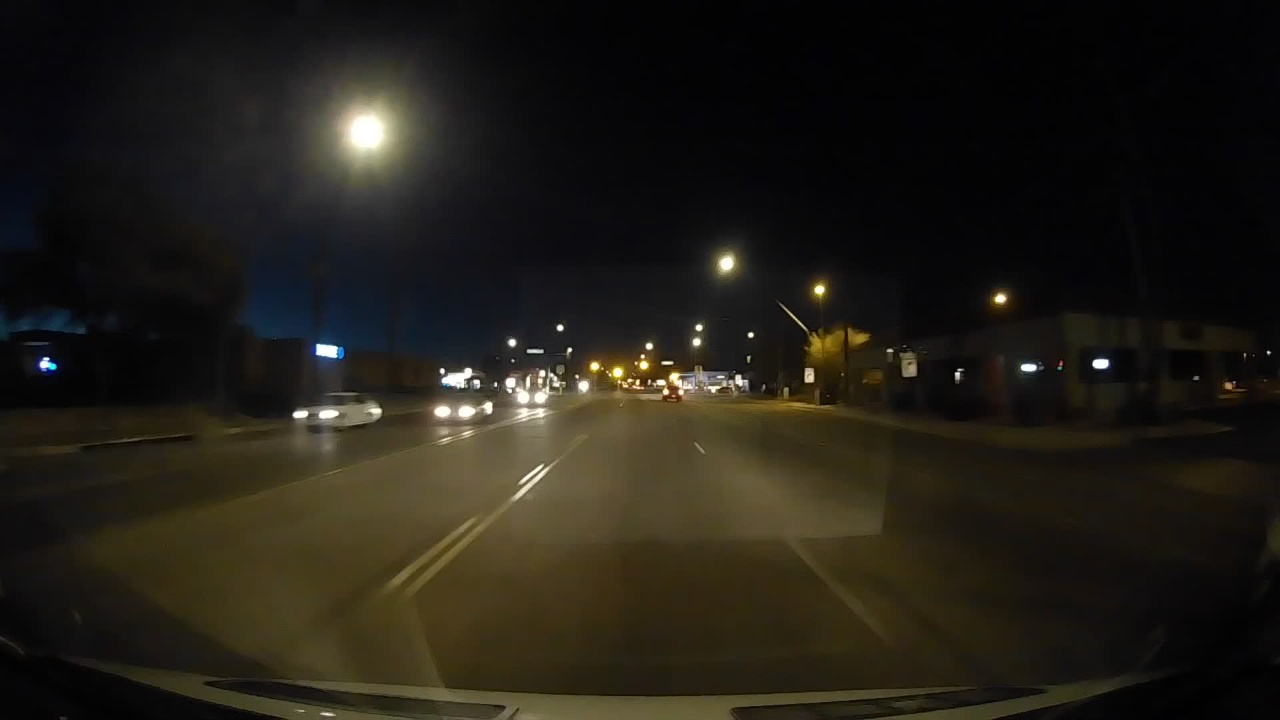

In [39]:
import plotly.express as px





fig = px.imshow(img)
fig.update_layout(dragmode="drawrect")

In [40]:
import plotly 

In [41]:
round(float(scores[index]), 1)

0.6

In [42]:
final_result ={
        "images":images,
        "annotations":annotations,
        "categories":categories
    }

In [43]:
with open('result_dab_deter.json', 'w') as f:
#     js = json.dump(final_result)
    json.dump(final_result, f)

In [ ]:
pred_dict

In [ ]:
annotations

In [ ]:
box_ops.box_xyxy_to_xywh(output['boxes'])*750

In [ ]:
pred_dict

In [ ]:
image = Image.open("./figure/idea.jpg").convert("RGB")
# image

In [ ]:
# transform images

image, _ = transform(image, None)

In [ ]:
# predict images
output = model(image[None])
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]))[0]

In [ ]:
# visualize outputs
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)